# ---OLD

## Preprocessing

首先，分析了相关性，发现部分特征信息重复，故进行特征选择，利用mRMR保留30个特征。

In [ ]:
# 读取数据
data_clean = pd.read_stata('data_clean.dta') 
print("------original size------ ", data_clean.shape)

# 删除缺失值
data_clean = data_clean.drop(data_clean[data_clean['violate'].isna()].index) 
data_clean = data_clean.dropna()
print("------drop na------ ",data_clean.shape)

# 异常值处理：孤立森林
numeric_data = data_clean.select_dtypes(exclude=['category', 'object'])
iso_forest = IsolationForest(n_estimators=100, contamination='auto', random_state=42, n_jobs=-1)
outliers = iso_forest.fit_predict(numeric_data)
numeric_data = numeric_data.copy()
numeric_data['outlier'] = outliers
numeric_data = numeric_data[numeric_data['outlier'] == 1]
data_clean = data_clean.loc[numeric_data.index]
print("------drop bad n------" ,data_clean.shape)

# 异常值处理：'TIE','InvTurnover','SalesGrowth','ARTurnover'
specific_columns = ['TIE', 'InvTurnover', 'SalesGrowth', 'ARTurnover']
specific_data = data_clean[specific_columns].copy() 
iso_forest = IsolationForest(n_estimators=100, contamination='auto', random_state=42, n_jobs=-1)
outliers = iso_forest.fit_predict(specific_data)
specific_data['outlier'] = outliers
specific_data = specific_data[specific_data['outlier'] == 1]
data_clean = data_clean.loc[specific_data.index]
print("------drop bad n for specific var------" ,data_clean.shape)
print("nan值数量：",data_clean.isna().sum().values)
print(data_clean['证监会新'].value_counts())
print('将行业为空记为其它')

# 保存数据
data_clean.to_csv('data_clean_before_selection.csv', index=False)

------original size------  (49819, 45)
------drop na------  (36687, 45)
------drop bad n------ (35703, 45)
------drop bad n for specific var------ (34510, 45)
nan值数量： [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0]
计算机、通信和其他电子设备制造业    2378
                    2083
化学原料和化学制品制造业        2061
医药制造业               2043
电气机械和器材制造业          1713
                    ... 
建筑安装业                 18
科技推广和应用服务业            17
保险业                   17
体育                    15
非金属矿采选业                3
Name: 证监会新, Length: 83, dtype: int64
将行业为空记为其它


In [ ]:
print(data_clean['证监会新'].isna().sum())

0


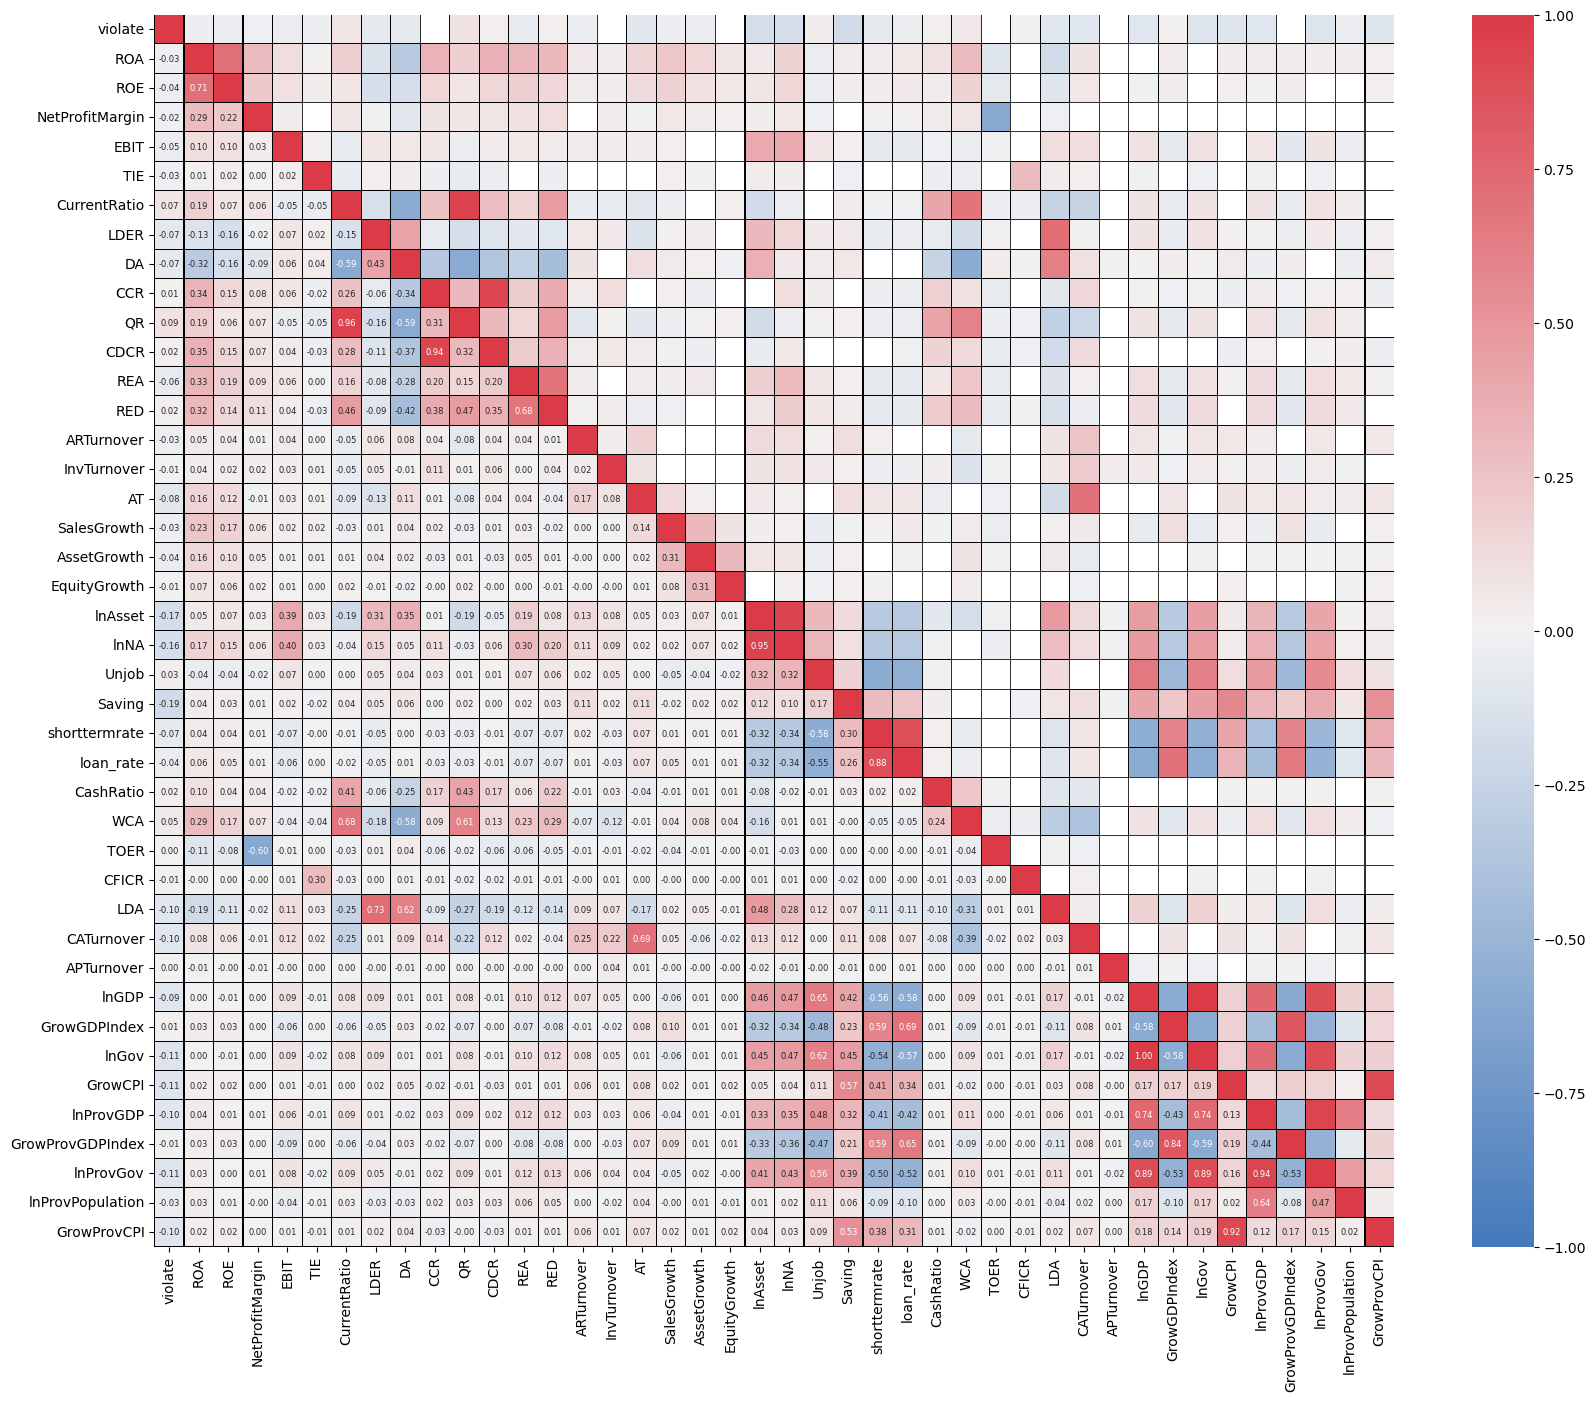

In [ ]:
# 数值型进行相关性分析
numeric_df = data_clean.select_dtypes(include=[np.number])
correlation_matrix =numeric_df.corr(method='pearson')

p_values = pd.DataFrame(data=np.ones_like(correlation_matrix), columns=correlation_matrix.columns, index=correlation_matrix.index)
for col in numeric_df.columns:
    for row in numeric_df.columns:
        if col != row:
            _, p_value = pearsonr(numeric_df[col], numeric_df[row]) #  Pearson product-moment correlation coefficient， p-value
            p_values.loc[row, col] = p_value
        else:
            p_values.loc[row, col] = 0 # 对角线上的值设为0

# 下三角数据保留，上三角数据设为False
mask_lower = np.tril(np.ones_like(correlation_matrix, dtype=bool), -1)

# p值大于0.05（即不显著）为True，其他为False
mask_insignificant = p_values > 0.05


cmap = sns.diverging_palette(250, 10, as_cmap=True)

# 5:4
plt.figure(figsize=(20, 16))

sns.heatmap(correlation_matrix, mask=~mask_lower, annot=True, fmt=".2f", cmap=cmap, cbar=False,vmin=-1, vmax=1, linewidths=0.1, linecolor='black',annot_kws={"size":6 })

sns.heatmap(correlation_matrix, mask=mask_lower | mask_insignificant, annot=False, cmap=cmap,vmin=-1, vmax=1, cbar=True, linewidths=0.1, linecolor='black')

sns.heatmap(correlation_matrix, mask=mask_lower | ~mask_insignificant, annot=False, cmap=["#ffffff"], cbar=False, alpha=0.75, linewidths=0.1, linecolor='black')
plt.savefig('heatmap.pdf', format='pdf')
plt.show()



#### 通过热力图发现需要feature selection



##### 使用lightgbm中的方法（失败）
选出importance比较高的；  
（并且选择过程中利用贝叶斯优化寻找最优参数）；  

In [ ]:
# numeric_cols = data_clean.select_dtypes(include=['number']).columns 
# data_clean[numeric_cols] = data_clean[numeric_cols].fillna(data_clean[numeric_cols].mean()) 
# data_clean['year'] = data_clean['accper'].str[:4].astype(int)
# data_clean = data_clean.drop('accper', axis=1)
# # X = data_clean.drop('accper', axis=1)
# # X = pd.get_dummies(X, columns=['证监会新', 'Prov'])
# # y = data_clean['violate']
# # X = np.ascontiguousarray(X)
# data_clean = pd.get_dummies(data_clean, columns=['证监会新', 'Prov'])

# train = data_clean

贝叶斯优化 bayes-optimizor

In [ ]:

# def LGB_CV(max_depth
#            ,min_child_samples
#            ,min_child_weight
#            ,min_split_gain
#            ,reg_alpha
#            ,reg_lambda
#            ,subsample
#            ,colsample_bytree
#            ,learning_rate
#            ,num_leaves):
    
#     folds = KFold(n_splits=10, shuffle=True, random_state=1)
#     metr = []
#     for train_index, valid_index in folds.split(train):  # 这里的train实际上是所有数据
#         train_tmp = train.iloc[train_index]
#         valid_tmp = train.iloc[valid_index]
#         train_data = lgb.Dataset(train_tmp, label=train_tmp['violate'])
#         valid_data = lgb.Dataset(valid_tmp, label=valid_tmp['violate'])
        
#         param = {'objective':'binary',
#                  'boosting':'gbdt',
#                  'verbosity':-1,
#                  'metrics':'auc',

#                  'max_depth':int(max_depth),
#                  'min_child_samples':int(min_child_samples),
#                  'min_child_weight':min_child_weight,
#                  'min_split_gain':min_split_gain,
#                  'reg_alpha':reg_alpha,
#                  'reg_lambda':reg_lambda,
#                  'subsample':subsample,
#                  'colsample_bytree':colsample_bytree,
#                  'learning_rate':learning_rate,
#                  'num_leaves':int(num_leaves)
#                 }
        
#         clf = lgb.train(param,
#                         train_data,
#                         num_boost_round=500, 
#                         valid_sets=[train_data, valid_data],
#                         )
#         metr.append(metrics.roc_auc_score(valid_tmp['violate'], clf.predict(valid_tmp)))
#     return np.mean(metr)

# # 使用贝叶斯优化器按指定范围搜索n组参数
# LGB_BO = BayesianOptimization(LGB_CV,
#                              {'max_depth':(2,8),
#                               'min_child_samples':(3000,60000),
#                               'min_child_weight':(0,100),
#                               'min_split_gain':(0,10),
#                               'reg_alpha':(0,10),
#                               'reg_lambda':(0,10),
#                               'subsample':(0.4,1),
#                               'colsample_bytree':(0.8,1),
#                               'learning_rate':(0.01,0.6),
#                               'num_leaves':(2,20)})

# LGB_BO.maximize()

# opt_params = LGB_BO.max

In [ ]:
# opt_params

In [ ]:
# # 读取数据
# data_clean = pd.read_stata('data_clean.dta') 
# # 删除缺失值
# data_clean = data_clean.drop(data_clean[data_clean['violate'].isna()].index) 
# data_clean = data_clean.dropna()
# numeric_cols = data_clean.select_dtypes(include=['number']).columns 
# data_clean[numeric_cols] = data_clean[numeric_cols].fillna(data_clean[numeric_cols].mean()) 
# # accper/证监会新/Prov --> category
# data_clean['accper'] = data_clean['accper'].astype('category')
# data_clean['证监会新'] = data_clean['证监会新'].astype('category')
# data_clean['Prov'] = data_clean['Prov'].astype('category')

# params = {
#     'objective': 'binary',
#     'boosting': 'gbdt',
#     'verbosity': -1,
#     'metric': 'auc',
#     'colsample_bytree': 0.8452708998135392,
#   'learning_rate': 0.1,
#   'max_depth': int(4.653037641808043),
#   'min_child_samples': int(3002.9391802035757)-1000,
#   'min_child_weight': 93.3186963373449-10,
#   'min_split_gain': 9.554762295494024,
#   'num_leaves': int(13.980529190588493),
#   'reg_alpha': 0.6431440145356337,
#   'reg_lambda': 0.4694607860819122,
#   'subsample': 0.6697661466284829}

# split_data = data_clean.sample(frac=0.9, random_state=42)
# split_data_1 = data_clean.drop(split_data.index)
# train_data = lgb.Dataset(split_data, label=split_data['violate'])
# valid_data = lgb.Dataset(split_data_1, label=split_data_1['violate'])

# clf = lgb.train(params,
#                 train_data,
#                 num_boost_round=500, 
#                 valid_sets=[train_data, valid_data],
#                 categorical_feature=['证监会新', 'Prov','accper'],
#                 )

# feature_importances = clf.feature_importance()
# split_x=split_data.drop('violate',axis=1)
# feature_names = split_x.columns.tolist()

# feature_importance_dict = dict(zip(feature_names, feature_importances))

# # 重要性排序
# sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# # 解包特征
# features, importances = zip(*sorted_features)

# plt.figure(figsize=(10, 8))
# plt.barh(range(len(features)), importances, align='center')
# plt.yticks(range(len(features)), features)
# plt.xlabel('Feature Importance')
# plt.ylabel('Feature')
# plt.title('Feature Importance Visualization')
# plt.gca().invert_yaxis()  # 反转Y轴，确保重要性最高的特征在顶部
# plt.show()

##### 使用mRMR

In [ ]:
data_clean = pd.read_csv('data_clean_before_selection.csv')
data_clean['证监会新'].fillna('其它', inplace=True)

data_clean['year'] = data_clean['accper'].str[:4].astype(int)
data_clean = data_clean.drop('accper', axis=1)

# 获取特征矩阵和目标变量
X = data_clean.drop(['violate','证监会新','Prov','year'], axis=1).values
y = data_clean['violate'].values

selected_features = MRMR.mrmr(X, y, n_selected_features=30)

print(selected_features)

[26 16 19 17  5  3 18  8  7  6 34  0  1  4  2 11 20 21 13 33 35 31 10 25
  9 24 39 15 40 14 28 38 37 27 30 32 29 36 23 22 12]


In [ ]:
data_clean_p = data_clean.drop(['violate','证监会新','Prov'], axis=1)
retain_columns = data_clean[['violate','证监会新','Prov','year']]

selected_data = data_clean_p.iloc[:, selected_features]
selected_add_data = pd.concat([selected_data, retain_columns], axis=1)  # 保留violate,证监会新,Prov
print(selected_data.columns)
print(selected_add_data.columns)

Index(['WCA', 'SalesGrowth', 'lnAsset', 'AssetGrowth', 'CurrentRatio', 'EBIT',
       'EquityGrowth', 'CCR', 'DA', 'LDER', 'lnGov', 'ROA', 'ROE', 'TIE',
       'NetProfitMargin', 'REA', 'lnNA', 'Unjob', 'ARTurnover', 'GrowGDPIndex',
       'GrowCPI', 'APTurnover', 'CDCR', 'CashRatio', 'QR', 'loan_rate',
       'lnProvPopulation', 'AT', 'GrowProvCPI', 'InvTurnover', 'CFICR',
       'lnProvGov', 'GrowProvGDPIndex', 'TOER', 'CATurnover', 'lnGDP', 'LDA',
       'lnProvGDP', 'shorttermrate', 'Saving', 'RED'],
      dtype='object')
Index(['WCA', 'SalesGrowth', 'lnAsset', 'AssetGrowth', 'CurrentRatio', 'EBIT',
       'EquityGrowth', 'CCR', 'DA', 'LDER', 'lnGov', 'ROA', 'ROE', 'TIE',
       'NetProfitMargin', 'REA', 'lnNA', 'Unjob', 'ARTurnover', 'GrowGDPIndex',
       'GrowCPI', 'APTurnover', 'CDCR', 'CashRatio', 'QR', 'loan_rate',
       'lnProvPopulation', 'AT', 'GrowProvCPI', 'InvTurnover', 'CFICR',
       'lnProvGov', 'GrowProvGDPIndex', 'TOER', 'CATurnover', 'lnGDP', 'LDA',
       'lnPro

In [ ]:
selected_data

WCA  SalesGrowth    lnAsset  AssetGrowth  CurrentRatio  \
0      0.358004     0.279005  22.226156     0.113098      1.666994   
1      0.494197     0.317068  22.449997     0.250871      1.987036   
2      0.498704     0.177446  22.592436     0.153082      1.991119   
3      0.637273     0.026777  22.829329     0.267304      2.532806   
4      0.578821     0.394744  23.080437     0.285451      2.137629   
...         ...          ...        ...          ...           ...   
34505  0.668857     0.363989  21.052880     0.718478      3.508971   
34506  0.479000     0.427792  22.360472     1.072702      1.914701   
34507  0.453556     0.431024  20.961145     0.179483      2.384672   
34508  0.438410     0.430763  23.059950     0.258864      1.713741   
34509  0.286641     0.103029  24.007070     0.358088      1.538933   

               EBIT  EquityGrowth       CCR        DA      LDER  ...  \
0      2.804149e+08      0.021151  0.018684  0.522476  0.027227  ...   
1      3.702903e+08      0.381741  0.033975  0.472516  0.026976  ...   
2      4.915962e+08      0.054099 -0.395519  0.517797  0.083491  ...   
3      5.172410e+08      0.096087  0.042167  0.582944  0.488067  ...   
4      8.157256e+08      0.389324 -0.309492  0.549243  0.204496  ...   
...             ...           ...       ...       ...       ...  ...   
34505  1.591524e+08      0.864867  0.385052  0.227181  0.006299  ...   
34506  5.374079e+08      2.533354  0.268695  0.462742  0.113473  ...   
34507  1.242129e+08      0.135975  0.078327  0.316682  0.000047  ...   
34508  6.286223e+08      0.135280  0.024646  0.557258  0.002560  ...   
34509  1.592937e+09      0.787185  0.280218  0.522470  0.031075  ...   

       lnProvGov  GrowProvGDPIndex      TOER  CATurnover      lnGDP       LDA  \
0      16.083399            9.5000  0.911578    0.752578  11.413816  0.026506   
1      16.195353           10.8256  0.908261    0.751835  11.515723  0.040102   
2      16.396736           10.4890  0.933192    0.734683  11.616052  0.090574   
3      16.537516           12.3731  0.888106    0.591071  11.709457  0.335994   
4      16.646150           14.8000  0.871665    0.624821  11.830812  0.176995   
...          ...               ...       ...         ...        ...       ...   
34505  18.798107            8.6000  0.816569    0.809077  13.954609  0.020685   
34506  18.535410            8.2000  0.890932    1.056799  13.954609  0.121900   
34507  18.798107            8.6000  0.856302    0.894464  13.954609  0.020146   
34508  18.517317            8.4767  0.907865    0.462495  13.954609  0.013745   
34509  18.517317            8.4767  0.968293    2.042344  13.954609  0.112813   

       lnProvGDP  shorttermrate  Saving       RED  
0       9.043613          6.075  37.103  0.285156  
1       9.175980          5.850  36.123  0.331914  
2       9.395927          5.850  37.800  0.347568  
3       9.510625          5.355  38.820  0.430280  
4       9.670587          5.310  41.862  0.386833  
...          ...            ...     ...       ...  
34505  11.664480          4.350  45.549  1.211741  
34506  10.893972          4.350  45.549  0.331901  
34507  11.664480          4.350  45.549  0.576915  
34508  11.205255          4.350  45.549  0.280823  
34509  11.205255          4.350  45.549  0.447252  

[34510 rows x 41 columns]

In [ ]:
selected_add_data.to_csv('data_clean_after_selection.csv', index=False)

In [ ]:
## 上面废弃

data_clean=pd.read_csv('data_clean_before_selection.csv')
_, data_clean =  fea_sel_mrmr(data_clean,name_of_y='violate',n=30)
data_clean.to_csv('data_clean_after_selection_0.csv',index=False)

Selected features: [26 16 19 17  5  3 18  8  7  6 34  0  1  4  2 11 20 21 13 33 35 31 10 25
  9 24 39 15 40 14 22 32 12 38 37 30 29 28 36 23 27]


wcss: [1238132.4822908682, 1149823.5824801188, 1080736.711271405, 1044512.397518461, 1009152.3588678011, 986578.9961463511, 959047.3929007165, 933307.5720147099, 905157.1039716203, 886386.3995003325, 861105.6710747625, 853733.6812277159, 827975.8015651768]
silhouette_coefficients: [0.16421895401872283, 0.16364258753035965, 0.16111551708186725, 0.16137470404861828, 0.1432195795162416, 0.14203210240159225, 0.12193517752284064, 0.10882847625140352, 0.10873712724746482, 0.11026311499141773, 0.11088679573552586, 0.09667151286113293, 0.09621773262311162]


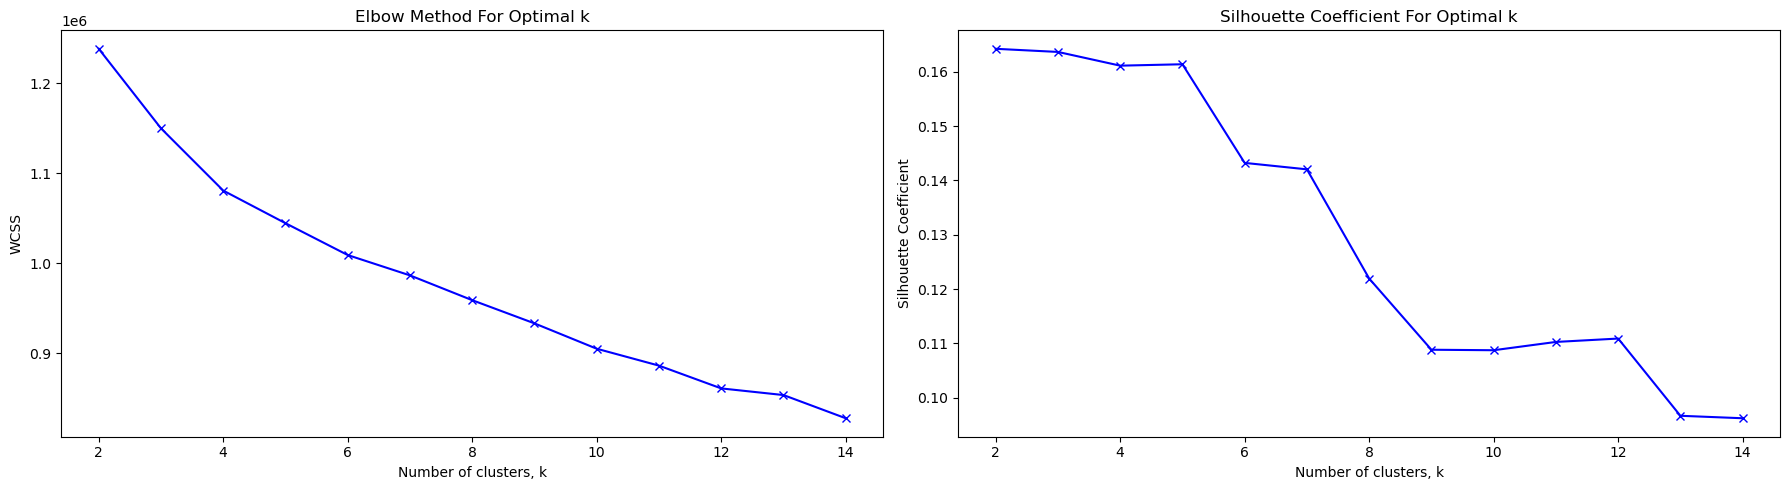

In [ ]:
data_clean=pd.read_csv('data_clean_after_selection_0.csv')
wacc=elbow_fig(data_clean,name_of_y='violate',name_of_dataset='after_selection',figure_size=(18, 5))

BSS: 370281.2509042385
Pseudo F: 3058.01888824037


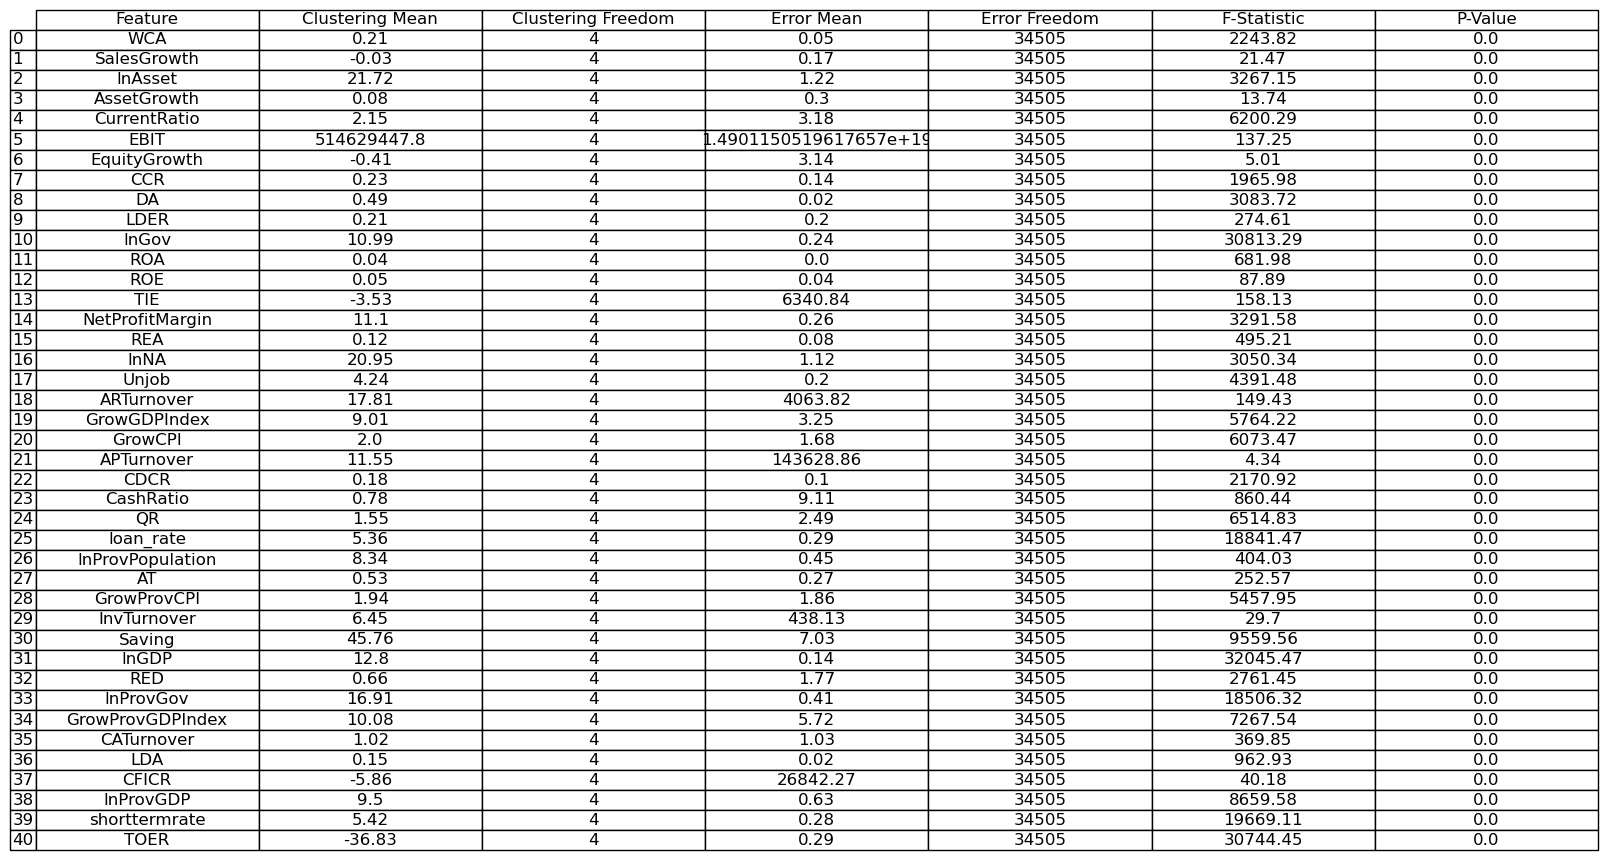

3058.01888824037

In [ ]:
kmeans_cluster(data_clean, name_of_y='violate' ,name_of_dataset='after_selection',best_k=5 , wcss=wacc, figure_size=(12, 2))

### Feature-selection的检查

In [ ]:
data_clean = pd.read_csv('data_clean_before_selection.csv')
data_clean['year'] = data_clean['accper'].str[:4].astype(int)
data_clean = data_clean.drop('accper', axis=1)
X=data_clean[selected_data.columns.tolist()]
y=data_clean['violate']

# 标准化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 确定最佳的K值（肘部法则）
wcss = []
silhouette_coefficients = []
# 尝试不同的K值范围，例如2到10
K_range = range(2, 11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)
    # 计算轮廓系数
    score = silhouette_score(X_scaled, kmeans.labels_)
    silhouette_coefficients.append(score)

d:\python\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
d:\python\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
d:\python\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
d:\python\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._chec

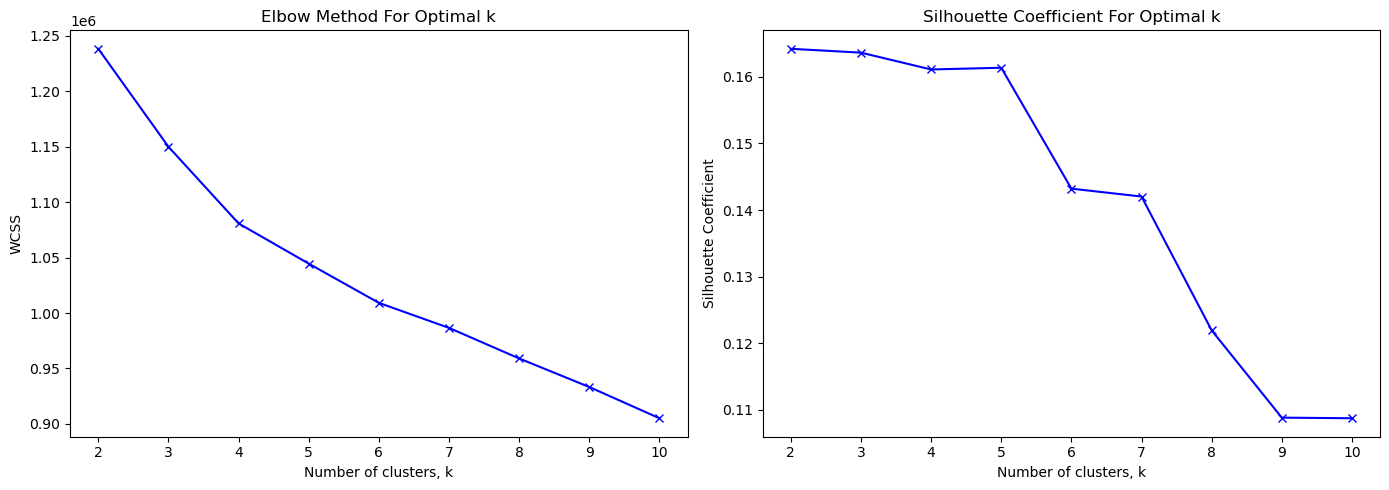

In [ ]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(K_range, wcss, 'bx-')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters, k')
plt.ylabel('WCSS')

# 绘制轮廓系数图
plt.subplot(1, 2, 2)
plt.plot(K_range, silhouette_coefficients, 'bx-')
plt.title('Silhouette Coefficient For Optimal k')
plt.xlabel('Number of clusters, k')
plt.ylabel('Silhouette Coefficient')

plt.tight_layout()
plt.savefig('elbow_method.pdf', format='pdf')
plt.show()

肘部法则图（左侧）显示了随着K值的增加，WCSS（Within-cluster Sum of Squares）是怎样逐渐下降的。理想的K值通常是在WCSS下降趋势突然变缓的地方，也就是“肘部”点。在这个图中，看起来K值为4或5的时候下降趋势开始变缓。
轮廓系数衡量的是聚类的凝聚度和分离度，系数值越高，表明聚类效果越好。在这个图中，K值为2的时候轮廓系数最高，但从K=3开始到K=5，轮廓系数的值保持稳定，而后在K>5时轮廓系数显著下降。
综合考虑这两个图，一个好的K值选择应该是WCSS开始减缓变化，并且轮廓系数相对较高的点。虽然K=2/3时轮廓系数最高，但从整体变化趋势来看，K=4或K=5可能是一个更好的选择，因为轮廓系数比较稳定，且肘部图中WCSS的减速点在这附近。

In [ ]:
# wcss =[1331233.9670992459,
#  1231680.3316625203,
#  1167070.0525298638,
#  1124987.582391948,
#  1086820.9244521738,
#  1042575.0930455857,
#  1008533.7871087565,
#  974843.1890342534,
#  939024.0936596184]

k=5

d:\python\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


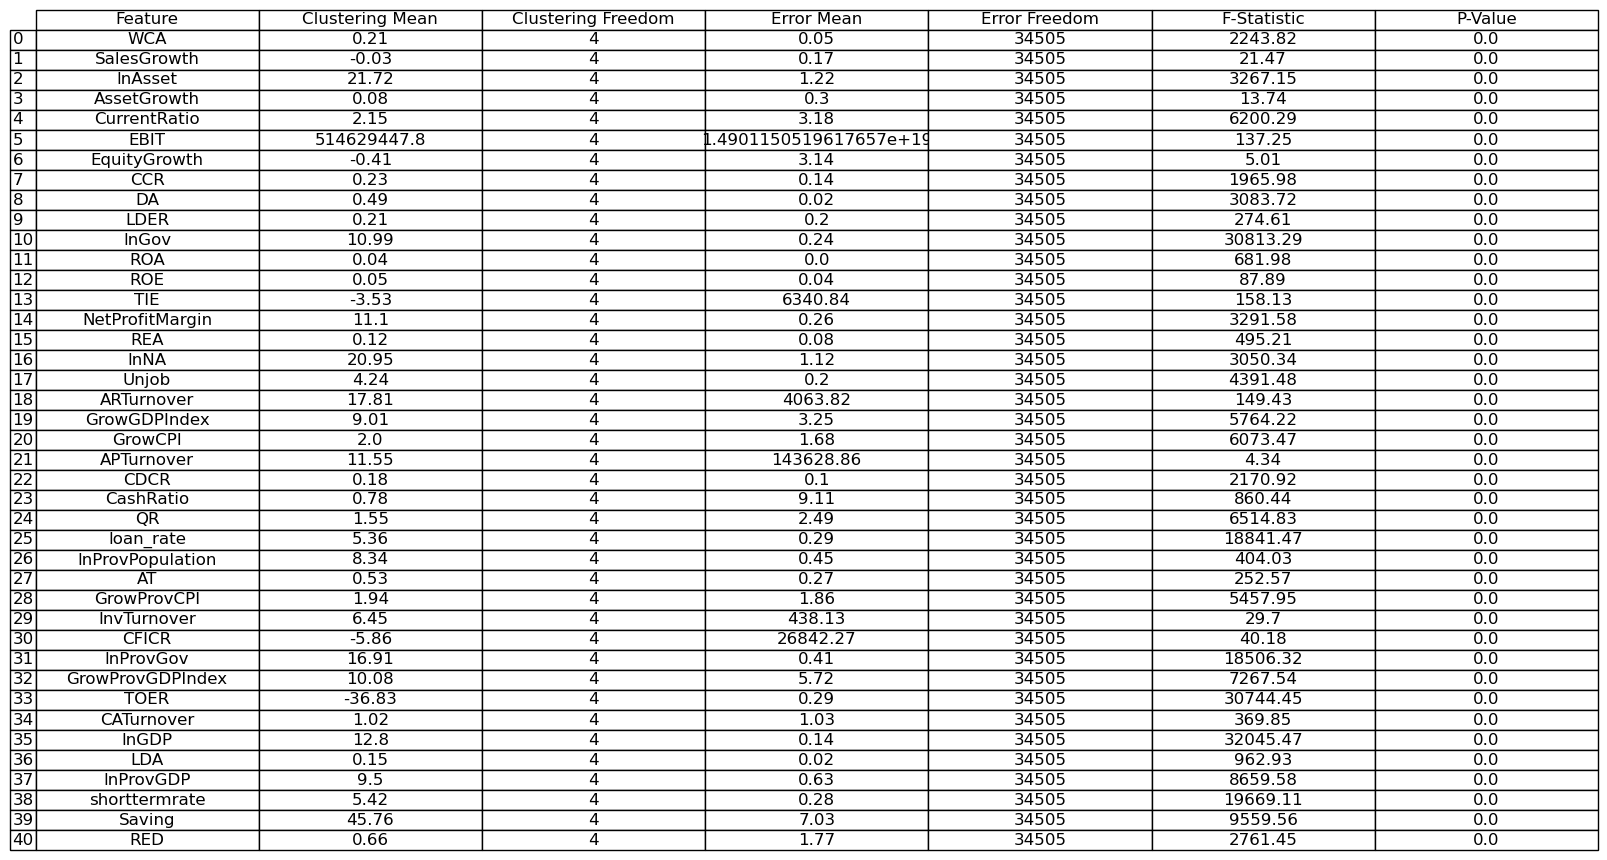

In [ ]:
best_k = 5  # 最佳的K值，根据前面的分析得出
kmeans = KMeans(n_clusters=best_k, random_state=42)
cluster_labels = kmeans.fit_predict(X_scaled)
wcss_4 = wcss[best_k - 2]

# 聚类间的总方差（Between-cluster Sum of Squares, BSS）=总方差减去WCSS
# $$ BSS = \sum_{i=1}^{k} n_i ||c_i - c||^2 $$
# $n_i$第$i$个聚类中的样本数量，$c_i$是第$i$个聚类的中心，$c$是所有样本平均值
overall_mean = np.mean(X_scaled, axis=0)
bss = np.sum([len(X_scaled[cluster_labels == i]) * np.linalg.norm(kmeans.cluster_centers_[i] - overall_mean)**2 for i in range(best_k)])

# 伪F统计量计算公式
# $$ pseudo_f = \frac{BSS / (k - 1)}{WCSS / (n - k)} $$
# $BSS$是聚类间总方差，$WCSS$聚类内总方差
n = len(X_scaled)  # 样本总数
pseudo_f = (bss / (best_k - 1)) / (wcss_4 / (n - best_k))

# ANOVA F-test
#对每个特征执行ANOVA F-test，原始数据\聚类标签
# $$ F = \frac{MS_{between}}{MS_{within}} $$
# $MS_{between}$ 聚类间均方差，$MS_{within}$聚类内均方差.
f_statistic = []
p_values = []
for feature in X.columns:
    # Create an array for each cluster's feature values
    group_data = [X[feature][cluster_labels == k] for k in range(best_k)]
    stat, p_val = f_oneway(*group_data)
    f_statistic.append(stat)
    p_values.append(p_val)

clustering_freedom = best_k - 1
error_freedom = len(X) - best_k
clustering_means = X.groupby(cluster_labels).mean()
clustering_means = clustering_means.mean(axis=0)
error_means = X.groupby(cluster_labels).var().mean(axis=0)

anova_results=pd.DataFrame(columns=['Feature', 'Clustering Mean', 'Clustering Freedom', 'Error Mean', 'Error Freedom', 'F-Statistic', 'P-Value'])
anova_results['F-Statistic'] = f_statistic
anova_results['P-Value'] = p_values
anova_results['Clustering Mean'] = clustering_means.values
anova_results['Error Mean'] = error_means.values
anova_results['Clustering Freedom'] = [clustering_freedom] * len(X.columns)
anova_results['Error Freedom'] = [error_freedom] * len(X.columns)
anova_results['Feature'] = X.columns
anova_results = anova_results[['Feature', 'Clustering Mean', 'Clustering Freedom', 'Error Mean', 'Error Freedom', 'F-Statistic', 'P-Value']]

anova_results['P-Value'] = anova_results['P-Value'].round(2)
anova_results['F-Statistic'] = anova_results['F-Statistic'].round(2)
anova_results['Clustering Mean'] = anova_results['Clustering Mean'].round(2)
anova_results['Error Mean'] = anova_results['Error Mean'].round(2)

display_df = anova_results
fig, ax = plt.subplots(figsize=(12, 2))
ax.axis('off')
tbl = table(ax, display_df, loc='center', cellLoc='center', colWidths=[0.2]*len(display_df.columns))
tbl.auto_set_font_size(False)
tbl.set_fontsize(12)
tbl.scale(1.2, 1.2)  # 可以调整大小来适应文本
plt.savefig('cluster_5.pdf', bbox_inches='tight', format='pdf')
plt.show()

k=4

d:\python\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


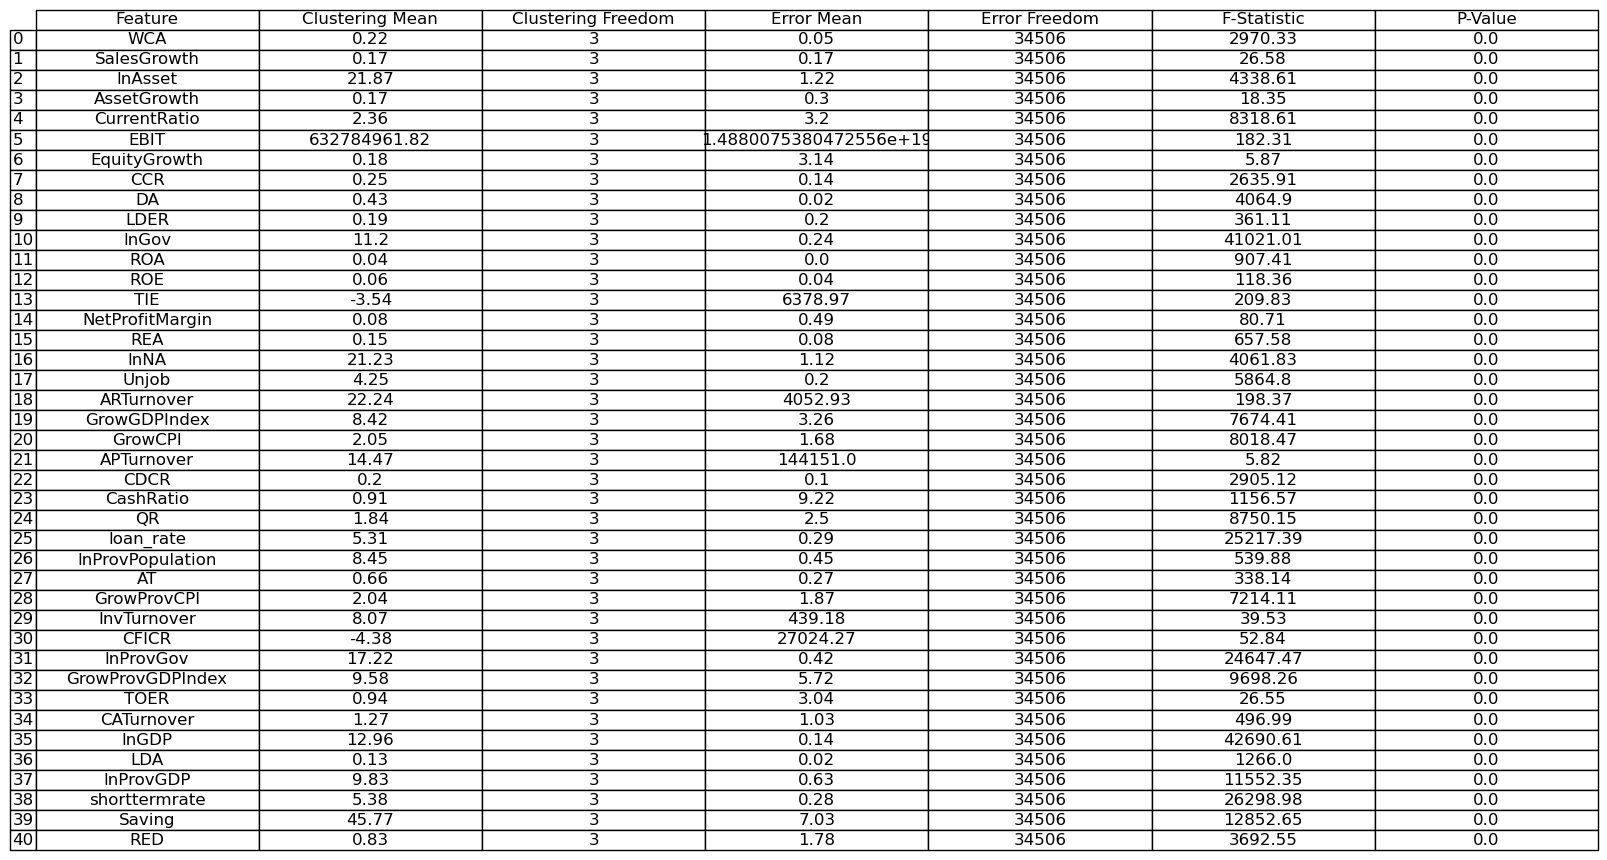

In [ ]:
best_k = 4  # 最佳的K值，根据前面的分析得出
kmeans = KMeans(n_clusters=best_k, random_state=42)
cluster_labels = kmeans.fit_predict(X_scaled)
wcss_4 = wcss[best_k - 2]

# 聚类间的总方差（Between-cluster Sum of Squares, BSS）=总方差减去WCSS
# $$ BSS = \sum_{i=1}^{k} n_i ||c_i - c||^2 $$
# $n_i$第$i$个聚类中的样本数量，$c_i$是第$i$个聚类的中心，$c$是所有样本平均值
overall_mean = np.mean(X_scaled, axis=0)
bss = np.sum([len(X_scaled[cluster_labels == i]) * np.linalg.norm(kmeans.cluster_centers_[i] - overall_mean)**2 for i in range(best_k)])

# 伪F统计量计算公式
# $$ pseudo_f = \frac{BSS / (k - 1)}{WCSS / (n - k)} $$
# $BSS$是聚类间总方差，$WCSS$聚类内总方差
n = len(X_scaled)  # 样本总数
pseudo_f = (bss / (best_k - 1)) / (wcss_4 / (n - best_k))

# ANOVA F-test
#对每个特征执行ANOVA F-test，原始数据\聚类标签
# $$ F = \frac{MS_{between}}{MS_{within}} $$
# $MS_{between}$ 聚类间均方差，$MS_{within}$聚类内均方差.
f_statistic = []
p_values = []
for feature in X.columns:
    # Create an array for each cluster's feature values
    group_data = [X[feature][cluster_labels == k] for k in range(best_k)]
    stat, p_val = f_oneway(*group_data)
    f_statistic.append(stat)
    p_values.append(p_val)

clustering_freedom = best_k - 1
error_freedom = len(X) - best_k
clustering_means = X.groupby(cluster_labels).mean()
clustering_means = clustering_means.mean(axis=0)
error_means = X.groupby(cluster_labels).var().mean(axis=0)

anova_results=pd.DataFrame(columns=['Feature', 'Clustering Mean', 'Clustering Freedom', 'Error Mean', 'Error Freedom', 'F-Statistic', 'P-Value'])
anova_results['F-Statistic'] = f_statistic
anova_results['P-Value'] = p_values
anova_results['Clustering Mean'] = clustering_means.values
anova_results['Error Mean'] = error_means.values
anova_results['Clustering Freedom'] = [clustering_freedom] * len(X.columns)
anova_results['Error Freedom'] = [error_freedom] * len(X.columns)
anova_results['Feature'] = X.columns
anova_results = anova_results[['Feature', 'Clustering Mean', 'Clustering Freedom', 'Error Mean', 'Error Freedom', 'F-Statistic', 'P-Value']]

anova_results['P-Value'] = anova_results['P-Value'].round(2)
anova_results['F-Statistic'] = anova_results['F-Statistic'].round(2)
anova_results['Clustering Mean'] = anova_results['Clustering Mean'].round(2)
anova_results['Error Mean'] = anova_results['Error Mean'].round(2)

display_df = anova_results
fig, ax = plt.subplots(figsize=(12, 2))
ax.axis('off')
tbl = table(ax, display_df, loc='center', cellLoc='center', colWidths=[0.2]*len(display_df.columns))
tbl.auto_set_font_size(False)
tbl.set_fontsize(12)
tbl.scale(1.2, 1.2)  # 可以调整大小来适应文本
plt.savefig('cluster_4.pdf', bbox_inches='tight', format='pdf')
plt.show()

## Bagging
9 min

In [ ]:
data_clean = pd.read_csv('data_clean_after_selection.csv')
data_clean['证监会新'].fillna('其它', inplace=True)
print(data_clean.columns)
print(data_clean.isna().sum())
data_clean[['证监会新', 'Prov', 'year']] = data_clean[['证监会新', 'Prov', 'year']].astype('category')
print('------------------Columns converted to category------------------')
print(data_clean.isna().sum())
print(data_clean.columns)

X=data_clean.drop('violate',axis=1)
y=data_clean['violate']
print("X中的缺失值:",X.isnull().sum().mean()) 
print("y中的缺失值:",y.isnull().sum()) 
print('------------------Data Enocoder------------------')
categorical_features = ['证监会新', 'Prov', 'year']
label_encoder = LabelEncoder()
for col in categorical_features:
    data_clean[col] = label_encoder.fit_transform(data_clean[col])
X_encoded = data_clean.drop('violate', axis=1)
y_encoded = data_clean['violate']
# 检查缺失值
print("X_encoded中的缺失值:",X_encoded.isnull().sum().mean())
print("y_encoded中的缺失值:",y_encoded.isnull().sum()) 
print('------------------Preprocessing done------------------')
print(data_clean.shape)


# 定义性能指标
scoring = {'accuracy': make_scorer(accuracy_score),
           'precision': make_scorer(precision_score),
           'recall': make_scorer(recall_score),
           'f1_score': make_scorer(f1_score),
           'roc_auc': make_scorer(roc_auc_score, needs_proba=True)}

models_bagging = {
    'Bag_DT': BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=10, random_state=0),
    'Bag_KNN': BaggingClassifier(base_estimator=KNeighborsClassifier(), n_estimators=10, random_state=0),
    'Bag_SVM': BaggingClassifier(base_estimator=SVC(), n_estimators=10, random_state=0, bootstrap_features=True),
    'RF': RandomForestClassifier(n_estimators=80, random_state=0)
}

results_bagging = {}

print("Starting cross-validation...")
# 交叉验证并计算不同性能指标
for name, model_bagging in models_bagging.items():
    print(f"------------------Evaluating model: {name}------------------")
    cv_results_bagging = cross_validate(model_bagging, X_encoded, y_encoded, cv=10, scoring=scoring, n_jobs=-1) # n_jobs=-1 使用所有CPU核心
    results_bagging[name] = cv_results_bagging


with open('results_ensemble_method.pkl', 'wb') as f:
    pickle.dump(results_bagging, f)

df_results_bagging = pd.DataFrame(results_bagging)
df_results_bagging.to_csv('result_bagging_model.csv', index=False)
df_results_bagging.to_csv('result_bagging_model_0.csv', index=True)

print("------------------Results saved------------------")

Index(['WCA', 'SalesGrowth', 'lnAsset', 'AssetGrowth', 'CurrentRatio', 'EBIT',
       'EquityGrowth', 'CCR', 'DA', 'LDER', 'lnGov', 'ROA', 'ROE', 'TIE',
       'NetProfitMargin', 'REA', 'lnNA', 'Unjob', 'ARTurnover', 'GrowGDPIndex',
       'GrowCPI', 'APTurnover', 'CDCR', 'CashRatio', 'QR', 'loan_rate',
       'lnProvPopulation', 'AT', 'GrowProvCPI', 'InvTurnover', 'CFICR',
       'lnProvGov', 'GrowProvGDPIndex', 'TOER', 'CATurnover', 'lnGDP', 'LDA',
       'lnProvGDP', 'shorttermrate', 'Saving', 'RED', 'violate', '证监会新',
       'Prov', 'year'],
      dtype='object')
WCA                 0
SalesGrowth         0
lnAsset             0
AssetGrowth         0
CurrentRatio        0
EBIT                0
EquityGrowth        0
CCR                 0
DA                  0
LDER                0
lnGov               0
ROA                 0
ROE                 0
TIE                 0
NetProfitMargin     0
REA                 0
lnNA                0
Unjob               0
ARTurnover          0
GrowGDPI

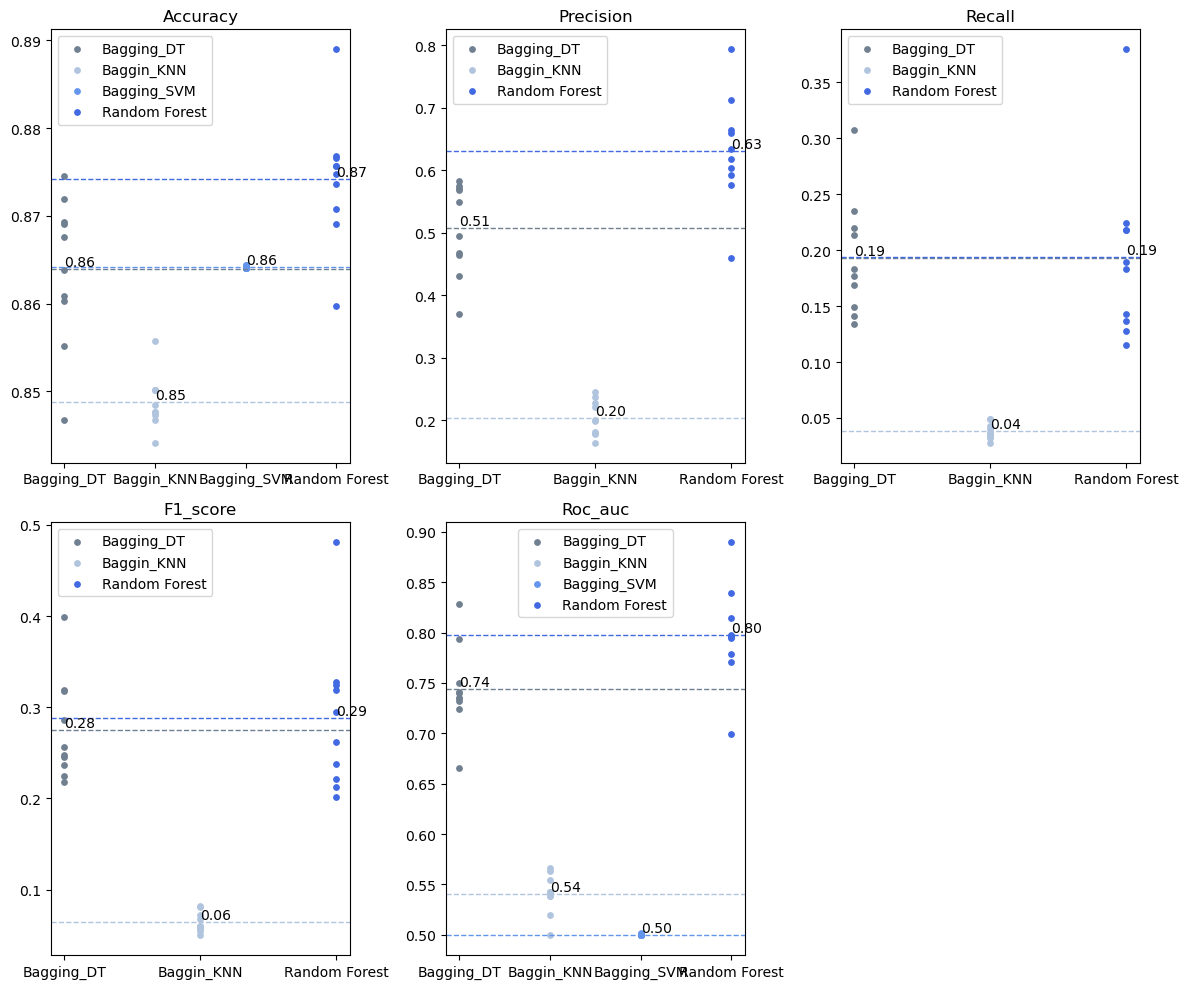

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(12, 10))
axs = axs.flatten()
metrics = ['test_accuracy', 'test_precision', 'test_recall', 'test_f1_score', 'test_roc_auc']
colors = ['slategrey', 'lightsteelblue', 'cornflowerblue', 'royalblue']


for i, metric in enumerate(metrics):
    ax = axs[i]
    ax.set_title(metric.replace('test_', '').capitalize())
    
    for j, (name, model_results) in enumerate(results_bagging.items()):
        scores = model_results[metric]
        mean_score = np.mean(scores)  # 计算平均得分

        
        if name == 'Bagging_SVM' and metric in ['test_precision', 'test_recall', 'test_f1_score'] and mean_score == 0:
            continue
        ax.scatter([name]*len(scores), scores, color=colors[j], label=name,s=15)
        # 绘制平均得分的线
        ax.axhline(mean_score, linestyle='--', color=colors[j], linewidth=1)
        ax.text(name, mean_score, f'{mean_score:.2f}', ha='left', va='bottom', fontsize=10)

    ax.legend()

if len(metrics) < len(axs):
    fig.delaxes(axs[-1])

plt.tight_layout()
plt.savefig('performance_bagging.png')
plt.savefig('performance_bagging.pdf', format='pdf')
plt.show()

## Boosting

1 min

In [ ]:
data_clean = pd.read_csv('data_clean_after_selection.csv')
data_clean['证监会新'].fillna('其它', inplace=True)
print(data_clean.columns)
print(data_clean.isna().sum())
data_clean[['证监会新', 'Prov', 'year']] = data_clean[['证监会新', 'Prov', 'year']].astype('category')
print('------------------Columns converted to category------------------')
print(data_clean.isna().sum())
print(data_clean.columns)

X=data_clean.drop('violate',axis=1)
y=data_clean['violate']
print("X中的缺失值:",X.isnull().sum().mean()) 
print("y中的缺失值:",y.isnull().sum()) 


print('------------------Data Enocoder------------------')
categorical_features = ['证监会新', 'Prov', 'year']
# encoder = OneHotEncoder(sparse=False, drop='first')
# encoded_features = encoder.fit_transform(data_clean[categorical_features])
# encoded_feature_names = encoder.get_feature_names_out(categorical_features)
# encoded_df = pd.DataFrame(encoded_features, columns=encoded_feature_names)
# data_clean_encoded = pd.concat([data_clean.drop(categorical_features, axis=1).reset_index(drop=True),
#                                 encoded_df.reset_index(drop=True)], axis=1)
# X_encoded = data_clean_encoded.drop('violate', axis=1)
# y_encoded = data_clean_encoded['violate']

label_encoder = LabelEncoder()
for col in categorical_features:
    data_clean[col] = label_encoder.fit_transform(data_clean[col])
X_encoded = data_clean.drop('violate', axis=1)
y_encoded = data_clean['violate']
# 检查缺失值
print("X_encoded中的缺失值:",X_encoded.isnull().sum().mean())
print("y_encoded中的缺失值:",y_encoded.isnull().sum()) 

print('------------------Preprocessing done------------------')
print(data_clean.shape)

Index(['WCA', 'SalesGrowth', 'lnAsset', 'AssetGrowth', 'CurrentRatio', 'EBIT',
       'EquityGrowth', 'CCR', 'DA', 'LDER', 'lnGov', 'ROA', 'ROE', 'TIE',
       'NetProfitMargin', 'REA', 'lnNA', 'Unjob', 'ARTurnover', 'GrowGDPIndex',
       'GrowCPI', 'APTurnover', 'CDCR', 'CashRatio', 'QR', 'loan_rate',
       'lnProvPopulation', 'AT', 'GrowProvCPI', 'InvTurnover', 'CFICR',
       'lnProvGov', 'GrowProvGDPIndex', 'TOER', 'CATurnover', 'lnGDP', 'LDA',
       'lnProvGDP', 'shorttermrate', 'Saving', 'RED', 'violate', '证监会新',
       'Prov', 'year'],
      dtype='object')
WCA                 0
SalesGrowth         0
lnAsset             0
AssetGrowth         0
CurrentRatio        0
EBIT                0
EquityGrowth        0
CCR                 0
DA                  0
LDER                0
lnGov               0
ROA                 0
ROE                 0
TIE                 0
NetProfitMargin     0
REA                 0
lnNA                0
Unjob               0
ARTurnover          0
GrowGDPI

In [ ]:
# 定义性能指标
scoring = {'accuracy': make_scorer(accuracy_score),
           'precision': make_scorer(precision_score),
           'recall': make_scorer(recall_score),
           'f1_score': make_scorer(f1_score),
           'roc_auc': make_scorer(roc_auc_score, needs_proba=True)}

# 定义模型
models = {
    'AdaBoost': AdaBoostClassifier(),
    'XGBoost': xgb.XGBClassifier(eval_metric='logloss'),  # 添加eval_metric参数以避免XGBoost的警告
    'LightGBM': lgb.LGBMClassifier(categorical_feature=['证监会新', 'Prov','year'])
}

results = {}
for name, model in models.items():
    print(f"Evaluating model: {name}...")
    if name == 'LightGBM':
        cv_results = cross_validate(model, X, y, cv=10, scoring=scoring, n_jobs=-1)
    else:
        cv_results = cross_validate(model, X_encoded, y_encoded, cv=10, scoring=scoring, n_jobs=-1) # n_jobs=-1 使用所有CPU核心
    results[name] = cv_results

with open('results_boosting.pkl', 'wb') as f:
    pickle.dump(results, f)
df_results = pd.DataFrame(results)
df_results.to_csv('result_boosting.csv', index=False)
df_results.to_csv('result_boosting_0.csv', index=True)

Evaluating model: AdaBoost...
Evaluating model: XGBoost...
Evaluating model: LightGBM...


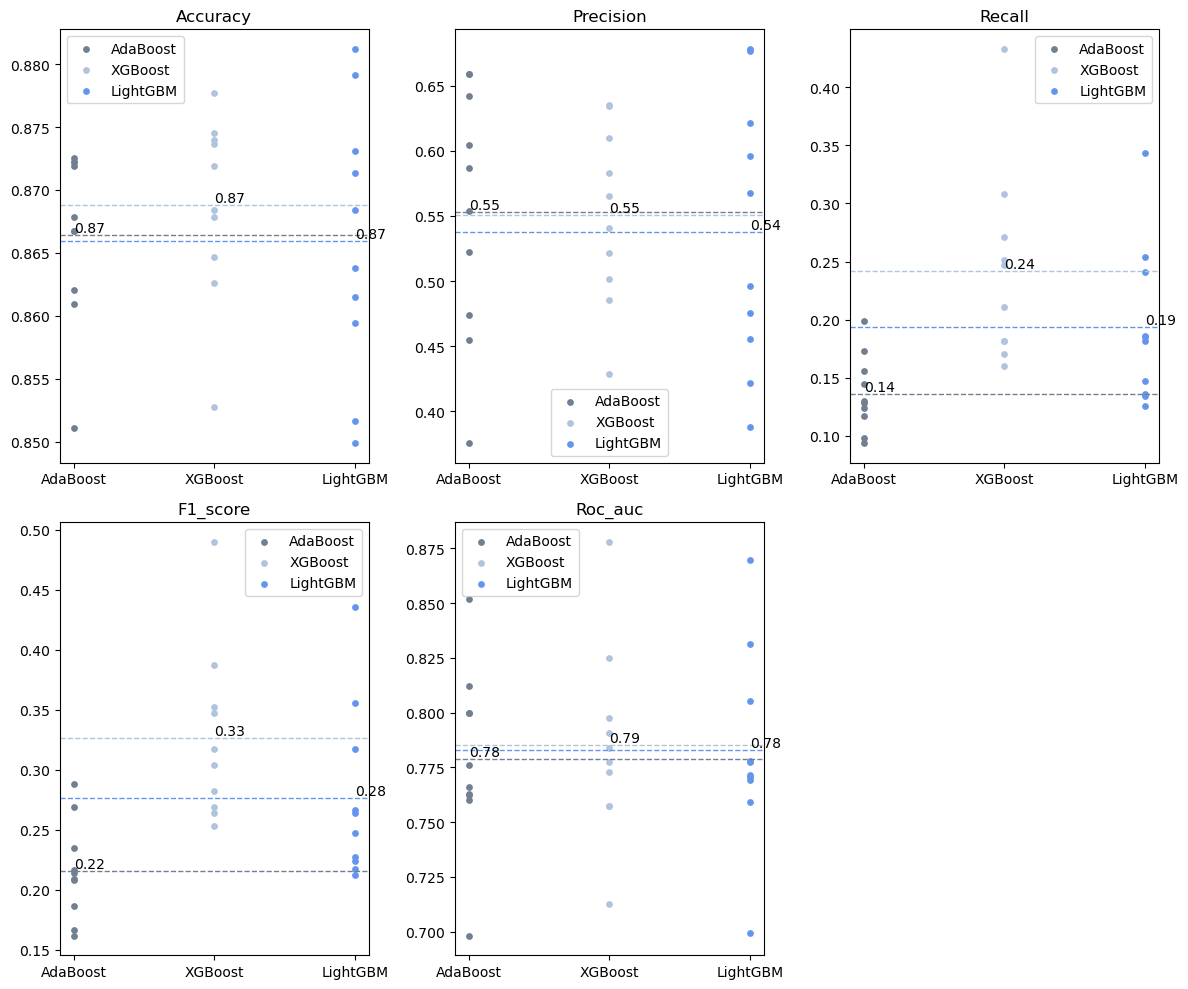

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(12, 10))
axs = axs.flatten()
metrics = ['test_accuracy', 'test_precision', 'test_recall', 'test_f1_score', 'test_roc_auc']
colors = ['slategrey', 'lightsteelblue', 'cornflowerblue', 'royalblue']

for i, metric in enumerate(metrics):

    ax = axs[i]
    ax.set_title(metric.replace('test_', '').capitalize())
    
    for j, (name, model_results) in enumerate(results.items()):
        scores = model_results[metric]
        mean_score = np.mean(scores)  # 计算平均得分
        ax.scatter([name]*len(scores), scores, color=colors[j], label=name,s=15)
        
        # 绘制平均得分的线
        ax.axhline(mean_score, linestyle='--', color=colors[j], linewidth=1)
        ax.text(name, mean_score, f'{mean_score:.2f}', ha='left', va='bottom', fontsize=10)
    ax.legend()

# 删除最后一个子图
if len(metrics) < len(axs):
    fig.delaxes(axs[-1])

plt.tight_layout()
plt.savefig('performance_boosting.png')
plt.savefig('performance_boosting.pdf', format='pdf')
plt.show()


## Basic Model

14 min

In [ ]:
data_clean = pd.read_csv('data_clean_after_selection.csv')
data_clean['证监会新'].fillna('其它', inplace=True)
print(data_clean.columns)
print(data_clean.isna().sum())
data_clean[['证监会新', 'Prov', 'year']] = data_clean[['证监会新', 'Prov', 'year']].astype('category')
print('------------------Columns converted to category------------------')
print(data_clean.isna().sum())
print(data_clean.columns)

X=data_clean.drop('violate',axis=1)
y=data_clean['violate']
print("X中的缺失值:",X.isnull().sum().mean()) 
print("y中的缺失值:",y.isnull().sum()) 
print('------------------Data Enocoder------------------')
categorical_features = ['证监会新', 'Prov', 'year']
label_encoder = LabelEncoder()
for col in categorical_features:
    data_clean[col] = label_encoder.fit_transform(data_clean[col])
X_encoded = data_clean.drop('violate', axis=1)
y_encoded = data_clean['violate']
# 检查缺失值
print("X_encoded中的缺失值:",X_encoded.isnull().sum().mean())
print("y_encoded中的缺失值:",y_encoded.isnull().sum()) 
print('------------------Preprocessing done------------------')
print(data_clean.shape)

# 定义性能指标
scoring = {'accuracy': make_scorer(accuracy_score),
           'precision': make_scorer(precision_score),
           'recall': make_scorer(recall_score),
           'f1_score': make_scorer(f1_score),
           'roc_auc': make_scorer(roc_auc_score, needs_proba=True)}

# basic model: DT, SVM, NB, KNN, RF, LR
models = {
    'DT': DecisionTreeClassifier(),
    'SVM': Pipeline([('scaler', StandardScaler()), ('svc', SVC(probability=True))]),
    'NB': GaussianNB(),
    'KNN': Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsClassifier())]),
    'RF': RandomForestClassifier(n_estimators=75),
    'LR': LogisticRegression()
}

# 存储结果
basic_results = {}

# 交叉验证并计算不同性能指标
for name, model in models.items():
    print(f"Evaluating model: {name}...")
    cv_results = cross_validate(model, X_encoded, y_encoded, cv=10, scoring=scoring, n_jobs=-1) # n_jobs=-1 使用所有CPU核心
    basic_results[name] = cv_results 

basic_results = pd.DataFrame(basic_results)
basic_results.to_csv('result_stacking.csv', index=False)
basic_results.to_csv('result_stacking_0.csv', index=True)

print("Results saved.")

Index(['WCA', 'SalesGrowth', 'lnAsset', 'AssetGrowth', 'CurrentRatio', 'EBIT',
       'EquityGrowth', 'CCR', 'DA', 'LDER', 'lnGov', 'ROA', 'ROE', 'TIE',
       'NetProfitMargin', 'REA', 'lnNA', 'Unjob', 'ARTurnover', 'GrowGDPIndex',
       'GrowCPI', 'APTurnover', 'CDCR', 'CashRatio', 'QR', 'loan_rate',
       'lnProvPopulation', 'AT', 'GrowProvCPI', 'InvTurnover', 'CFICR',
       'lnProvGov', 'GrowProvGDPIndex', 'TOER', 'CATurnover', 'lnGDP', 'LDA',
       'lnProvGDP', 'shorttermrate', 'Saving', 'RED', 'violate', '证监会新',
       'Prov', 'year'],
      dtype='object')
WCA                 0
SalesGrowth         0
lnAsset             0
AssetGrowth         0
CurrentRatio        0
EBIT                0
EquityGrowth        0
CCR                 0
DA                  0
LDER                0
lnGov               0
ROA                 0
ROE                 0
TIE                 0
NetProfitMargin     0
REA                 0
lnNA                0
Unjob               0
ARTurnover          0
GrowGDPI

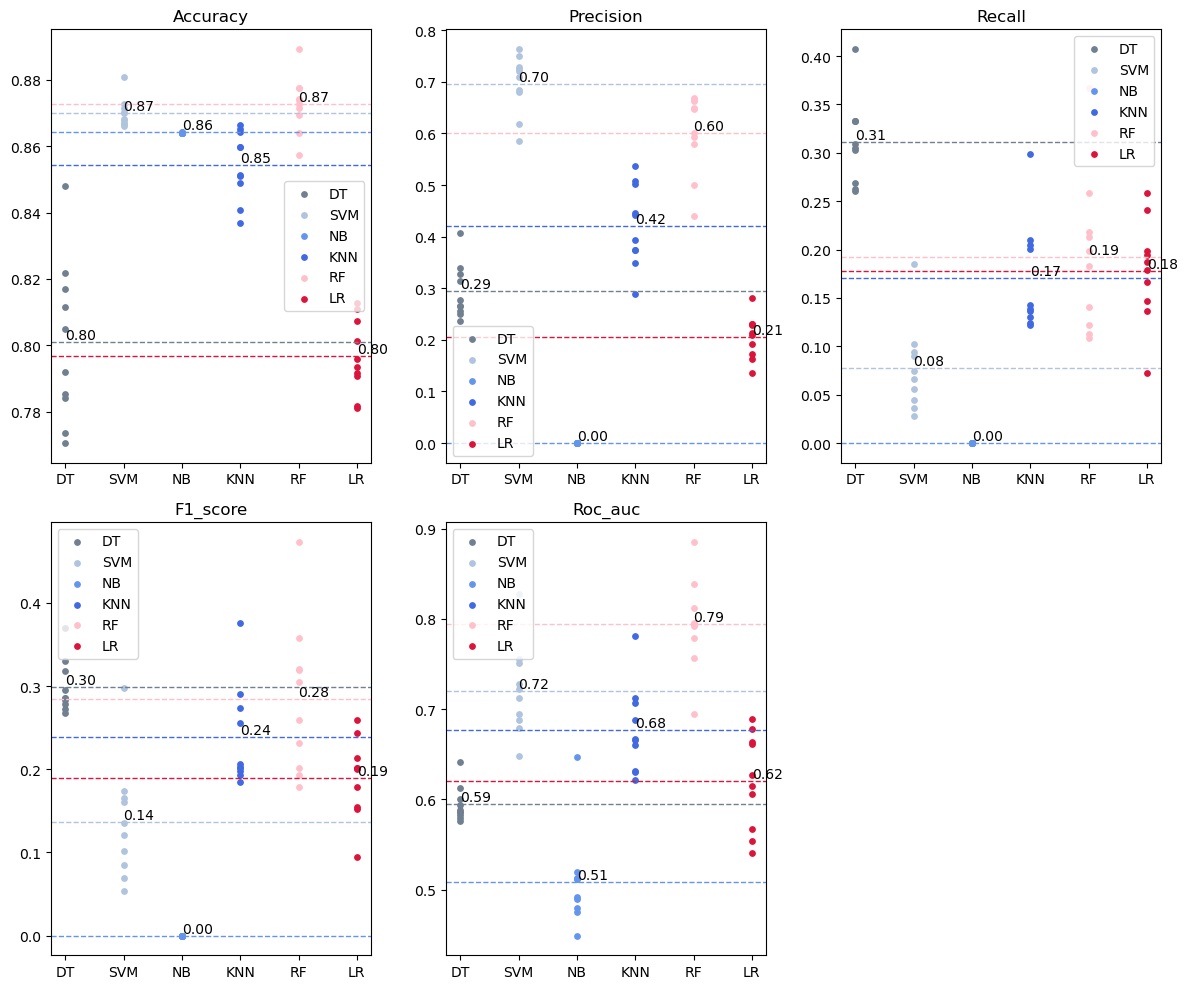

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(12, 10))
axs = axs.flatten()
metrics = ['test_accuracy', 'test_precision', 'test_recall', 'test_f1_score', 'test_roc_auc']
colors = ['slategrey', 'lightsteelblue', 'cornflowerblue', 'royalblue', 'pink', 'crimson']

for i, metric in enumerate(metrics):

    ax = axs[i]
    ax.set_title(metric.replace('test_', '').capitalize())
    
    for j, (name, model_results) in enumerate(basic_results.items()):
        scores = model_results[metric]
        mean_score = np.mean(scores)  # 计算平均得分
        ax.scatter([name]*len(scores), scores, color=colors[j], label=name,s=15)
        
        ax.axhline(mean_score, linestyle='--', color=colors[j], linewidth=1)
        ax.text(name, mean_score, f'{mean_score:.2f}', ha='left', va='bottom', fontsize=10)
    ax.legend()

if len(metrics)  < len(axs):
    fig.delaxes(axs[-1])

plt.tight_layout()
plt.savefig('performance_stacking.png')
plt.savefig('performance_stacking.pdf', format='pdf')
plt.show()

## Stacking

143 min

In [ ]:
data_clean = pd.read_csv('data_clean_after_selection.csv')
data_clean['证监会新'].fillna('其它', inplace=True)
print(data_clean.columns)
print(data_clean.isna().sum())
data_clean[['证监会新', 'Prov', 'year']] = data_clean[['证监会新', 'Prov', 'year']].astype('category')
print('------------------Columns converted to category------------------')
print(data_clean.isna().sum())
print(data_clean.columns)

X=data_clean.drop('violate',axis=1)
y=data_clean['violate']
print("X中的缺失值:",X.isnull().sum().mean()) 
print("y中的缺失值:",y.isnull().sum()) 
print('------------------Data Enocoder------------------')
categorical_features = ['证监会新', 'Prov', 'year']
label_encoder = LabelEncoder()
for col in categorical_features:
    data_clean[col] = label_encoder.fit_transform(data_clean[col])
X_encoded = data_clean.drop('violate', axis=1)
y_encoded = data_clean['violate']
# 检查缺失值
print("X_encoded中的缺失值:",X_encoded.isnull().sum().mean())
print("y_encoded中的缺失值:",y_encoded.isnull().sum()) 
print('------------------Preprocessing done------------------')
print(data_clean.shape)

Index(['WCA', 'SalesGrowth', 'lnAsset', 'AssetGrowth', 'CurrentRatio', 'EBIT',
       'EquityGrowth', 'CCR', 'DA', 'LDER', 'lnGov', 'ROA', 'ROE', 'TIE',
       'NetProfitMargin', 'REA', 'lnNA', 'Unjob', 'ARTurnover', 'GrowGDPIndex',
       'GrowCPI', 'APTurnover', 'CDCR', 'CashRatio', 'QR', 'loan_rate',
       'lnProvPopulation', 'AT', 'GrowProvCPI', 'InvTurnover', 'CFICR',
       'lnProvGov', 'GrowProvGDPIndex', 'TOER', 'CATurnover', 'lnGDP', 'LDA',
       'lnProvGDP', 'shorttermrate', 'Saving', 'RED', 'violate', '证监会新',
       'Prov', 'year'],
      dtype='object')
WCA                 0
SalesGrowth         0
lnAsset             0
AssetGrowth         0
CurrentRatio        0
EBIT                0
EquityGrowth        0
CCR                 0
DA                  0
LDER                0
lnGov               0
ROA                 0
ROE                 0
TIE                 0
NetProfitMargin     0
REA                 0
lnNA                0
Unjob               0
ARTurnover          0
GrowGDPI

In [ ]:

# StackingClassifier(estimators, final_estimator=None, cv=None, stack_method='auto', n_jobs=None, passthrough=False, verbose=0)

scoring = {'accuracy': make_scorer(accuracy_score),
           'precision': make_scorer(precision_score),
           'recall': make_scorer(recall_score),
           'f1_score': make_scorer(f1_score),
           'roc_auc': make_scorer(roc_auc_score, needs_proba=True)}

base_models = {0: ('DT', DecisionTreeClassifier(max_depth=10)), 
               1: ('SVM', Pipeline([('scaler', StandardScaler()), ('svc', SVC(probability=True))])), 
               2: ('NB', GaussianNB()), 
               3: ('KNN', Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsClassifier(n_neighbors=10))])), 
               4: ('RF', RandomForestClassifier(n_estimators=75)), 
               5: ('LR', LogisticRegression())}

models = {}

for i in range(6):
    selected_keys = random.sample(list(base_models.keys()), 4)
    selected_models = [base_models[key] for key in selected_keys]
    model_name = 'stacking_' + ''.join(map(str, sorted(selected_keys)))
    models[model_name] = StackingClassifier(estimators=selected_models, final_estimator=xgb.XGBClassifier(eval_metric='logloss'))

stacking_results = {}

for name, model in models.items():
    print(f"Evaluating model: {name}...")
    cv_results = cross_validate(model, X_encoded, y_encoded, cv=5, scoring=scoring,n_jobs=-1)
    stacking_results[name] = cv_results

stacking_results = pd.DataFrame(stacking_results)
stacking_results.to_csv('result_stacking.csv', index=False)
stacking_results.to_csv('result_stacking_0.csv', index=True)

print("Results saved.")

Evaluating model: stacking_1234...
Evaluating model: stacking_0125...
Evaluating model: stacking_0123...
Evaluating model: stacking_0124...
Evaluating model: stacking_0145...
Evaluating model: stacking_0245...
Results saved.


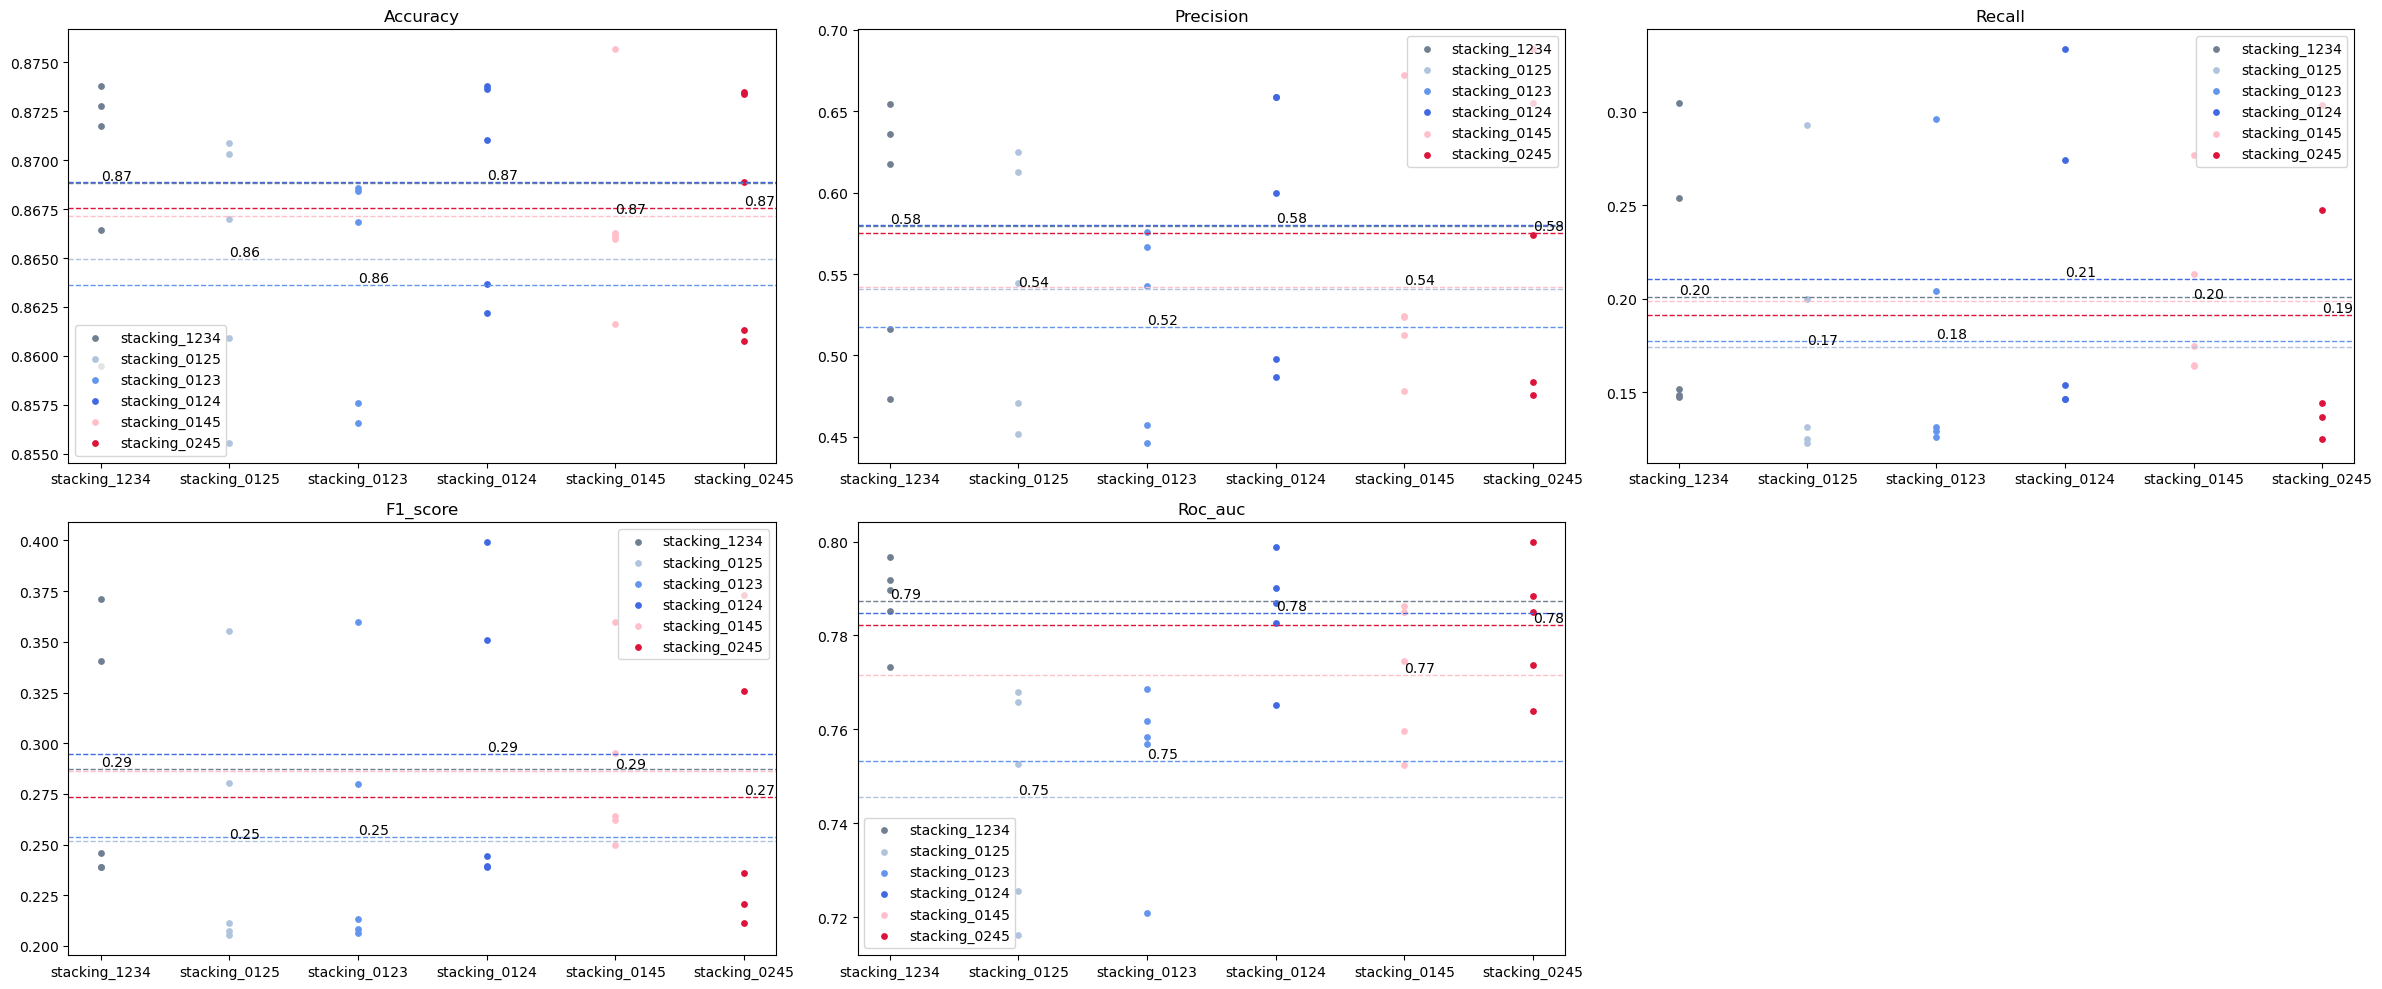

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(24, 10))
axs = axs.flatten()
metrics = ['test_accuracy', 'test_precision', 'test_recall', 'test_f1_score', 'test_roc_auc']
colors = ['slategrey', 'lightsteelblue', 'cornflowerblue', 'royalblue','pink', 'crimson']

for i, metric in enumerate(metrics):

    ax = axs[i]
    ax.set_title(metric.replace('test_', '').capitalize())
    
    for j, (name, model_results) in enumerate(stacking_results.items()):
        scores = model_results[metric]
        mean_score = np.mean(scores)  # 计算平均得分
        ax.scatter([name]*len(scores), scores, color=colors[j], label=name,s=15)
        
        # 绘制平均得分的线
        ax.axhline(mean_score, linestyle='--', color=colors[j], linewidth=1)
        ax.text(name, mean_score, f'{mean_score:.2f}', ha='left', va='bottom', fontsize=10)
    ax.legend()

# 删除最后一个子图
if len(metrics) < len(axs):
    fig.delaxes(axs[-1])

plt.tight_layout()
plt.savefig('performance_stacking.png')
plt.savefig('performance_stacking.pdf', format='pdf')
plt.show()

## 封装

In [ ]:
def outlier_handling(data_set,name_of_y,specific_vars=[]):
    '''
    
    This fuction is used to handle outliers in the dataset.

    Parameters:
        - data_set: the dataset that needs to handle outliers.
        - name_of_y: the name of the target variable.
        - specific_vars: the specific variables that need to handle outliers. If it is empty, all numeric variables will be used to handle outliers.
    
    Return:
        - data_set_drop_outlier: the dataset after handling outliers.

    '''
    from sklearn.ensemble import IsolationForest
    print('Size of data set:',data_set.shape)
    data_set_drop_y = data_set.drop(name_of_y, axis=1)
    if specific_vars==[]:
        numeric_data = data_set_drop_y.select_dtypes(exclude=['category', 'object'])
        iso_forest = IsolationForest(n_estimators=100, contamination='auto', random_state=42, n_jobs=-1)
        outliers = iso_forest.fit_predict(numeric_data)
        numeric_data = numeric_data.copy()
        numeric_data['outlier'] = outliers
        numeric_data = numeric_data[numeric_data['outlier'] == 1]
        data_set_drop_outlier = data_set.loc[numeric_data.index]
    else:
        specific_data = data_set_drop_y[specific_vars].copy() 
        iso_forest = IsolationForest(n_estimators=100, contamination='auto', random_state=42, n_jobs=-1)
        outliers = iso_forest.fit_predict(specific_data)
        specific_data['outlier'] = outliers
        specific_data = specific_data[specific_data['outlier'] == 1]
        data_set_drop_outlier = data_set.loc[specific_data.index]

    print('Size of data set after handling outliers:',data_set_drop_outlier.shape)
    return data_set_drop_outlier

In [ ]:
def corr_analysis(data_set,name_of_y,name_of_dataset,figure_size=(12, 12)):
    '''
    This function is used to analyze the correlation between variables in the dataset.

    Parameters:
        - data_set: the dataset that needs to analyze the correlation.
        - name_of_y: the name of the target variable.
        - name_of_dataset: the name of the dataset.
    '''
    import seaborn as sns
    import matplotlib.pyplot as plt
    import numpy as np
    from scipy.stats import pearsonr
    import pandas as pd

    data_set=data_set.drop(name_of_y,axis=1)
    numeric_df = data_set.select_dtypes(include=[np.number])
    correlation_matrix =numeric_df.corr(method='pearson')

    p_values = pd.DataFrame(data=np.ones_like(correlation_matrix), columns=correlation_matrix.columns, index=correlation_matrix.index)
    for col in numeric_df.columns:
        for row in numeric_df.columns:
            if col != row:
                _, p_value = pearsonr(numeric_df[col], numeric_df[row]) #  Pearson product-moment correlation coefficient， p-value
                p_values.loc[row, col] = p_value
            else:
                p_values.loc[row, col] = 0 # 对角线上的值设为0

    mask_lower = np.tril(np.ones_like(correlation_matrix, dtype=bool), -1)
    mask_insignificant = p_values > 0.05
    cmap = sns.diverging_palette(250, 10, as_cmap=True)
    plt.figure(figsize=figure_size)
    sns.heatmap(correlation_matrix, mask=~mask_lower, annot=True, fmt=".2f", cmap=cmap, cbar=False,vmin=-1, vmax=1, linewidths=0.1, linecolor='black',annot_kws={"size":6 })
    sns.heatmap(correlation_matrix, mask=mask_lower | mask_insignificant, annot=False, cmap=cmap,vmin=-1, vmax=1, cbar=True, linewidths=0.1, linecolor='black')
    sns.heatmap(correlation_matrix, mask=mask_lower | ~mask_insignificant, annot=False, cmap=["#ffffff"], cbar=False, alpha=0.75, linewidths=0.1, linecolor='black')
    filename=name_of_dataset+'_heatmap.pdf'
    plt.savefig(filename, format='pdf')
    plt.show()

In [49]:

def fea_sel_mrmr(data_set: pd.DataFrame, name_of_y: str, n=None, name_of_dataset='default'):
    '''
    This function is used to select features based on the MRMR algorithm.

    Parameters:
        - data_set: the dataset that needs to select features.
        - name_of_y: the name of the target variable.
        - n: the number of features to select.
    
    Return:
        - selected_data: the DataFrame after selecting features.
        - selected_add_data: the DataFrame after selecting features and adding the target variable and the categorical variables.
    '''

    from skfeature.function.information_theoretical_based import MRMR
    from sklearn.preprocessing import LabelEncoder
    
    # Separate numeric and categorical data
    numeric_data = data_set.select_dtypes(exclude=['category', 'object'])
    categorical_data = data_set.select_dtypes(include=['category', 'object'])

    # Prepare the labels
    if data_set[name_of_y].dtype in ['object', 'category']:
        le = LabelEncoder()
        y = le.fit_transform(data_set[name_of_y])
    else:
        y = data_set[name_of_y].values

    # Prepare the features, exclude the target variable if it's numeric
    if name_of_y in numeric_data.columns:
        X = numeric_data.drop(name_of_y, axis=1)
    else:
        X = numeric_data

    if n == None:
        n = X.shape[1]

    # Perform MRMR feature selection
    selected_features, J_CMI, MIfy = MRMR.mrmr(X.values, y, n_selected_features=n, mode='index')

    # Print selected feature details
    selected_columns = X.columns[selected_features]
    print('Selected features:', selected_features)
    print('Selected feature names:', list(selected_columns))
    print('Objective function value:', J_CMI)
    print('MI of selected features and response:', MIfy)

    # Construct the selected data
    selected_data = data_set[selected_columns]
    selected_add_data = pd.concat([selected_data, categorical_data, data_set[[name_of_y]]], axis=1)

    # Plotting feature importance
    plt.figure(figsize=(12, 8))
    feature_indices = range(1, len(selected_features) + 1)
    plt.plot(feature_indices, J_CMI, '-o', color='cornflowerblue', markeredgecolor='grey')
    for i, txt in enumerate(selected_features):
        plt.annotate(f'{X.columns[txt]}\n({J_CMI[i]:.2f})', 
                     (feature_indices[i], J_CMI[i]), 
                     textcoords="offset points", xytext=(0,10), ha='center', fontsize=7)
    plt.title('Feature Importance from MRMR Selection')
    plt.xlabel('Number of Features Selected')
    plt.ylabel('Objective Function Values')
    plt.xticks(feature_indices, rotation=45)  # Rotate labels by 45 degrees
    plt.grid(True)  # Adding grid for better readability
    plt.tight_layout()
    plt.savefig(f'{name_of_dataset}_mrmr.pdf', format='pdf')
    plt.show()

    return selected_data, selected_add_data



In [ ]:
def elbow_fig(data_set,name_of_y,name_of_dataset,figure_size=(18, 5)):
    '''
    This function is used to draw the elbow figure to determine the optimal number of clusters.

    Parameters:
        - data_set: the dataset that needs to draw the elbow figure.
        - name_of_y: the name of the target variable.
        - figure_size: the size of the figure.

    Return:
        - wcss: the within-cluster sum of squares for different numbers of clusters.
    '''
    from sklearn.cluster import KMeans
    from sklearn.preprocessing import StandardScaler
    import matplotlib.pyplot as plt
    from sklearn.metrics import silhouette_score

    X = data_set.drop(name_of_y, axis=1)
    X = X.select_dtypes(include=[np.number])
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    wcss = []
    silhouette_coefficients = []
    K_range = range(2, 15)
    for k in K_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(X_scaled)
        wcss.append(kmeans.inertia_)
        score = silhouette_score(X_scaled, kmeans.labels_)
        silhouette_coefficients.append(score)
    print('wcss:',wcss)
    print('silhouette_coefficients:',silhouette_coefficients)

    plt.figure(figsize=figure_size)
    plt.subplot(1, 2, 1)
    plt.plot(K_range, wcss, 'bx-')
    plt.title('Elbow Method For Optimal k')
    plt.xlabel('Number of clusters, k')
    plt.ylabel('WCSS')

    plt.subplot(1, 2, 2)
    plt.plot(K_range, silhouette_coefficients, 'bx-')
    plt.title('Silhouette Coefficient For Optimal k')
    plt.xlabel('Number of clusters, k')
    plt.ylabel('Silhouette Coefficient')

    plt.tight_layout()
    filename=name_of_dataset+'_elbow.pdf'
    plt.savefig(filename, format='pdf')
    plt.show()

    return wcss



In [ ]:
def kmeans_cluster(data_set, name_of_y ,name_of_dataset,best_k , wcss, figure_size=(12, 2)):
    
    '''
    from sklearn.cluster import KMeans
    from scipy.stats import f_oneway
    from matplotlib.table import table
    
    This fuction is used to perform K-means clustering and ANOVA F-test. It's a validation test for the feature selection.

    Parameters:
        - data_set: the dataset that needs to perform K-means clustering and ANOVA F-test.
        - name_of_y: the name of the target variable.
        - best_k: the best number of clusters.
        - wcss: the within-cluster sum of squares for different numbers of clusters.

    return:
        - pseudo_f: the pseudo F-statistic value.
    '''

    X = data_set.drop(name_of_y, axis=1)
    X = X.select_dtypes(include=[np.number])
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    kmeans = KMeans(n_clusters=best_k, n_init=10, random_state=42)
    cluster_labels = kmeans.fit_predict(X_scaled)
    wcss_best = wcss[best_k - 2]
    overall_mean = np.mean(X_scaled, axis=0)
    bss = np.sum([len(X_scaled[cluster_labels == i]) * np.linalg.norm(kmeans.cluster_centers_[i] - overall_mean)**2 for i in range(best_k)])
    n = len(X_scaled)
    pseudo_f = (bss / (best_k - 1)) / (wcss_best / (n - best_k))
    print('BSS:',bss)
    print('Pseudo F:',pseudo_f)

    f_statistic = []
    p_values = []
    for feature in X.columns:
        # Create an array for each cluster's feature values
        group_data = [X[feature][cluster_labels == k] for k in range(best_k)]
        stat, p_val = f_oneway(*group_data)
        f_statistic.append(stat)
        p_values.append(p_val)
    
    clustering_freedom = best_k - 1
    error_freedom = len(X) - best_k
    clustering_means = X.groupby(cluster_labels).mean()
    clustering_means = clustering_means.mean(axis=0)
    error_means = X.groupby(cluster_labels).var().mean(axis=0)

    anova_results=pd.DataFrame(columns=['Feature', 'Clustering Mean', 'Clustering Freedom', 'Error Mean', 'Error Freedom', 'F-Statistic', 'P-Value'])
    anova_results['F-Statistic'] = f_statistic
    anova_results['P-Value'] = p_values
    anova_results['Clustering Mean'] = clustering_means.values
    anova_results['Error Mean'] = error_means.values
    anova_results['Clustering Freedom'] = [clustering_freedom] * len(X.columns)
    anova_results['Error Freedom'] = [error_freedom] * len(X.columns)
    anova_results['Feature'] = X.columns
    anova_results = anova_results[['Feature', 'Clustering Mean', 'Clustering Freedom', 'Error Mean', 'Error Freedom', 'F-Statistic', 'P-Value']]

    anova_results['P-Value'] = anova_results['P-Value'].round(2)
    anova_results['F-Statistic'] = anova_results['F-Statistic'].round(2)
    anova_results['Clustering Mean'] = anova_results['Clustering Mean'].round(2)
    anova_results['Error Mean'] = anova_results['Error Mean'].round(2)

    display_df = anova_results
    display_df.to_csv(name_of_y+'_cluster_k'+str(best_k)+'.csv', index=False)
    fig, ax = plt.subplots(figsize=figure_size)
    ax.axis('off')
    tbl = table(ax, display_df, loc='center', cellLoc='center', colWidths=[0.2]*len(display_df.columns))
    tbl.auto_set_font_size(False)
    tbl.set_fontsize(12)
    tbl.scale(1.2, 1.2)
    filename=name_of_dataset+'_cluster_k'+str(best_k)+'.pdf'
    plt.savefig(filename, bbox_inches='tight', format='pdf')
    plt.show()

    return pseudo_f

In [ ]:
def prediction_save(data_set,name_of_y,name_of_dataset,categorical_features=[],cv_n=10,multi_class=False):
    '''
    This function is used for prediction of:
        - Basic Model: Decision Tree, SVM, Naive Bayes, KNN, Random Forest, Logistic Regression
        - Bagging Model: Bagging Decision Tree, Bagging KNN, Bagging SVM, Random Forest
        - Boosting Model: AdaBoost, XGBoost, LightGBM
        - Stacking Model:
            - Base Models: Decision Tree, SVM, Naive Bayes, KNN, Random Forest, Logistic Regression
            - Meta Model: XGBoost
    for classification problems (including 0-1/multi).

    Parameters:
        - data_set: the preprocessed dataset, dataframe
        - name_of_y: the name of the target variable, str
        - name_of_dataset: the name of the dataset, used for saving the results, str
        - categorical_features: the names of categorical features, list
        - cv_n: the number of cross-validation, int
    
    *SMOTE:
        - If the dataset is highly imbalanced, SMOTE will be used to oversample the minority class.
        - Condition: y_counts.min()/data_set[name_of_y].count()<0.01 or y_counts.min()<cv_n
    
    '''
    import pandas as pd
    import numpy as np
    import random
    from sklearn.preprocessing import LabelEncoder
    from sklearn.svm import SVC
    from sklearn.naive_bayes import GaussianNB
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.model_selection import cross_validate
    from sklearn.preprocessing import StandardScaler
    from sklearn.pipeline import Pipeline
    from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
    from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, StackingClassifier, GradientBoostingClassifier,AdaBoostClassifier
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.linear_model import LogisticRegression
    from sklearn import metrics
    import matplotlib.pyplot as plt
    import seaborn as sns
    from imblearn.pipeline import Pipeline as IMBPipeline
    import xgboost as xgb
    import lightgbm as lgb
    from bayes_opt import BayesianOptimization

    # data_set: 预处理好的数据集
        # data_name: 数据集的名字，用于保存结果
    # name_of_y: y的名称
    # categorical_features: 类别变量的名称，为列表

    y_counts = data_set[name_of_y].value_counts()
    data_name=name_of_dataset
    if multi_class==True:
        n_y=data_set[name_of_y].nunique()
        scoring = {
            'accuracy': make_scorer(accuracy_score),
            'precision': make_scorer(precision_score, average='weighted'),
            'recall': make_scorer(recall_score, average='weighted'),
            'f1_score': make_scorer(f1_score, average='weighted'),
            'roc_auc': make_scorer(roc_auc_score, needs_proba=True, multi_class='ovo')  # 'ovo' | 'ovr'
            }
    else:
        scoring = {'accuracy': make_scorer(accuracy_score),
            'precision': make_scorer(precision_score),
            'recall': make_scorer(recall_score),
            'f1_score': make_scorer(f1_score),
            'roc_auc': make_scorer(roc_auc_score, needs_proba=True)}
    
    
    if categorical_features!=[]:
        print("categorical features:",categorical_features)
        data_set[categorical_features]=data_set[categorical_features].astype('category')
    print(data_set.isna().sum().mean())
    X=data_set.drop(name_of_y,axis=1)
    y=data_set[name_of_y]
    if categorical_features!=[]:
        label_encoder = LabelEncoder()
        for col in categorical_features:
            data_set[col] = label_encoder.fit_transform(data_set[col])
        X_encoded = data_set.drop(name_of_y, axis=1)
        y_encoded = y
        print('X(categorical) is label encoded.')
    else:
        X_encoded=X
        y_encoded=y

    if multi_class==True:
        label_encoder = LabelEncoder()
        y_encoded = label_encoder.fit_transform(y_encoded)
        y=label_encoder.fit_transform(y)
        print('y is label encoded.')
    print(X_encoded.dtypes)
    print(y_encoded.dtype)
    
    print('Start Prediction...')

    # Bagging
    if y_counts.min()/data_set[name_of_y].count()<0.01 or y_counts.min()<cv_n:
        y_counts_min=y_counts.min()
        print('Bagging: The dataset is highly imbalanced, using SMOTE to oversample the minority class...')
        models_bagging = {
            'Bag_DT': IMBPipeline([
                ('smote', SMOTE(k_neighbors=y_counts_min-2,random_state=42)),
                ('classifier', BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=10, random_state=0))
            ]),
            'Bag_KNN': IMBPipeline([
                ('smote', SMOTE(k_neighbors=y_counts_min-2,random_state=42)),
                ('classifier', BaggingClassifier(base_estimator=KNeighborsClassifier(), n_estimators=10, random_state=0))
            ]),
            'Bag_SVM': IMBPipeline([
                ('smote', SMOTE(k_neighbors=y_counts_min-2,random_state=42)),
                ('classifier', BaggingClassifier(base_estimator=SVC(), n_estimators=10, random_state=0, bootstrap_features=True))
            ]),
            'RF': IMBPipeline([
                ('smote', SMOTE(k_neighbors=y_counts_min-2,random_state=42)),
                ('classifier', RandomForestClassifier(n_estimators=80, random_state=0))
            ])
        }
    else:
        models_bagging = {
            'Bag_DT': BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=10, random_state=0),
            'Bag_KNN': BaggingClassifier(base_estimator=KNeighborsClassifier(), n_estimators=10, random_state=0),
            'Bag_SVM': BaggingClassifier(base_estimator=SVC(), n_estimators=10, random_state=0, bootstrap_features=True),
            'RF': RandomForestClassifier(n_estimators=80, random_state=0)
        }
    results_bagging = {}
    print("Bagging: Starting cross-validation...")
    for name, model_bagging in models_bagging.items():
        print(f"Evaluating model: {name}")
        cv_results_bagging = cross_validate(model_bagging, X_encoded, y_encoded, cv=cv_n, scoring=scoring, n_jobs=-1) # n_jobs=-1 使用所有CPU核心
        results_bagging[name] = cv_results_bagging
    
    file_name = f'{data_name}_result_bagging.csv'
    df_results_bagging = pd.DataFrame(results_bagging)
    df_results_bagging.to_csv(file_name, index=True)
    
    fig, axs = plt.subplots(2, 3, figsize=(12, 10))
    axs = axs.flatten()
    metrics = ['test_accuracy', 'test_precision', 'test_recall', 'test_f1_score', 'test_roc_auc']
    colors = ['slategrey', 'lightsteelblue', 'cornflowerblue', 'royalblue']
    for i, metric in enumerate(metrics):
        ax = axs[i]
        ax.set_title(metric.replace('test_', '').capitalize())
        for j, (name, model_results) in enumerate(results_bagging.items()):
            scores = model_results[metric]
            mean_score = np.mean(scores)
            if name == 'Bag_SVM' and metric in ['test_precision', 'test_recall', 'test_f1_score'] and mean_score == 0:
                continue
            ax.scatter([name]*len(scores), scores, color=colors[j], label=name,s=15)
            # 绘制平均得分的线
            ax.axhline(mean_score, linestyle='--', color=colors[j], linewidth=1)
            ax.text(name, mean_score, f'{mean_score:.2f}', ha='left', va='bottom', fontsize=10)
        ax.legend()
    if len(metrics) < len(axs):
        fig.delaxes(axs[-1])
    plt.tight_layout()
    pic_name=f'{data_name}_performance_bagging.png'
    pdf_name=f'{data_name}_performance_bagging.pdf'
    plt.savefig(pic_name)
    plt.savefig(pdf_name, format='pdf')
    plt.show()



    # Boosting
    if multi_class==True:
        if y_counts.min()/data_set[name_of_y].count()<0.01 or y_counts.min()<cv_n:
            print('Boosting: The dataset is highly imbalanced, using SMOTE to oversample the minority class...')
            boosting_models = {
                'AdaBoost': IMBPipeline([
                    ('smote', SMOTE(k_neighbors=y_counts_min-2,random_state=42)),
                    ('classifier', AdaBoostClassifier())
                ]),
                'XGBoost': IMBPipeline([
                    ('smote', SMOTE(k_neighbors=y_counts_min-2,random_state=42)),
                    ('classifier', xgb.XGBClassifier(objective='multi:softprob', num_class=n_y))
                ]),
                'LightGBM': IMBPipeline([
                    ('smote', SMOTE(k_neighbors=y_counts_min-2,random_state=42)),
                    ('classifier', lgb.LGBMClassifier(objective='multiclass', num_class=n_y, categorical_feature=categorical_features))
                ])
            }
        else:
            boosting_models = {
            'AdaBoost': AdaBoostClassifier(),
            'XGBoost': xgb.XGBClassifier(objective='multi:softprob', num_class=n_y),  # 添加eval_metric参数以避免XGBoost的警告
            'LightGBM': lgb.LGBMClassifier(objective='multiclass', num_class=n_y, categorical_feature=categorical_features)
            }
    else:
        if y_counts.min()/data_set[name_of_y].count()<0.01 or y_counts.min()<cv_n:
            print('Boosting: The dataset is highly imbalanced, using SMOTE to oversample the minority class...')
            boosting_models = {
                'AdaBoost': IMBPipeline([
                    ('smote', SMOTE(k_neighbors=y_counts_min-2,random_state=42)),
                    ('classifier', AdaBoostClassifier())
                ]),
                'XGBoost': IMBPipeline([
                    ('smote', SMOTE(k_neighbors=y_counts_min-2,random_state=42)),
                    ('classifier', xgb.XGBClassifier(eval_metric='logloss'))
                ]),
                'LightGBM': IMBPipeline([
                    ('smote', SMOTE(k_neighbors=y_counts_min-2,random_state=42)),
                    ('classifier', lgb.LGBMClassifier(categorical_feature=categorical_features))
                ])
            }
        else:
            boosting_models = {
            'AdaBoost': AdaBoostClassifier(),
            'XGBoost': xgb.XGBClassifier(eval_metric='logloss'),  # 添加eval_metric参数以避免XGBoost的警告
            'LightGBM': lgb.LGBMClassifier(categorical_feature=categorical_features)
            }

    results_boosting = {}
    for name, model in boosting_models.items():
        print(f"Evaluating model: {name}...")
        if name == 'LightGBM':
            cv_results = cross_validate(model, X, y, cv=cv_n, scoring=scoring, n_jobs=-1)
        else:
            cv_results = cross_validate(model, X_encoded, y_encoded, cv=cv_n, scoring=scoring, n_jobs=-1) # n_jobs=-1 使用所有CPU核心
        results_boosting[name] = cv_results

    file_name = f'{data_name}_result_boosting.csv'
    df_results_boosting = pd.DataFrame(results_boosting)
    df_results_boosting.to_csv(file_name, index=True)

    fig, axs = plt.subplots(2, 3, figsize=(12, 10))
    axs = axs.flatten()
    metrics = ['test_accuracy', 'test_precision', 'test_recall', 'test_f1_score', 'test_roc_auc']
    colors = ['slategrey', 'lightsteelblue', 'cornflowerblue', 'royalblue']
    for i, metric in enumerate(metrics):
        ax = axs[i]
        ax.set_title(metric.replace('test_', '').capitalize())
        
        for j, (name, model_results) in enumerate(results_boosting.items()):
            scores = model_results[metric]
            mean_score = np.mean(scores)  # 计算平均得分
            ax.scatter([name]*len(scores), scores, color=colors[j], label=name,s=15)
    
            ax.axhline(mean_score, linestyle='--', color=colors[j], linewidth=1)
            ax.text(name, mean_score, f'{mean_score:.2f}', ha='left', va='bottom', fontsize=10)
        ax.legend()

    if len(metrics) < len(axs):
        fig.delaxes(axs[-1])
    plt.tight_layout()
    pic_name=f'{data_name}_performance_boosting.png'
    pdf_name=f'{data_name}_performance_boosting.pdf'
    plt.savefig(pic_name)
    plt.savefig(pdf_name, format='pdf')
    plt.show()

    # Basic Models
    if y_counts.min()/data_set[name_of_y].count()<0.01 or y_counts.min()<cv_n:
        print('Basic Models: The dataset is highly imbalanced, using SMOTE to oversample the minority class...')
        basic_models = {
            'DT': IMBPipeline([
                ('smote', SMOTE(k_neighbors=y_counts_min-2,random_state=42)),
                ('classifier', DecisionTreeClassifier())
            ]),
            'SVM': IMBPipeline([
                ('smote', SMOTE(k_neighbors=y_counts_min-2,random_state=42)),
                ('scaler', StandardScaler()),
                ('svc', SVC(probability=True))
            ]),
            'NB': IMBPipeline([
                ('smote', SMOTE(k_neighbors=y_counts_min-2,random_state=42)),
                ('classifier', GaussianNB())
            ]),
            'KNN': IMBPipeline([
                ('smote', SMOTE(k_neighbors=y_counts_min-2,random_state=42)),
                ('scaler', StandardScaler()),
                ('knn', KNeighborsClassifier())
            ]),
            'RF': IMBPipeline([
                ('smote', SMOTE(k_neighbors=y_counts_min-2,random_state=42)),
                ('classifier', RandomForestClassifier(n_estimators=75))
            ]),
            'LR': IMBPipeline([
                ('smote', SMOTE(k_neighbors=y_counts_min-2,random_state=42)),
                ('classifier', LogisticRegression())
            ])
        }
    else:
        basic_models = {
        'DT': DecisionTreeClassifier(),
        'SVM': Pipeline([('scaler', StandardScaler()), ('svc', SVC(probability=True))]),
        'NB': GaussianNB(),
        'KNN': Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsClassifier())]),
        'RF': RandomForestClassifier(n_estimators=75),
        'LR': LogisticRegression()
        }
    basic_results = {}
    for name, model in basic_models.items():
        print(f"Evaluating model: {name}...")
        cv_results = cross_validate(model, X_encoded, y_encoded, cv=cv_n, scoring=scoring, n_jobs=-1) # n_jobs=-1 使用所有CPU核心
        basic_results[name] = cv_results

    file_name = f'{data_name}_result_basic.csv'
    df_results_basic = pd.DataFrame(basic_results)
    df_results_basic.to_csv(file_name, index=True)

    fig, axs = plt.subplots(2, 3, figsize=(12, 10))
    axs = axs.flatten()
    metrics = ['test_accuracy', 'test_precision', 'test_recall', 'test_f1_score', 'test_roc_auc']
    colors = ['slategrey', 'lightsteelblue', 'cornflowerblue', 'royalblue', 'pink', 'crimson']
    for i, metric in enumerate(metrics):
        ax = axs[i]
        ax.set_title(metric.replace('test_', '').capitalize())
        for j, (name, model_results) in enumerate(basic_results.items()):
            scores = model_results[metric]
            mean_score = np.mean(scores)
            ax.scatter([name]*len(scores), scores, color=colors[j], label=name,s=15)
            
            ax.axhline(mean_score, linestyle='--', color=colors[j], linewidth=1)
            ax.text(name, mean_score, f'{mean_score:.2f}', ha='left', va='bottom', fontsize=10)
        ax.legend()
    if len(metrics)  < len(axs):
        fig.delaxes(axs[-1])
    plt.tight_layout()
    pic_name=f'{data_name}_performance_basic.png'
    pdf_name=f'{data_name}_performance_basic.pdf'
    plt.savefig(pic_name)
    plt.savefig(pdf_name, format='pdf')
    plt.show()

    # Stacking
    base_models = {0: ('DT', DecisionTreeClassifier(max_depth=10)), 
               1: ('SVM', Pipeline([('scaler', StandardScaler()), ('svc', SVC(probability=True))])), 
               2: ('NB', GaussianNB()), 
               3: ('KNN', Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsClassifier(n_neighbors=10))])), 
               4: ('RF', RandomForestClassifier(n_estimators=75)), 
               5: ('LR', LogisticRegression())}
    models = {}
    if y_counts.min()/data_set[name_of_y].count()<0.01 or y_counts.min()<cv_n:
        print('Stacking: The dataset is highly imbalanced, using SMOTE to oversample the minority class...')
        for i in range(6):
            selected_keys = random.sample(list(base_models.keys()), 4)
            selected_models = [base_models[key] for key in selected_keys]
            model_name = 'stacking_' + ''.join(map(str, sorted(selected_keys)))
            models[model_name] = IMBPipeline([
                ('smote', SMOTE(k_neighbors=y_counts_min-2,random_state=42)),
                ('classifier', StackingClassifier(estimators=selected_models, final_estimator=xgb.XGBClassifier(objective='multi:softprob', num_class=n_y)))
            ])           
    else:
        for i in range(6):
            selected_keys = random.sample(list(base_models.keys()), 4)
            selected_models = [base_models[key] for key in selected_keys]
            model_name = 'stacking_' + ''.join(map(str, sorted(selected_keys)))
            models[model_name] = StackingClassifier(estimators=selected_models, final_estimator=xgb.XGBClassifier(objective='multi:softprob', num_class=n_y))

    stacking_results = {}

    for name, model in models.items():
        print(f"Evaluating model: {name}...")
        cv_results = cross_validate(model, X_encoded, y_encoded, cv=cv_n, scoring=scoring,n_jobs=-1)
        stacking_results[name] = cv_results

    file_name = f'{data_name}_result_stacking.csv'
    df_results_stacking = pd.DataFrame(stacking_results)
    df_results_stacking.to_csv(file_name, index=True)

    fig, axs = plt.subplots(2, 3, figsize=(24, 10))
    axs = axs.flatten()
    metrics = ['test_accuracy', 'test_precision', 'test_recall', 'test_f1_score', 'test_roc_auc']
    colors = ['slategrey', 'lightsteelblue', 'cornflowerblue', 'royalblue','pink', 'crimson']
    for i, metric in enumerate(metrics):
        ax = axs[i]
        ax.set_title(metric.replace('test_', '').capitalize())
        for j, (name, model_results) in enumerate(stacking_results.items()):
            scores = model_results[metric]
            mean_score = np.mean(scores)  
            ax.scatter([name]*len(scores), scores, color=colors[j], label=name,s=15)

            ax.axhline(mean_score, linestyle='--', color=colors[j], linewidth=1)
            ax.text(name, mean_score, f'{mean_score:.2f}', ha='left', va='bottom', fontsize=10)
        ax.legend()
    if len(metrics) < len(axs):
        fig.delaxes(axs[-1])
    plt.tight_layout()
    pic_name=f'{data_name}_performance_stacking.png'
    pdf_name=f'{data_name}_performance_stacking.pdf'
    plt.savefig(pic_name)
    plt.savefig(pdf_name, format='pdf')
    plt.show()

# 正式开始

In [ ]:
# data_clean = pd.read_csv('data_clean_after_selection.csv')
# data_clean['证监会新'].fillna('其它', inplace=True)
# print(data_clean.columns)
# print(data_clean.isna().sum())
# data_clean[['证监会新', 'Prov', 'year']] = data_clean[['证监会新', 'Prov', 'year']].astype('category')
# print('------------------Columns converted to category------------------')
# print(data_clean.isna().sum())
# print(data_clean.columns)

# X=data_clean.drop('violate',axis=1)
# y=data_clean['violate']
# print("X中的缺失值:",X.isnull().sum().mean()) 
# print("y中的缺失值:",y.isnull().sum()) 
# print('------------------Data Enocoder------------------')
# categorical_features = ['证监会新', 'Prov', 'year']
# label_encoder = LabelEncoder()
# for col in categorical_features:
#     data_clean[col] = label_encoder.fit_transform(data_clean[col])
# X_encoded = data_clean.drop('violate', axis=1)
# y_encoded = data_clean['violate']
# # 检查缺失值
# print("X_encoded中的缺失值:",X_encoded.isnull().sum().mean())
# print("y_encoded中的缺失值:",y_encoded.isnull().sum()) 
# print('------------------Preprocessing done------------------')
# print(data_clean.shape)

Index(['WCA', 'SalesGrowth', 'lnAsset', 'AssetGrowth', 'CurrentRatio', 'EBIT',
       'EquityGrowth', 'CCR', 'DA', 'LDER', 'lnGov', 'ROA', 'ROE', 'TIE',
       'NetProfitMargin', 'REA', 'lnNA', 'Unjob', 'ARTurnover', 'GrowGDPIndex',
       'GrowCPI', 'APTurnover', 'CDCR', 'CashRatio', 'QR', 'loan_rate',
       'lnProvPopulation', 'AT', 'GrowProvCPI', 'InvTurnover', 'CFICR',
       'lnProvGov', 'GrowProvGDPIndex', 'TOER', 'CATurnover', 'lnGDP', 'LDA',
       'lnProvGDP', 'shorttermrate', 'Saving', 'RED', 'violate', '证监会新',
       'Prov', 'year'],
      dtype='object')
WCA                 0
SalesGrowth         0
lnAsset             0
AssetGrowth         0
CurrentRatio        0
EBIT                0
EquityGrowth        0
CCR                 0
DA                  0
LDER                0
lnGov               0
ROA                 0
ROE                 0
TIE                 0
NetProfitMargin     0
REA                 0
lnNA                0
Unjob               0
ARTurnover          0
GrowGDPI

In [ ]:
# data_clean = pd.read_csv('data_clean_after_selection.csv')
# data_clearn = data_clean.dropna()
# results_bagging,results_boosting,basic_results,stacking_results,ga_stacking_result,all_results = prediction_save(data_set=data_clean,
#                                                                                                                 name_of_y='violate',
#                                                                                                                 name_of_dataset='default',
#                                                                                                                 categorical_features=['证监会新', 'Prov', 'year'],
#                                                                                                                 cv_n=15,multi_class=False,n_best_ga = 3,
#                                                                                                                 initial_n=15, n_round=20,cv_n_find_best_ga=3,
#                                                                                                                 cross_rate=0.8, mutation_rate=0.3,
#                                                                                                                 selection_method='roulette',penalty_multiplier=60,
#                                                                                                                 cv_n_eva_best_ga=15,only_ga=True)

# ---New

In [5]:
import pandas as pd
from pandas.plotting import table
import numpy as np
import random
import os
import json
import math

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_validate, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, StackingClassifier, GradientBoostingClassifier,AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn import metrics
from sklearn.metrics import mutual_info_score
from skfeature.function.information_theoretical_based import MRMR
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.ensemble import IsolationForest

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import pickle
from scipy.stats import pearsonr
from scipy.stats import f_oneway

from imblearn.pipeline import Pipeline as IMBPipeline
from imblearn.over_sampling import SMOTE

import xgboost as xgb
import lightgbm as lgb

from bayes_opt import BayesianOptimization
from ucimlrepo import fetch_ucirepo 

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

### preprocessing_date_time

In [6]:
def preprocessing_date_time(data_set:pd.DataFrame, name_of_date='',name_of_time=''):
    '''
    import pandas as pd

    This function is used to preprocess the date column in the dataset.

    Parameters:
        - data_set: the dataset that contains the date column
        - name_of_date: the name of the date column in the dataset
        - name_of_time: the name of the time column in the dataset
        
    Return:
        - data_set: the dataset with the date column preprocessed
    '''

    if name_of_date!="" and name_of_time!="":
        combined_datetime = data_set[name_of_date] + ' ' + data_set[name_of_time]
        data_set['datetime'] = pd.to_datetime(combined_datetime, errors='coerce')
    elif name_of_date!="":
        data_set['datetime'] = pd.to_datetime(data_set[name_of_date], errors='coerce')
    elif name_of_time!="":
        today_date = pd.to_datetime('today').strftime("%Y-%m-%d")
        combined_datetime = today_date + ' ' + data_set[name_of_time]
        data_set['datetime'] = pd.to_datetime(combined_datetime, errors='coerce')
    
    if name_of_date != "":
        try:
            data_set[name_of_date] = pd.to_datetime(data_set[name_of_date])
            print(f'Converted "{name_of_date}" to year, month, day and dayofweek.')
            data_set['year'] = data_set[name_of_date].dt.year
            data_set['month'] = data_set[name_of_date].dt.month
            data_set['day'] = data_set[name_of_date].dt.day
            data_set['dayofweek'] = data_set[name_of_date].dt.dayofweek
            data_set.drop(name_of_date, axis=1, inplace=True)
        except ValueError as e:
            print(f'ERROR: Conversion failed. {e}')
    

    if name_of_time !="":
        try:
            data_set[name_of_time] = pd.to_datetime(data_set[name_of_time], format='%H:%M:%S').dt.time
            print(f'Converted "{name_of_time}" to hour, minute and second.')
            temp_time = pd.to_datetime(data_set[name_of_time], format='%H:%M:%S')
            data_set['hour'] = temp_time.dt.hour
            data_set['minute'] = temp_time.dt.minute
            data_set['second'] = temp_time.dt.second
            data_set.drop(name_of_time, axis=1, inplace=True)
        except ValueError as e:
            print(f'ERROR: Conversion failed. {e}')

    data_set = data_set.set_index('datetime')
    data_set = data_set.sort_index()
    
    return data_set

### time_sliding_window

In [7]:
def time_sliding_window(data_set:pd.DataFrame, target_feature=None, target_n=None, sliding_type='day'):
    '''
    This function is for creating time sliding window feature calculations at different scales.

    Parameters:
        - data_set: DataFrame with time series data, where the index is of datetime type.
        - target_feature: list of feature names or None to calculate sliding window features for all numeric features.
        - target_n: list of integers corresponding to target_feature or None to use the same window size for all.
        - sliding_type: 'day', 'year', 'month', 'hour', or 'minute' for the sliding window scale.

    Returns:
        - data_set: DataFrame with new sliding window features added.
    '''
    
    if not pd.api.types.is_datetime64_any_dtype(data_set.index):
        raise ValueError("Index must be of datetime type.")

    # Define offset aliases for different sliding types
    offset_aliases = {
        'day': 'D', 
        'year': 'Y', 
        'month': 'M', 
        'hour': 'H', 
        'minute': 'T'
    }
    
    if sliding_type not in offset_aliases:
        raise ValueError(f"Sliding_type {sliding_type} is not supported.")

    if target_feature is None or target_n is None:
        target_feature = data_set.select_dtypes(include=[np.number]).columns.tolist()
        target_n = [7] * len(target_feature)

    if len(target_feature) != len(target_n):
        raise ValueError("Length of target_feature and target_n must be the same.")
    
    for feature, n in zip(target_feature, target_n):
        if feature not in data_set.columns:
            raise ValueError(f"The feature {feature} is not in the dataset.")
        rolling_window = f"{n}{offset_aliases[sliding_type]}"
        window_feature_name = f"{feature}_{n}{sliding_type[0]}_rolling_avg"
        data_set[window_feature_name] = data_set[feature].rolling(window=rolling_window).mean()
        
    return data_set


### seasonality_cyclical_encoding

In [8]:
def seasonality_cyclical_encoding(data_set:pd.DataFrame, datetime_to_encode=None):
    '''
    This function if for seasonality and cyclical encoding for detected temporal features 

    Parameters:
        - data_set: DataFrame with time series data.
        - features_to_encode: list of feature names to encode or None to auto-detect and encode.
    
    Returns:
        - data_set: DataFrame with new seasonality and cyclical encoded features added.
    '''

    cycle_lengths = {
        'year': 12, 
        'month': 12,
        'day': 31, 
        'hour': 24, 
        'minute': 60, 
        'second': 60 
    }
    
    if datetime_to_encode is None or not datetime_to_encode:
        datetime_to_encode = [feature for feature in cycle_lengths.keys() if feature in data_set.columns]

    for feature_name in datetime_to_encode:
        if feature_name in cycle_lengths:
            max_value = cycle_lengths[feature_name]
            data_set[f'{feature_name}_sin'] = np.sin(2 * np.pi * data_set[feature_name] / max_value)
            data_set[f'{feature_name}_cos'] = np.cos(2 * np.pi * data_set[feature_name] / max_value)
        else:
            print(f"Feature '{feature_name}' not recognized for cyclical encoding.")
        
    return data_set


### outlier_handling

In [9]:
def outlier_handling(data_set:pd.DataFrame,name_of_y:str,specific_vars:list=[]):
    '''
    
    This fuction is used to handle outliers in the dataset.

    Parameters:
        - data_set: the dataset that needs to handle outliers.
        - name_of_y: the name of the target variable.
        - specific_vars: the specific variables that need to handle outliers. If it is empty, all numeric variables will be used to handle outliers.
    
    Return:
        - data_set_drop_outlier: the dataset after handling outliers.

    '''
    from sklearn.ensemble import IsolationForest
    print('Size of data set:',data_set.shape)
    data_set_drop_y = data_set.drop(name_of_y, axis=1)
    if specific_vars==[]:
        numeric_data = data_set_drop_y.select_dtypes(exclude=['category', 'object'])
        iso_forest = IsolationForest(n_estimators=100, contamination='auto', random_state=42, n_jobs=-1)
        outliers = iso_forest.fit_predict(numeric_data)
        numeric_data = numeric_data.copy()
        numeric_data['outlier'] = outliers
        numeric_data = numeric_data[numeric_data['outlier'] == 1]
        data_set_drop_outlier = data_set.loc[numeric_data.index]
    else:
        specific_data = data_set_drop_y[specific_vars].copy() 
        iso_forest = IsolationForest(n_estimators=100, contamination='auto', random_state=42, n_jobs=-1)
        outliers = iso_forest.fit_predict(specific_data)
        specific_data['outlier'] = outliers
        specific_data = specific_data[specific_data['outlier'] == 1]
        data_set_drop_outlier = data_set.loc[specific_data.index]

    print('Size of data set after handling outliers:',data_set_drop_outlier.shape)
    return data_set_drop_outlier

### outlier_handling_and_visualization

In [10]:


def outlier_handling_and_visualization(data_set: pd.DataFrame, name_of_y: str, name_of_dataset:str, specific_vars: list = []):
    '''
    This function is used to handle outliers in the dataset and visualize the results.

    Parameters:
        - data_set: the dataset that needs to handle outliers.
        - name_of_y: the name of the target variable.
        - specific_vars: the specific variables that need to handle outliers. If it is empty, all numeric variables will be used.

    Return:
        - data_set_drop_outlier: the dataset after handling outliers.
    '''
    print('Size of data set:', data_set.shape)
    data_set_drop_y = data_set.drop(name_of_y, axis=1)
    
    # Select specific or numeric variables
    if not specific_vars:
        data_to_process = data_set_drop_y.select_dtypes(include=[np.number])
    else:
        data_to_process = data_set_drop_y[specific_vars].copy()

    # Isolation Forest for detecting outliers
    iso_forest = IsolationForest(n_estimators=100, contamination='auto', random_state=42, n_jobs=-1)
    outliers = iso_forest.fit_predict(data_to_process)
    data_to_process['outlier'] = outliers

    # Visualize the result using PCA
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data_to_process.iloc[:, :-1])  # exclude the 'outlier' column
    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(data_scaled)

    plt.figure(figsize=(10, 6))
    plt.scatter(principal_components[outliers == 1, 0], principal_components[outliers == 1, 1], c='cornflowerblue', label='Normal data', s=10)
    plt.scatter(principal_components[outliers == -1, 0], principal_components[outliers == -1, 1], c='brown', label='Outliers', s=10)
    plt.title('PCA Projection of Outliers')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'{name_of_dataset}_outliers_pca.pdf', format='pdf')
    plt.show()

    # Filter and return the dataset without outliers
    data_set_drop_outlier = data_set[data_to_process['outlier'] == 1]
    print('Size of data set after handling outliers:', data_set_drop_outlier.shape)
    return data_set_drop_outlier


### corr_analysis

In [11]:
def corr_analysis(data_set:pd.DataFrame,name_of_y:str,name_of_dataset:str,figure_size=(12, 12)):
    '''
    This function is used to analyze the correlation between variables in the dataset.

    Parameters:
        - data_set: the dataset that needs to analyze the correlation.
        - name_of_y: the name of the target variable.
        - name_of_dataset: the name of the dataset.
    '''
    import seaborn as sns
    import matplotlib.pyplot as plt
    import numpy as np
    from scipy.stats import pearsonr
    import pandas as pd

    data_set=data_set.drop(name_of_y,axis=1)
    numeric_df = data_set.select_dtypes(include=[np.number])
    correlation_matrix =numeric_df.corr(method='pearson')

    p_values = pd.DataFrame(data=np.ones_like(correlation_matrix), columns=correlation_matrix.columns, index=correlation_matrix.index)
    for col in numeric_df.columns:
        for row in numeric_df.columns:
            if col != row:
                _, p_value = pearsonr(numeric_df[col], numeric_df[row]) #  Pearson product-moment correlation coefficient， p-value
                p_values.loc[row, col] = p_value
            else:
                p_values.loc[row, col] = 0 # 对角线上的值设为0

    mask_lower = np.tril(np.ones_like(correlation_matrix, dtype=bool), -1)
    mask_insignificant = p_values > 0.05
    cmap = sns.diverging_palette(250, 10, as_cmap=True)
    plt.figure(figsize=figure_size)
    sns.heatmap(correlation_matrix, mask=~mask_lower, annot=True, fmt=".2f", cmap=cmap, cbar=False,vmin=-1, vmax=1, linewidths=0.1, linecolor='black',annot_kws={"size":6 })
    sns.heatmap(correlation_matrix, mask=mask_lower | mask_insignificant, annot=False, cmap=cmap,vmin=-1, vmax=1, cbar=True, linewidths=0.1, linecolor='black')
    sns.heatmap(correlation_matrix, mask=mask_lower | ~mask_insignificant, annot=False, cmap=["#ffffff"], cbar=False, alpha=0.75, linewidths=0.1, linecolor='black')
    filename=name_of_dataset+'_heatmap.pdf'
    plt.savefig(filename, format='pdf')
    plt.show()

### fea_sel_mrmr

In [12]:
def fea_sel_mrmr(data_set: pd.DataFrame, name_of_y: str, n=None, name_of_dataset='default'):
    '''
    This function is used to select features based on the MRMR algorithm.

    Parameters:
        - data_set: the dataset that needs to select features.
        - name_of_y: the name of the target variable.
        - n: the number of features to select.
    
    Return:
        - selected_data: the DataFrame after selecting features.
        - selected_add_data: the DataFrame after selecting features and adding the target variable and the categorical variables.
    '''

    from skfeature.function.information_theoretical_based import MRMR
    from sklearn.preprocessing import LabelEncoder
    
    # Separate numeric and categorical data
    numeric_data = data_set.select_dtypes(exclude=['category', 'object'])
    categorical_data = data_set.select_dtypes(include=['category', 'object'])

    # Prepare the labels
    if data_set[name_of_y].dtype in ['object', 'category']:
        le = LabelEncoder()
        y = le.fit_transform(data_set[name_of_y])
    else:
        y = data_set[name_of_y].values

    # Prepare the features, exclude the target variable if it's numeric
    if name_of_y in numeric_data.columns:
        X = numeric_data.drop(name_of_y, axis=1)
    else:
        X = numeric_data

    if n == None:
        n = X.shape[1]

    # Perform MRMR feature selection
    selected_features, J_CMI, MIfy = MRMR.mrmr(X.values, y, n_selected_features=n, mode='index')

    # Print selected feature details
    selected_columns = X.columns[selected_features]
    print('Selected features:', selected_features)
    print('Selected feature names:', list(selected_columns))
    print('Objective function value:', J_CMI)
    print('MI of selected features and response:', MIfy)

    # Construct the selected data
    selected_data = data_set[selected_columns]
    selected_add_data = pd.concat([selected_data, categorical_data, data_set[[name_of_y]]], axis=1)

    # Plotting feature importance
    plt.figure(figsize=(15, 10))
    feature_indices = range(1, len(selected_features) + 1)
    plt.plot(feature_indices, J_CMI, '-o', color='cornflowerblue', markeredgecolor='grey')
    for i, txt in enumerate(selected_features):
        plt.annotate(f'{X.columns[txt]}\n({J_CMI[i]:.2f})', 
                     (feature_indices[i], J_CMI[i]), 
                     textcoords="offset points", xytext=(0,10), ha='center', fontsize=7)
    plt.title('Feature Importance from MRMR Selection')
    plt.xlabel('Number of Features Selected')
    plt.ylabel('Objective Function Values')
    plt.xticks(ticks=feature_indices, rotation=90, ha='right') 
    plt.grid(True)  # Adding grid for better readability
    plt.tight_layout()
    plt.savefig(f'{name_of_dataset}_mrmr.pdf', format='pdf')
    plt.show()

    return selected_data, selected_add_data

### elbow_fig

In [13]:
def elbow_fig(data_set:pd.DataFrame,name_of_y:str,name_of_dataset:str,figure_size=(18, 5)):
    '''
    This function is used to draw the elbow figure to determine the optimal number of clusters.

    Parameters:
        - data_set: the dataset that needs to draw the elbow figure.
        - name_of_y: the name of the target variable.
        - figure_size: the size of the figure.

    Return:
        - wcss: the within-cluster sum of squares for different numbers of clusters.
    '''
    from sklearn.cluster import KMeans
    from sklearn.preprocessing import StandardScaler
    import matplotlib.pyplot as plt
    from sklearn.metrics import silhouette_score

    X = data_set.drop(name_of_y, axis=1)
    X = X.select_dtypes(include=[np.number])
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    wcss = []
    silhouette_coefficients = []
    K_range = range(2, 15)
    for k in K_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(X_scaled)
        wcss.append(kmeans.inertia_)
        score = silhouette_score(X_scaled, kmeans.labels_)
        silhouette_coefficients.append(score)
    print('wcss:',wcss)
    print('silhouette_coefficients:',silhouette_coefficients)

    plt.figure(figsize=figure_size)
    plt.subplot(1, 2, 1)
    plt.plot(K_range, wcss, 'bx-')
    plt.title('Elbow Method For Optimal k')
    plt.xlabel('Number of clusters, k')
    plt.ylabel('WCSS')

    plt.subplot(1, 2, 2)
    plt.plot(K_range, silhouette_coefficients, 'bx-')
    plt.title('Silhouette Coefficient For Optimal k')
    plt.xlabel('Number of clusters, k')
    plt.ylabel('Silhouette Coefficient')

    plt.tight_layout()
    filename=name_of_dataset+'_elbow.pdf'
    plt.savefig(filename, format='pdf')
    plt.show()

    return wcss



### kmeans_cluster

In [14]:
def kmeans_cluster(data_set:pd.DataFrame, name_of_y:str ,
                   name_of_dataset:str,best_k:int , wcss:list, figure_size=(12, 2)):
    
    '''
    from sklearn.cluster import KMeans
    from scipy.stats import f_oneway
    from matplotlib.table import table
    
    This fuction is used to perform K-means clustering and ANOVA F-test. It's a validation test for the feature selection.

    Parameters:
        - data_set: the dataset that needs to perform K-means clustering and ANOVA F-test.
        - name_of_y: the name of the target variable.
        - best_k: the best number of clusters.
        - wcss: the within-cluster sum of squares for different numbers of clusters.

    return:
        - pseudo_f: the pseudo F-statistic value.
    '''

    X = data_set.drop(name_of_y, axis=1)
    X = X.select_dtypes(include=[np.number])
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    kmeans = KMeans(n_clusters=best_k, n_init=10, random_state=42)
    cluster_labels = kmeans.fit_predict(X_scaled)
    wcss_best = wcss[best_k - 2]
    overall_mean = np.mean(X_scaled, axis=0)
    bss = np.sum([len(X_scaled[cluster_labels == i]) * np.linalg.norm(kmeans.cluster_centers_[i] - overall_mean)**2 for i in range(best_k)])
    n = len(X_scaled)
    pseudo_f = (bss / (best_k - 1)) / (wcss_best / (n - best_k))
    print('BSS:',bss)
    print('Pseudo F:',pseudo_f)

    f_statistic = []
    p_values = []
    for feature in X.columns:
        # Create an array for each cluster's feature values
        group_data = [X[feature][cluster_labels == k] for k in range(best_k)]
        stat, p_val = f_oneway(*group_data)
        f_statistic.append(stat)
        p_values.append(p_val)
    
    clustering_freedom = best_k - 1
    error_freedom = len(X) - best_k
    clustering_means = X.groupby(cluster_labels).mean()
    clustering_means = clustering_means.mean(axis=0)
    error_means = X.groupby(cluster_labels).var().mean(axis=0)

    anova_results=pd.DataFrame(columns=['Feature', 'Clustering Mean', 'Clustering Freedom', 'Error Mean', 'Error Freedom', 'F-Statistic', 'P-Value'])
    anova_results['F-Statistic'] = f_statistic
    anova_results['P-Value'] = p_values
    anova_results['Clustering Mean'] = clustering_means.values
    anova_results['Error Mean'] = error_means.values
    anova_results['Clustering Freedom'] = [clustering_freedom] * len(X.columns)
    anova_results['Error Freedom'] = [error_freedom] * len(X.columns)
    anova_results['Feature'] = X.columns
    anova_results = anova_results[['Feature', 'Clustering Mean', 'Clustering Freedom', 'Error Mean', 'Error Freedom', 'F-Statistic', 'P-Value']]

    anova_results['P-Value'] = anova_results['P-Value'].round(2)
    anova_results['F-Statistic'] = anova_results['F-Statistic'].round(2)
    anova_results['Clustering Mean'] = anova_results['Clustering Mean'].round(2)
    anova_results['Error Mean'] = anova_results['Error Mean'].round(2)

    display_df = anova_results
    display_df.to_csv(name_of_y+'_cluster_k'+str(best_k)+'.csv', index=False)
    fig, ax = plt.subplots(figsize=figure_size)
    ax.axis('off')
    tbl = table(ax, display_df, loc='center', cellLoc='center', colWidths=[0.2]*len(display_df.columns))
    tbl.auto_set_font_size(False)
    tbl.set_fontsize(12)
    tbl.scale(1.2, 1.2)
    filename=name_of_dataset+'_cluster_k'+str(best_k)+'.pdf'
    plt.savefig(filename, bbox_inches='tight', format='pdf')
    plt.show()

    return pseudo_f

### prediction_save

In [15]:

def prediction_save(data_set:pd.DataFrame,name_of_y:str,name_of_dataset:str,
                    categorical_features:list=[],cv_n=10,multi_class=False,imb_con=0.05, n_best_ga = 3,
                    initial_n=9, n_round=20,cv_n_find_best_ga=3,
                    cross_rate=0.4, mutation_rate=0.05,
                    selection_method='roulette',penalty_multiplier=1,
                    cv_n_eva_best_ga=5,
                    only_ga=False,if_extend=False):
    '''
    This function is used for prediction of:
        - Basic Model: Decision Tree, SVM, Naive Bayes, KNN, Random Forest, Logistic Regression
        - Bagging Model: Bagging Decision Tree, Bagging KNN, Bagging SVM, Random Forest
        - Boosting Model: AdaBoost, XGBoost, LightGBM
        - Stacking Model:
            - Base Models: Decision Tree, SVM, Naive Bayes, KNN, Random Forest, Logistic Regression
            - Meta Model: XGBoost
        - GA-Stacking Model:
            - Base Models: Decision Tree, SVM, Naive Bayes, KNN, Random Forest, Logistic Regression, LinearSVM, AdaBoost
            - Meta Models: XGBoost, LightGBM
    for classification problems (including 0-1/multi).

    Parameters:
        - data_set: the preprocessed dataset, dataframe
        - name_of_y: the name of the target variable, str
        - name_of_dataset: the name of the dataset, used for saving the results, str
        - categorical_features: the names of categorical features, list
        - cv_n: the number of cross-validation, int
        - multi_class: whether the target variable is multi-class, bool
        - n_best_ga: the number of best ga-stacking model, int
        - initial_n: the initial size of population for ga, int
        - n_round: the number of rounds for ga, int
        - cv_n_find_best_ga: the number of cross-validation for finding the best ga-stacking model, int
        - cross_rate: the cross rate for ga, float
        - mutation_rate: the mutation rate for ga, float
        - selection_method: the selection method for ga, str
        - penalty_multiplier: the penalty multiplier for ga, int
        - cv_n_eva_best_ga: the number of cross-validation for evaluating the best ga-stacking model, int
        - only_ga: whether only use ga-stacking model, bool
    
    *SMOTE:
        - If the dataset is highly imbalanced, SMOTE will be used to oversample the minority class.
        - Condition: y_counts.min()/data_set[name_of_y].count()<0.01 or y_counts.min()<cv_n

    Return:
        - results_bagging: the results of bagging models, dict
        - results_boosting: the results of boosting models, dict
        - results_stacking: the results of stacking models, dict
        - results_ga_stacking: the results of ga-stacking models, dict
        - results_basic: the results of basic models, dict
    '''

    y_counts = data_set[name_of_y].value_counts()
    data_name=name_of_dataset
    if multi_class:
        n_y=data_set[name_of_y].nunique()
        scoring = {
            'accuracy': make_scorer(accuracy_score),
            'precision': make_scorer(precision_score, average='weighted'),
            'recall': make_scorer(recall_score, average='weighted'),
            'f1_score': make_scorer(f1_score, average='weighted'),
            'roc_auc': make_scorer(roc_auc_score, needs_proba=True, multi_class='ovo')  # 'ovo' | 'ovr'
            }
    else:
        n_y = None
        scoring = {'accuracy': make_scorer(accuracy_score),
            'precision': make_scorer(precision_score),
            'recall': make_scorer(recall_score),
            'f1_score': make_scorer(f1_score),
            'roc_auc': make_scorer(roc_auc_score, needs_proba=True)}
    
    
    if categorical_features!=[]:
        print("categorical features:",categorical_features)
        data_set[categorical_features]=data_set[categorical_features].astype('category')
    print('na value:',data_set.isna().sum().mean())
    X=data_set.drop(name_of_y,axis=1)
    y=data_set[name_of_y]
    if categorical_features!=[]:
        label_encoder = LabelEncoder()
        for col in categorical_features:
            data_set[col] = label_encoder.fit_transform(data_set[col])
        X_encoded = data_set.drop(name_of_y, axis=1)
        y_encoded = y
        print('X(categorical) is label encoded.')
    else:
        X_encoded=X
        y_encoded=y

    if multi_class:
        label_encoder = LabelEncoder()
        y_encoded = label_encoder.fit_transform(y_encoded)
        y=label_encoder.fit_transform(y)
        print('multi_class: y is label encoded.')
    print('X type is: ',X_encoded.dtypes)
    print('y type is: ',y_encoded.dtype)
    print('Start Prediction...')

    imbalance = y_counts.min()/data_set[name_of_y].count()<imb_con or y_counts.min()<cv_n
    if only_ga==False:

        # Basic Models
        if imbalance:
            y_counts_min=y_counts.min()
            print('Basic Models: The dataset is highly imbalanced, using SMOTE to oversample the minority class...')
            basic_models = {
                'DT': IMBPipeline([
                    ('smote', SMOTE(k_neighbors=y_counts_min-2,random_state=42)),
                    ('classifier', DecisionTreeClassifier())
                ]),
                'SVM': IMBPipeline([
                    ('smote', SMOTE(k_neighbors=y_counts_min-2,random_state=42)),
                    ('scaler', StandardScaler()),
                    ('svc', SVC(probability=True))
                ]),
                'NB': IMBPipeline([
                    ('smote', SMOTE(k_neighbors=y_counts_min-2,random_state=42)),
                    ('classifier', GaussianNB())
                ]),
                'KNN': IMBPipeline([
                    ('smote', SMOTE(k_neighbors=y_counts_min-2,random_state=42)),
                    ('scaler', StandardScaler()),
                    ('knn', KNeighborsClassifier())
                ]),
                'LR': IMBPipeline([
                    ('smote', SMOTE(k_neighbors=y_counts_min-2,random_state=42)),
                    ('classifier', LogisticRegression())
                ])
            }
        else:
            basic_models = {
            'DT': DecisionTreeClassifier(),
            'SVM': Pipeline([('scaler', StandardScaler()), ('svc', SVC(probability=True))]),
            'NB': GaussianNB(),
            'KNN': Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsClassifier())]),
            'LR': LogisticRegression()
            }
        basic_results = {}
        for name, model in basic_models.items():
            print(f"Evaluating model: {name}...")
            cv_results = cross_validate(model, X_encoded, y_encoded, cv=cv_n, scoring=scoring, n_jobs=-1) # n_jobs=-1 使用所有CPU核心
            basic_results[name] = cv_results
        
        file_name = f'{data_name}_result_basic.csv'
        df_results_basic = pd.DataFrame(basic_results)
        df_results_basic = convert_lists_to_json(df_results_basic)
        df_results_basic.to_csv(file_name, index=True)
        print('Basic model result saved.')

        draw_results(results=basic_results,data_name=data_name,method_name='Basic',fig_size=(18,15),fontsize=8)


        # Bagging
        if imbalance:
            y_counts_min=y_counts.min()
            print('Bagging: The dataset is highly imbalanced, using SMOTE to oversample the minority class...')
            models_bagging = {
                'Bag_DT': IMBPipeline([
                    ('smote', SMOTE(k_neighbors=y_counts_min-2,random_state=42)),
                    ('classifier', BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=10, random_state=0))
                ]),
                'Bag_KNN': IMBPipeline([
                    ('smote', SMOTE(k_neighbors=y_counts_min-2,random_state=42)),
                    ('classifier', BaggingClassifier(base_estimator=KNeighborsClassifier(), n_estimators=10, random_state=0))
                ]),
                'Bag_SVM': IMBPipeline([
                    ('smote', SMOTE(k_neighbors=y_counts_min-2,random_state=42)),
                    ('classifier', BaggingClassifier(base_estimator=SVC(), n_estimators=10, random_state=0, bootstrap_features=True))
                ]),
                'RF': IMBPipeline([
                    ('smote', SMOTE(k_neighbors=y_counts_min-2,random_state=42)),
                    ('classifier', RandomForestClassifier(n_estimators=80, random_state=0))
                ])
            }
        else:
            models_bagging = {
                'Bag_DT': BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=10, random_state=0),
                'Bag_KNN': BaggingClassifier(base_estimator=KNeighborsClassifier(), n_estimators=10, random_state=0),
                'Bag_SVM': BaggingClassifier(base_estimator=SVC(), n_estimators=10, random_state=0, bootstrap_features=True),
                'RF': RandomForestClassifier(n_estimators=80, random_state=0)
            }
        results_bagging = {}
        print("Bagging: Starting cross-validation...")
        for name, model_bagging in models_bagging.items():
            print(f"Evaluating model: {name}")
            cv_results_bagging = cross_validate(model_bagging, X_encoded, y_encoded, cv=cv_n, scoring=scoring, n_jobs=-1) # n_jobs=-1 使用所有CPU核心
            results_bagging[name] = cv_results_bagging
        
        file_name = f'{data_name}_result_bagging.csv'
        df_results_bagging = pd.DataFrame(results_bagging)
        df_results_bagging = convert_lists_to_json(df_results_bagging)
        df_results_bagging.to_csv(file_name, index=True)
        print('Bagging result saved.')
        
        draw_results(results=results_bagging,data_name=data_name,method_name='Bagging',fig_size=(18,15),fontsize=8)

        # Boosting
        if multi_class:
            if imbalance:
                print('Boosting: The dataset is highly imbalanced, using SMOTE to oversample the minority class...')
                boosting_models = {
                    'AdaBoost': IMBPipeline([
                        ('smote', SMOTE(k_neighbors=y_counts_min-2,random_state=42)),
                        ('classifier', AdaBoostClassifier())
                    ]),
                    'XGBoost': IMBPipeline([
                        ('smote', SMOTE(k_neighbors=y_counts_min-2,random_state=42)),
                        ('classifier', xgb.XGBClassifier(objective='multi:softprob', num_class=n_y))
                    ]),
                    'LightGBM': IMBPipeline([
                        ('smote', SMOTE(k_neighbors=y_counts_min-2,random_state=42)),
                        ('classifier', lgb.LGBMClassifier(objective='multiclass', num_class=n_y, categorical_feature=categorical_features))
                    ])
                }
            else:
                boosting_models = {
                'AdaBoost': AdaBoostClassifier(),
                'XGBoost': xgb.XGBClassifier(objective='multi:softprob', num_class=n_y),  # 添加eval_metric参数以避免XGBoost的警告
                'LightGBM': lgb.LGBMClassifier(objective='multiclass', num_class=n_y, categorical_feature=categorical_features)
                }
        else:
            if imbalance:
                print('Boosting: The dataset is highly imbalanced, using SMOTE to oversample the minority class...')
                boosting_models = {
                    'AdaBoost': IMBPipeline([
                        ('smote', SMOTE(k_neighbors=y_counts_min-2,random_state=42)),
                        ('classifier', AdaBoostClassifier())
                    ]),
                    'XGBoost': IMBPipeline([
                        ('smote', SMOTE(k_neighbors=y_counts_min-2,random_state=42)),
                        ('classifier', xgb.XGBClassifier(eval_metric='logloss'))
                    ]),
                    'LightGBM': IMBPipeline([
                        ('smote', SMOTE(k_neighbors=y_counts_min-2,random_state=42)),
                        ('classifier', lgb.LGBMClassifier(categorical_feature=categorical_features))
                    ])
                }
            else:
                boosting_models = {
                'AdaBoost': AdaBoostClassifier(),
                'XGBoost': xgb.XGBClassifier(eval_metric='logloss'),  # 添加eval_metric参数以避免XGBoost的警告
                'LightGBM': lgb.LGBMClassifier(categorical_feature=categorical_features)
                }

        results_boosting = {}
        for name, model in boosting_models.items():
            print(f"Evaluating model: {name}...")
            if name == 'LightGBM':
                cv_results = cross_validate(model, X, y, cv=cv_n, scoring=scoring, n_jobs=-1)
            else:
                cv_results = cross_validate(model, X_encoded, y_encoded, cv=cv_n, scoring=scoring, n_jobs=-1) # n_jobs=-1 使用所有CPU核心
            results_boosting[name] = cv_results


        file_name = f'{data_name}_result_boosting.csv'
        df_results_boosting = pd.DataFrame(results_boosting)
        df_results_boosting = convert_lists_to_json(df_results_boosting)
        df_results_boosting.to_csv(file_name, index=True)
        print('Boosting result saved.')

        draw_results(results=results_boosting,data_name=data_name,method_name='Boosting',fig_size=(18,15),fontsize=8)

        # Stacking 
        base_models = {0: ('DT', DecisionTreeClassifier(max_depth=10)), 
                1: ('SVM', Pipeline([('scaler', StandardScaler()), ('svc', SVC(probability=True))])), 
                2: ('NB', GaussianNB()), 
                3: ('KNN', Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsClassifier(n_neighbors=10))])), 
                4: ('RF', RandomForestClassifier(n_estimators=75)), 
                5: ('LR', LogisticRegression())}
        models = {}
        if multi_class:
            if imbalance:
                print('Stacking: The dataset is highly imbalanced, using SMOTE to oversample the minority class...')
                for i in range(6):
                    selected_keys = random.sample(list(base_models.keys()), 4)
                    selected_models = [base_models[key] for key in selected_keys]
                    model_name = 'stacking_' + ''.join(map(str, sorted(selected_keys)))
                    models[model_name] = IMBPipeline([
                        ('smote', SMOTE(k_neighbors=y_counts_min-2,random_state=42)),
                        ('classifier', StackingClassifier(estimators=selected_models, final_estimator=xgb.XGBClassifier(objective='multi:softprob', num_class=n_y)))
                    ])           
            else:
                for i in range(6):
                    selected_keys = random.sample(list(base_models.keys()), 4)
                    selected_models = [base_models[key] for key in selected_keys]
                    model_name = 'stacking_' + ''.join(map(str, sorted(selected_keys)))
                    models[model_name] = StackingClassifier(estimators=selected_models, final_estimator=xgb.XGBClassifier(objective='multi:softprob', num_class=n_y))
        else:
            if imbalance:
                print('Stacking: The dataset is highly imbalanced, using SMOTE to oversample the minority class...')
                for i in range(6):
                    selected_keys = random.sample(list(base_models.keys()), 4)
                    selected_models = [base_models[key] for key in selected_keys]
                    model_name = 'stacking_' + ''.join(map(str, sorted(selected_keys)))
                    models[model_name] = IMBPipeline([
                        ('smote', SMOTE(k_neighbors=y_counts_min-2,random_state=42)),
                        ('classifier', StackingClassifier(estimators=selected_models, final_estimator=xgb.XGBClassifier(eval_metric='logloss')))
                    ])           
            else:
                for i in range(6):
                    selected_keys = random.sample(list(base_models.keys()), 4)
                    selected_models = [base_models[key] for key in selected_keys]
                    model_name = 'stacking_' + ''.join(map(str, sorted(selected_keys)))
                    models[model_name] = StackingClassifier(estimators=selected_models, final_estimator=xgb.XGBClassifier(eval_metric='logloss'))
        stacking_results = {}

        for name, model in models.items():
            print(f"Evaluating model: {name}...")
            cv_results = cross_validate(model, X_encoded, y_encoded, cv=cv_n, scoring=scoring,n_jobs=-1)
            stacking_results[name] = cv_results

        file_name = f'{data_name}_result_stacking.csv'
        df_results_stacking = pd.DataFrame(stacking_results)
        df_results_stacking = convert_lists_to_json(df_results_stacking)
        df_results_stacking.to_csv(file_name, index=True)
        print('Stacking result saved.')

        draw_results(results=stacking_results,data_name=data_name,method_name='Stacking',fig_size=(24,10),fontsize=8)
    # GA-Stacking
    ga_stacking_result ={}
    for i in range(n_best_ga):
        
        if if_extend:
            print(f'Evaluating {i+1}-th best GA-Stacking (extended) model...')
            _, _, _, ga_model = GA_find_best_stacking_v2(X = X_encoded, y=y_encoded, name_of_dataset = data_name, initial_n=initial_n, n_round=n_round, cv_n=cv_n_find_best_ga, 
                                                                                                cross_rate=cross_rate, mutation_rate=mutation_rate, imbalance=imbalance, 
                                                                                                multi_class=multi_class, n_y=n_y, selection_method=selection_method,penalty_multiplier=penalty_multiplier)
            scores = eval_best_GA_v2(X=X_encoded, y=y_encoded, ga_model=ga_model, cv_n=cv_n_eva_best_ga, imbalance=imbalance, multi_class=multi_class, n_y=n_y)
            ga_stacking_result[f'GA_{i+1}_e'] = scores
        else:
            print(f'Evaluating {i+1}-th best GA-Stacking model...')
            _, _, _, ga_model = GA_find_best_stacking(X = X_encoded, y=y_encoded, name_of_dataset = data_name, initial_n=initial_n, n_round=n_round, cv_n=cv_n_find_best_ga, 
                                                                                                cross_rate=cross_rate, mutation_rate=mutation_rate, imbalance=imbalance, 
                                                                                                multi_class=multi_class, n_y=n_y, selection_method=selection_method,penalty_multiplier=penalty_multiplier)
            scores = eval_best_GA(X=X_encoded, y=y_encoded, ga_model=ga_model, cv_n=cv_n_eva_best_ga, imbalance=imbalance, multi_class=multi_class, n_y=n_y)
            ga_stacking_result[f'GA_{i+1}'] = scores

    if if_extend:
        file_name = f'{data_name}_result_ga_stacking_extended.csv'
    else:
        file_name = f'{data_name}_result_ga_stacking.csv'
    df_results_ga_stacking = pd.DataFrame(ga_stacking_result)
    df_results_ga_stacking = convert_lists_to_json(df_results_ga_stacking)
    df_results_ga_stacking.to_csv(file_name, index=True)
    print('GA-Stacking result saved.')

    if if_extend:
        draw_results(results=ga_stacking_result,data_name=data_name,method_name='ga-Stacking_extended',fig_size=(18,15),fontsize=8)
    else:
        draw_results(results=ga_stacking_result,data_name=data_name,method_name='ga-Stacking',fig_size=(18,15),fontsize=8)
    if only_ga==False:
        # All results saved in one excel file
        file_name = f'{data_name}_all_results.csv'
        all_results = {**basic_results,**results_bagging, **results_boosting,**stacking_results, **ga_stacking_result}
        df_results_all = pd.concat([df_results_bagging, df_results_boosting, df_results_basic, df_results_stacking, df_results_ga_stacking], axis=1)
        df_results_all.to_csv(file_name, index=True)
        print('All results saved.')
        if if_extend:
            draw_results(results=all_results,data_name=data_name,method_name='All_extended',fig_size=(60,15),fontsize=8,not_many_colors=False)
        else:
            draw_results(results=all_results,data_name=data_name,method_name='All',fig_size=(60,15),fontsize=8,not_many_colors=False)

    if only_ga:
        return ga_stacking_result
    else:
        return results_bagging,results_boosting,basic_results,stacking_results,ga_stacking_result,all_results

In [16]:

def read_csv_and_convert_to_nested_dict(file_name):
    """
    从CSV文件读取数据，并将其转换成嵌套字典，外层字典的键为模型名称，内层字典的键为指标名称，值为数值数组。
    
    参数:
    file_name (str): CSV文件的路径。
    
    返回:
    dict: 转换后的嵌套字典，外层键为模型名，内层键为指标名，值为数组。
    """
    # 读取CSV文件到DataFrame
    df = pd.read_csv(f'{file_name}.csv', index_col=0)
    
    # 初始化最终的嵌套字典
    results = {}

    # 遍历DataFrame的列，每列代表一个模型
    for model in df.columns:
        # 确保外层字典中存在模型键
        if model not in results:
            results[model] = {}
        
        # 遍历每行，每行代表一个指标
        for metric in df.index:
            # 将字符串形式的列表转换为数值数组
            results[model][metric] = json.loads(df.at[metric, model])

    return results

In [17]:
def convert_lists_to_json(df):
    for col in df.columns:
            df[col] = df[col].apply(lambda x: json.dumps(x.tolist()) if not isinstance(x, str) else x)
    return df

### draw_results

In [18]:
def draw_results(results:dict,data_name:str,method_name:str,fig_size=(18,15),fontsize=8,not_many_colors=True,if_legend=True):
    print(pd.DataFrame(results).size)
    n_models=int(pd.DataFrame(results).size/7)
    print(f'The number of models is {n_models}.')
    fig, axs = plt.subplots(2, 3, figsize=fig_size)
    axs = axs.flatten()
    metrics = ['test_accuracy', 'test_precision', 'test_recall', 'test_f1_score', 'test_roc_auc']
    
    if not_many_colors:
        if n_models==4:
            colors = ['slategrey', 'lightsteelblue', 'cornflowerblue', 'royalblue']
        elif n_models==6:
            colors = ['slategrey', 'lightsteelblue', 'cornflowerblue', 'royalblue','pink', 'crimson']
        elif n_models==5:
            colors = ['slategrey', 'lightsteelblue', 'cornflowerblue', 'royalblue','midnightblue']
        elif n_models==3:
            colors = ['slategrey', 'lightsteelblue', 'cornflowerblue']
        elif n_models==21:
            # 5 4 3 4 5
            colors = ['slategrey', 'lightsteelblue', 'cornflowerblue', 'royalblue','midnightblue', 
                    'purple','mediumvioletred','palevioletred','crimson',
                    'darkslategrey','teal','cadetblue',
                    'darkolivegreen','oliverdrab','sage','olive',
                    'maroon','indianred','rosybrown','sienna','peru']
        elif n_models==20:
            # 5 4 3 4 4
            colors = ['slategrey', 'lightsteelblue', 'cornflowerblue', 'royalblue','midnightblue', 
                    'purple','mediumvioletred','palevioletred','crimson',
                    'darkslategrey','teal','cadetblue',
                    'darkolivegreen','oliverdrab','sage','olive',
                    'maroon','indianred','rosybrown','sienna']
        elif n_models==19:
            # 5 4 3 4 3
            colors = ['slategrey', 'lightsteelblue', 'cornflowerblue', 'royalblue','midnightblue', 
                    'purple','mediumvioletred','palevioletred','crimson',
                    'darkslategrey','teal','cadetblue',
                    'darkolivegreen','oliverdrab','sage','olive',
                    'maroon','sienna','peru']
        else:
            print('The number of models is not correct.')

    else:
        colors = get_colormap(n_models, 'royalblue', 'brown')


    for i, metric in enumerate(metrics):
        ax = axs[i]
        ax.set_title(metric.replace('test_', '').capitalize())
        for j, (name, model_results) in enumerate(results.items()):
            scores = model_results[metric]
            mean_score = np.mean(scores)  
            vari_score = np.var(scores)
            ax.scatter([name]*len(scores), scores, color=colors[j], label=name,s=15)
            if not_many_colors:
                ax.axhline(mean_score, linestyle='--', color=colors[j], linewidth=1)
            ax.text(name, mean_score, f'{mean_score:.6f} \n(Var {vari_score:.6f})', ha='left', va='bottom', fontsize=fontsize)
        if if_legend:
            ax.legend()


    
    if len(metrics) < len(axs):
        fig.delaxes(axs[-1])
    plt.tight_layout()
    pic_name=f'{data_name}_performance_{method_name}.png'
    pdf_name=f'{data_name}_performance_{method_name}.pdf'
    plt.savefig(pic_name)
    plt.savefig(pdf_name, format='pdf')
    plt.show()
    return

### get_colormap

In [19]:
def get_colormap(n_colors, start_color, end_color):
    """
    Generate a colormap with n_colors from start_color to end_color.
    """
    colors = [mcolors.to_rgb(start_color), mcolors.to_rgb(end_color)]
    cmap_name = 'my_list'
    cm = mcolors.LinearSegmentedColormap.from_list(cmap_name, colors, N=n_colors)
    return cm(np.linspace(0, 1, n_colors))

### GA_find_best_stacking

In [20]:
def GA_find_best_stacking(X, y, name_of_dataset:str='default_dataset', initial_n=9, n_round=30, cv_n=3, cross_rate=0.4, mutation_rate=0.05,
                          imbalance=False, multi_class=False, n_y=None, selection_method='roulette',penalty_multiplier=1):
    '''
    This function is for seraching the best stacking model using genetic algorithm.
    It contains 
        - find best base models & parameters
        - find best meta model & parameters
    Best is for acuuracy
    
    Parameters:
        - X: DataFrame, the feature matrix
        - y: Series, the target variable
        - name_of_dataset: str, the name of the dataset
        - initial_n: int, the number of initial individuals
        - n_round: int, the number of generations
        - cv_n: int, the number of cross-validation
        - cross_rate: float, the rate of crossover
        - mutation_rate: float, the rate of mutation
        - imbalance: bool, whether the dataset is imbalanced
        - multi_class: bool, whether the target variable is multi-class
        - n_y: int, the number of classes
        - selection_method: str, the method of selection, 'roulette' or 'tournament'
        - penalty_multiplier: float, the penalty multiplier of variance item in evaluation

    Return:
        - dict_best_base_model: dict, the best base models and parameters
        - dict_best_meta_model: dict, the best meta model and parameters
        - ga_score: float, the best score(Accuracy)
        - ga_model: list, the best individual

    '''
    results_file_path = f'{name_of_dataset}_ga_each_round.csv'
    if os.path.exists(results_file_path):
        print('Loading the previous results...')
        results_df = pd.read_csv(results_file_path)
    else:
        print('First time logging the results...')
        results_df = pd.DataFrame(columns=['Round', 'Best Score', 'Best Accuracy', 'Best Model'])

    population = []
    ga_score = -1
    individual_scores = {}
    individual_accuracy = {}
    base_models, meta_models = models_pools(imbalance = imbalance, multi_class = multi_class, n_y = n_y)

    for _ in range(4):
        individual = generate_basic_individual()
        population.append(individual)

    for _ in range(initial_n - 4):
        individual = generate_individual()
        population.append(individual)

    for i in range(n_round):
        print(f'The {i+1}-th generation start to crossover and mutate...')
        population_fit = []
        population_accuracy = []

        for individual in population:
            individual_key = tuple(individual)
            if individual_key in individual_scores:
                score = individual_scores[individual_key]
                accuracy = individual_accuracy[individual_key]
            else:
                score, accuracy = evalModel(individual = individual, X=X, y=y, 
                                            base_models = base_models, 
                                            meta_models = meta_models, 
                                            cv_n=cv_n, imbalance=imbalance, 
                                            multi_class=multi_class, 
                                            penalty_multiplier =penalty_multiplier)
                individual_scores[individual_key] = score
                individual_accuracy[individual_key] = accuracy
            population_fit.append(score)
            population_accuracy.append(accuracy)
        
        print("Fitness of this round: ",population_fit)

        round_best_score = max(population_fit)
        round_best_accuracy = population_accuracy[population_fit.index(round_best_score)]
        if round_best_score > ga_score:
            ga_score = round_best_score
            ga_model = population[population_fit.index(round_best_score)]
        print('Best score in this round:', round_best_score)
        print('----- And it\'s accuracy:', round_best_accuracy)
        print('Best individual for now:', ga_model)

        new_row = pd.DataFrame({
                                    'Round': [i+1],
                                    'Best Score': [round_best_score],
                                    'Best Accuracy': [round_best_accuracy],
                                    'Best Model': [json.dumps(ga_model)]
                                })

        results_df = pd.concat([results_df, new_row], ignore_index=True)
        results_df.to_csv(results_file_path, index=False)


        if selection_method == 'roulette':
            population, population_fit = roulette_wheel_selection(population = population, population_fit = population_fit, 
                                                           n_select = initial_n)
        elif selection_method == 'tournament':
            population, population_fit = tournament_selection(population, population_fit, n_select = initial_n, tournament_size = 3)
        else:
            raise ValueError("Invalid selection method. Choose 'roulette' or 'tournament'.")
        
        population = crossover(population = population, population_fit = population_fit, cross_rate = cross_rate)
        population = mutation(population = population, population_fit = population_fit, mutation_rate=mutation_rate)


        if ga_score > 0.9999 or np.mean(population_fit) > 0.99:
            print("Population has reached the best score, breaking the loop.")
            break

        unique_individuals = set(tuple(ind) for ind in population)
        if len(unique_individuals) <= 3:
            print("Population has lost diversity, breaking the loop.")
            break


    dict_best_base_model, dict_best_meta_model = decode_individual(individual = ga_model, base_models = base_models, meta_models = meta_models, imbalance = imbalance, multi_class = multi_class)

    print('GA Score:', ga_score)
    print('GA Model:', ga_model)
    print('Generation Evolving Time:', i+1)
    print('Best Base Model:', dict_best_base_model)
    print('Best Meta Model:', dict_best_meta_model)

    return dict_best_base_model, dict_best_meta_model, ga_score, ga_model

### eval_best_GA

In [21]:
def eval_best_GA(X, y, ga_model:list, cv_n=3, imbalance=False, multi_class=False, n_y=None):
    '''
    This fucntion is used to evaluate the best stacking model found by genetic algorithm.

    Parameters:
        - X: DataFrame, the feature matrix
        - y: Series, the target variable
        - ga_model: list, the best individual
        - cv_n: int, the number of cross-validation in evaluation
        - imbalance: bool, whether the dataset is imbalanced
        - multi_class: bool, whether the target variable is multi-class
        - n_y: int, the number of classes
        
    Return:
        - scores: dict, the evaluation results

    '''
    base_models, meta_models = models_pools(imbalance = imbalance, multi_class = multi_class, n_y = n_y)
    decoded_base, decoded_meta = decode_individual(ga_model, base_models, meta_models,imbalance=imbalance,multi_class=multi_class)
    decoded_base = list(decoded_base.items())  # Convert the dictionary to a list
    decoded_meta = list(decoded_meta.values())[0]
    model = StackingClassifier(estimators=decoded_base, final_estimator=decoded_meta)

    if multi_class:
        scoring={
                'accuracy': make_scorer(accuracy_score),
                'precision': make_scorer(precision_score, average='weighted'),
                'recall': make_scorer(recall_score, average='weighted'),
                'f1_score': make_scorer(f1_score, average='weighted'),
                'roc_auc': make_scorer(roc_auc_score, needs_proba=True, multi_class='ovo')  # 'ovo' | 'ovr'
                }
    else:
        scoring = {'accuracy': make_scorer(accuracy_score),
                    'precision': make_scorer(precision_score),
                    'recall': make_scorer(recall_score),
                    'f1_score': make_scorer(f1_score),
                    'roc_auc': make_scorer(roc_auc_score, needs_proba=True)
                    }
    scores = cross_validate(model, X, y, cv=cv_n, scoring=scoring, n_jobs=-1)  # output is a dict
    return scores
    

### roulette_wheel_selection

In [22]:
def roulette_wheel_selection(population:list, population_fit:list, n_select:int):
    '''
    This function is used to select individuals based on the roulette wheel selection method.
    Roulette wheel selection:
        - Probability of selection is proportional of individual's fotness to the total fitness.

    Parameters:
        - population: list, the population
        - population_fit: list, the fitness of the population
        - n_select: int, the number of individuals to select

    Return:
        - selected_population: list, the selected individuals
        - selected_population_fit: list, the fitness of the selected individuals
    '''
    elite_idx = population_fit.index(max(population_fit))
    elite_individual = population[elite_idx]
    elite_fitness = population_fit[elite_idx]

    adjusted_fitness = [fit for i, fit in enumerate(population_fit) if i != elite_idx]
    total_fitness = sum(adjusted_fitness)

    probs = [fit / total_fitness for fit in adjusted_fitness]
    adjusted_population = [ind for i, ind in enumerate(population) if i != elite_idx]
    selected_indices = np.random.choice(range(len(adjusted_population)), size=n_select-1, replace=False, p=probs)
    selected_population = [elite_individual] + [adjusted_population[i] for i in selected_indices]
    selected_population_fit = [elite_fitness] + [adjusted_fitness[i] for i in selected_indices]

    return selected_population, selected_population_fit

def tournament_selection(population:list, population_fit:list, n_select:int, tournament_size=3):
    '''
    This function is used to select individuals based on the tournament selection method.
    Tournament selection:
        - Set a tournament size, randomly select individuals from the population.
        - Begin the tournament, select the individual with the best fitness.

    Parameters:
        - population: list, the population
        - population_fit: list, the fitness of the population
        - n_select: int, the number of individuals to select
        - tournament_size: int, the size of the tournament

    Return:
        - selected: list, the selected individuals
        - selected_fit: list, the fitness of the selected individuals
    '''
    elite_idx = population_fit.index(max(population_fit))
    elite_individual = population[elite_idx]
    elite_fitness = population_fit[elite_idx]
    adjusted_fitness = [fit for i, fit in enumerate(population_fit) if i != elite_idx]
    adjusted_population = [ind for i, ind in enumerate(population) if i != elite_idx]

    selected = [elite_individual]
    selected_fit = [elite_fitness]

    for _ in range(n_select - 1):
        contenders_idx = random.sample(range(len(adjusted_population)), tournament_size)
        best_idx = min(contenders_idx, key=lambda idx: -adjusted_fitness[idx])
        selected.append(adjusted_population[best_idx])
        selected_fit.append(adjusted_fitness[best_idx])

    return selected, selected_fit


### models_pools

In [23]:
def models_pools(imbalance=False, multi_class=False, n_y=None):
    '''
        This function is for constructing a model pool

        Parameter:
            - imbalance: bool, if imbalance, SMOTE is needed
        
        Return:
            - base_models: tuple
            - meta_models: tuple
                - meta_models[i]: info for i-th model
                -  meta_models[i][j]: 
                    - j=0, string, name of model, e.g. 'XGB'
                    - j=1, function, model, e.g. xgb.XGBClassifier
                    - j=2, dict, parameter pool of model, e.g. {'n_estimators': [50, 75, 100, 125], 'learning_rate': [0.01, 0.05, 0.1, 1]}
    '''
    if imbalance:
        base_models = [
            ("DT", IMBPipeline([("smote", SMOTE()), ("classifier", DecisionTreeClassifier())]),
                {"max_depth": [None, 15, 25, 40]}),

            ("SVM", IMBPipeline([("smote", SMOTE()), ("scaler", StandardScaler()), ("classifier", SVC(probability=True))]),
                {"C": [1, 0.1, 0.5, 10]}), # =1, lower,tolerance is higher

            ("NB", IMBPipeline([("smote", SMOTE()), ("classifier", GaussianNB())])),

            ("KNN", IMBPipeline([("smote", SMOTE()), ("scaler", StandardScaler()), ("classifier", KNeighborsClassifier())]),
                {"n_neighbors": [5, 3, 10, 20]}),

            ("RF", IMBPipeline([("smote", SMOTE()), ("classifier", RandomForestClassifier())]),
                {"n_estimators": [100, 50, 150, 200]}),

            ("LR", IMBPipeline([("smote", SMOTE()), ("classifier", LogisticRegression())]),
                {"C": [1, 0.1, 0.5, 10]}),

            ("LinearSVM", IMBPipeline([("smote", SMOTE()), ("scaler", StandardScaler()), ("classifier", LinearSVC())]),
                {"C": [1, 0.1, 0.5, 10]}),

            ("AdaBoost", IMBPipeline([("smote", SMOTE()), ("classifier", AdaBoostClassifier())]),
                {"n_estimators": [50, 30, 70, 100], "learning_rate": [1, 0.5, 0.1, 0.01]}) #lower is good for avoid over-fitting

        ]
        if multi_class:
            meta_models = [
                ("XGB", IMBPipeline([("smote", SMOTE()), ("classifier", xgb.XGBClassifier(objective='multi:softprob', num_class=n_y))]), 
                                    {"n_estimators": [100, 50, 75, 125], "learning_rate": [0.3, 0.1, 0.5, 1]}), #100 0.3
                                    
                ("LGB", IMBPipeline([("smote", SMOTE()), ("classifier", lgb.LGBMClassifier())]),
                                {"num_leaves": [31,40,50,60], "learning_rate": [0.1, 0.05, 0.3, 0.8]}) # 31 0.1
                                
            ]
        else:
            meta_models = [
                ("XGB", IMBPipeline([("smote", SMOTE()), ("classifier", xgb.XGBClassifier(eval_metric='mlogloss'))]), 
                                    {"n_estimators": [100, 50, 75, 125], "learning_rate": [0.3, 0.1, 0.5, 1]}),
                                    
                ("LGB", IMBPipeline([("smote", SMOTE()), ("classifier", lgb.LGBMClassifier())]),
                                {"num_leaves": [31,40,50,60], "learning_rate": [0.1, 0.05, 0.3, 0.8]})
            ]
    else:    
        base_models = [
            ("DT", DecisionTreeClassifier(), 
                {"max_depth": [None, 15, 25, 40]}),

            ("SVM", Pipeline([("scaler", StandardScaler()), ("classifier", SVC(probability=True))]), 
                {"C": [1, 0.1, 0.5, 10]}),

            ("NB", GaussianNB(), {}),

            ("KNN", Pipeline([('scaler', StandardScaler()), ('classifier', KNeighborsClassifier())]),
                {"n_neighbors": [5, 3, 10, 20]}),

            ("RF", RandomForestClassifier(), 
                {"n_estimators": [100, 50, 150, 200]}),
                
            ("LR", LogisticRegression(), 
                {"C": [1, 0.1, 0.5, 10]}),

            ("LinearSVM", Pipeline([('scaler', StandardScaler()), ("classifier", LinearSVC())]),
                {"linear_svc__C": [1, 0.1, 0.5, 10]}),

            ("AdaBoost", AdaBoostClassifier(), 
                {"n_estimators": [50, 30, 70, 100], "learning_rate": [1, 0.5, 0.1, 0.01]})
        ]
        if multi_class:
            meta_models = [
                ("XGB", xgb.XGBClassifier(objective='multi:softprob', num_class=n_y), 
                    {"n_estimators": [100, 50, 75, 125], "learning_rate": [0.3, 0.1, 0.5, 1]}),

                ("LGB", lgb.LGBMClassifier(), 
                    {"num_leaves": [31,40,50,60], "learning_rate": [0.1, 0.05, 0.3, 0.8]})
            ]
        else:
            meta_models = [
                ("XGB", xgb.XGBClassifier(eval_metric='mlogloss'), 
                    {"n_estimators": [100, 50, 75, 125], "learning_rate": [0.3, 0.1, 0.5, 1]}),

                ("LGB", lgb.LGBMClassifier(), 
                    {"num_leaves": [31,40,50,60], "learning_rate": [0.1, 0.05, 0.3, 0.8]})
            ]
    return base_models, meta_models

### decode_individual

In [24]:
def decode_individual(individual:list, base_models:list, meta_models:list,
                      imbalance=False,multi_class=False):
    '''
    This function is used to decode the individual to build the stacking model.
        - It contains information including
            - Base Models and their parameters
            - Meta Model and its parameters
    
    Parameters:
        - individual: tuple, the individual in the population. lenth=47. all element is 1/0.
        - base_models: tuple, see models_pools return
        - meta_models: tuple, see models_pools return
            - meta_models[i]: info for i-th model
            -  meta_models[i][j]: 
                - j=0, string, name of model, e.g. 'XGB'
                - j=1, function, model, e.g. xgb.XGBClassifier
                - j=2, dict, parameter pool of model, e.g. {'n_estimators': [50, 75, 100, 125], 'learning_rate': [0.01, 0.05, 0.1, 1]}
        - imbalance: bool, if imbalance, SMOTE is needed
        - multi_class: bool, if multi_class, the target variable is multi-class

    return:
        - decoded_base: dict, the base models and their parameters.
        - decoded_meta: dict, the meta model and its parameters.

    Decode rules:
        - ABBABBABBABBABBABBCDD
        - ABB is one of six base model
            - A is base model, it contain 3 binary number for representing 8 models
            - BB is parameters of base model, each of B contain 2 binary number for 4 parameters 
        - CDD is the meta model
            - C is meta model, it contain 1 binary number for representing 2 models
            - DD is parameters of base model, each of D contain 2 binary number for 4 parameters
        - The lenth of chromosome is then (3+2+2)*6+(1+2+2)*1=47, it represent a stacking model which 
          contain 6 base models and 1 meta model and their parameters.
    '''

    if len(individual) != 47:
        print('The lenth of chromosome is not 47( (3+2+2)*6+(1+2+2)*1 )!') 

    decoded_base = {}
    decoded_meta = {}
    
    # decode base models
    for i in range(6):
        base = individual[i*7:(i+1)*7] # 0-6, 7-13, 14-20, 21-27, 28-34, 35-41.
        name, model = decode_base(base, base_models,imbalance=imbalance)
        name = f"{i}_{name}"
        decoded_base[name] = model
    
    # decode meta model
    meta = individual[42:]
    name, model = decode_meta(meta, meta_models,multi_class=multi_class)
    decoded_meta[name] = model

    return decoded_base, decoded_meta

def decode_base(base:list, base_models:list, imbalance=False):
    '''

    This function is a part of decode_individual. It's for decoding ABB.

    Parameter:
        - base: list, a part of individual. lenth is 7. xxx yy zz
        - base_models: tuple, see models_pools return
        - meta_models: tuple, see models_pools return
            - meta_models[i]: info for i-th model
            -  meta_models[i][j]: 
                - j=0, string, name of model, e.g. 'XGB'
                - j=1, function, model, e.g. xgb.XGBClassifier
                - j=2, dict, parameter pool of model, e.g. {'n_estimators': [50, 75, 100, 125], 'learning_rate': [0.01, 0.05, 0.1, 1]}
        - imbalance: bool, if imbalance, SMOTE is needed
    return:
        - name: str
        - model: function, a classfier with parameter

    '''

    model_code = base[0]*4+base[1]*2+base[2]
    para_code_1 = base[3]*2 + base[4]
    para_code_2 = base[5]*2 + base[6]

    if model_code == 0:
        name = base_models[0][0]  #'DT'
        model = base_models[0][1]
        para = base_models[0][2]['max_depth'][para_code_1] # max_depth = list(base_models[model_code][2].keys())[0]
        if imbalance:
            model = model.set_params(classifier__max_depth=para)
        else:
            model = model.set_params(max_depth=para)

    elif model_code == 1:
        name = base_models[1][0] #'SVM'
        model = base_models[1][1]
        para = base_models[1][2]['C'][para_code_2] # svc_C
        if imbalance:
            model = model.set_params(classifier__C=para)
        else:
            model = model.set_params(classifier__C=para)
    
    elif model_code == 2:
        name = base_models[2][0] #'NB'
        model = base_models[2][1]

    elif model_code == 3:
        name = base_models[3][0] #'KNN'
        model = base_models[3][1]
        para = base_models[3][2]['n_neighbors'][para_code_1] # n_neighbors
        if imbalance:
            model = model.set_params(classifier__n_neighbors=para)
        else:
            model = model.set_params(classifier__n_neighbors=para)

    elif model_code == 4:
        name = base_models[4][0] #'RF'
        model = base_models[4][1]
        para = base_models[4][2]['n_estimators'][para_code_1] # n_estimators
        if imbalance:
            model = model.set_params(classifier__n_estimators=para)
        else:
            model = model.set_params(n_estimators=para)

    elif model_code == 5:
        name = base_models[5][0] #'LR'
        model = base_models[5][1]
        para = base_models[5][2]['C'][para_code_2] # C
        if imbalance:
            model = model.set_params(classifier__C=para)
        else:
            model = model.set_params(C=para)

    elif model_code == 6:
        name = base_models[6][0] #'LinearSVM'
        model = base_models[6][1]
        if imbalance:
            para = base_models[6][2]['C'][para_code_2] # C
        else:
            para = base_models[6][2]['linear_svc__C'][para_code_2] # C
        if imbalance:
            model = model.set_params(classifier__C=para)
        else:
            model = model.set_params(classifier__C=para)
    elif model_code == 7:
        name = base_models[7][0] #'AdaBoost'
        model = base_models[7][1]
        para_1 = base_models[7][2]['n_estimators'][para_code_1]
        para_2 = base_models[7][2]['learning_rate'][para_code_2]
        if imbalance:
            model = model.set_params(classifier__n_estimators=para_1, classifier__learning_rate=para_2)
        else:
            model = model.set_params(n_estimators=para_1, learning_rate=para_2)
    else:
        print('Model code is out of range!')

    
    return name, model

def decode_meta(meta:list, meta_models:list, multi_class=False):
    '''
    This function is a part of decode_individual. It's for decoding CDD.

    Parameter:
        - meta: list, a part of individual. lenth is 5. x yy zz
        - meta_models: tuple, see models_pools return
            - meta_models[i]: info for i-th model
            - meta_models[i][j]:
                - j=0, string, name of model, e.g. 'XGB'
                - j=1, function, model, e.g. xgb.XGBClassifier
                - j=2, dict, parameter pool of model, e.g. {'n_estimators': [50, 75, 100, 125], 'learning_rate': [0.01, 0.05, 0.1, 1]}
        - multi_class: bool, if multi_class, the model is multi-class
    Return:
        - name: str
        - model: function, a classfier with parameter
    '''

    model_code = meta[0]
    para_code_1 = meta[1]*2 + meta[2]
    para_code_2 = meta[3]*2 + meta[4]

    if model_code == 0:
        name = meta_models[0][0] #'XGB'
        model = meta_models[0][1]
        para_1 = meta_models[0][2]['n_estimators'][para_code_1]
        para_2 = meta_models[0][2]['learning_rate'][para_code_2]
        if multi_class:
            model = model.set_params(classifier__n_estimators=para_1, classifier__learning_rate=para_2)
        else:
            model = model.set_params(classifier__n_estimators=para_1, classifier__learning_rate=para_2)
    elif model_code == 1:
        name = meta_models[1][0] #'LGB'
        model = meta_models[1][1]
        para_1 = meta_models[1][2]['num_leaves'][para_code_1]
        para_2 = meta_models[1][2]['learning_rate'][para_code_2]
        if multi_class:
            model = model.set_params(classifier__num_leaves=para_1, classifier__learning_rate=para_2)
        else:
            model = model.set_params(classifier__num_leaves=para_1, classifier__learning_rate=para_2)
    else:
        print('Model code is out of range!')
    return name, model

### generate_individual

In [25]:
def generate_individual():
    '''
        This function is used to generate an individual for genetic algorithm.

        Return:
            - individual: list, made of 1 or 0, length is 47
    '''
    individual = [random.randint(0, 1) for _ in range(47)]
    return individual

def generate_basic_individual():
    '''
        This function is used to generate an individual for genetic algorithm.

        Return:
            - individual: list, made of 1 or 0, length is 47, which is the basic individual
    '''
    basic_individual = [random.randint(0, 1) for _ in range(47)]
    # Set specific indices to 0 as per your requirement
    for index in [3, 4, 5, 6, 
                  10, 11, 12, 13, 
                  17, 18, 19, 20, 
                  24, 25, 26, 27, 
                  31, 32, 33, 34, 
                  38, 39, 40, 41, 
                  43, 44, 45, 46]:
        basic_individual[index] = 0
    return basic_individual

### evalModel

In [26]:
def evalModel(individual:list, X, y, base_models, meta_models, cv_n=3,imbalance=False, multi_class=False, penalty_multiplier=1):
    '''
    This function is used to evaluate the performance of the GA-stacking model. i.e., the fitness function.

    Parameters:
        - individual: list, the individual in the population. lenth=47. all element is 1/0.
        - X: pd.DataFrame, the features of the dataset.
        - y: Series, the target variable of the dataset.
        - base_models: tuple, see models_pools return
        - meta_models: tuple, see models_pools return
        - cv_n: int, the number of cross-validation.
        - imbalance: bool, whether the dataset is imbalanced.
        - multiclass: bool, whether the target variable is multi-class.
        - penalty_multiplier: float, the penalty multiplier of variance item in evaluation.
        
    Return: 
        - np.mean(scores): float, the mean of the scores of the model.
        - np.mean(scores['test_accuracy'])-np.std(scores['test_accuracy'])*penalty_multiplier: float, the fitness of the model.
    '''
    decoded_base, decoded_meta = decode_individual(individual=individual, base_models=base_models, meta_models=meta_models,imbalance=imbalance,multi_class=multi_class)
    decoded_base = list(decoded_base.items())  # Convert the dictionary to a list
    decoded_meta = list(decoded_meta.values())[0]
    model = StackingClassifier(estimators=decoded_base, final_estimator=decoded_meta)

    if multi_class:
        scoring={
                'accuracy': make_scorer(accuracy_score),
                'precision': make_scorer(precision_score, average='weighted'),
                'recall': make_scorer(recall_score, average='weighted'),
                'f1_score': make_scorer(f1_score, average='weighted'),
                'roc_auc': make_scorer(roc_auc_score, needs_proba=True, multi_class='ovo')  # 'ovo' | 'ovr'
                }
    else:
        scoring = {'accuracy': make_scorer(accuracy_score),
                    'precision': make_scorer(precision_score),
                    'recall': make_scorer(recall_score),
                    'f1_score': make_scorer(f1_score),
                    'roc_auc': make_scorer(roc_auc_score, needs_proba=True)
                    }
    scores = cross_validate(model, X, y, cv=cv_n, scoring=scoring, n_jobs=-1)  # output is a dict
    return np.mean(scores['test_accuracy'])-np.std(scores['test_accuracy'])*penalty_multiplier, np.mean(scores['test_accuracy'])

In [27]:
def crossover(population: list, population_fit: list, cross_rate = 0.4):
    '''
    This is for crossover of chromosome.

    Parameters:
        - population: list, every list in this list represent a individual.
        - population_fit: list, the fitness of each individual. It has the same lenth like population
        - cross_rate: float.

    Return:
        - new_population: list, population after crossover
    
    
    '''
    if len(population_fit) != len(population):
        print('The length of population and fitness is different')

    new_population = population.copy() 
    elite_idx = population_fit.index(max(population_fit))
    will_crossover = [random.random() < cross_rate for i in range(len(population))]
    will_crossover[elite_idx] = False  # Elite will not crossover

    crossover_indices = [i for i, will_cross in enumerate(will_crossover) if will_cross]

    if len(crossover_indices) % 2 != 0:
        crossover_indices.pop()

    for i in range(0, len(crossover_indices), 2):
        idx1, idx2 = crossover_indices[i], crossover_indices[i+1]
        cross_point = random.randint(1, len(population[idx1]) - 2)  # Select crossover point
        # Generate offspring by swapping the tails
        offspring1 = population[idx1][:cross_point] + population[idx2][cross_point:]
        offspring2 = population[idx2][:cross_point] + population[idx1][cross_point:]
        new_population.append(offspring1)
        new_population.append(offspring2)

    return new_population

In [28]:
def mutation(population: list, population_fit: list, mutation_rate=0.05):
    '''
    This function performs mutation on a population with a specified mutation rate.
    It keeps the original population unchanged and adds the mutated individuals to the new population.

    Parameters:
        - population: list, the population after crossover
        - population_fit: list, fitness of population before crossover
        - mutation_rate: float, the probability of each gene being mutated

    Return:
        - new_population: list, the population containing both the original and mutated individuals
    '''
    elite_idx = population_fit.index(max(population_fit))
    new_population = population.copy()
    
    for i in range(len(population)):
        if i != elite_idx:  # Elite will not mutate
            individual = population[i].copy()
            for j in range(len(individual)):
                if random.random() < mutation_rate:
                    individual[j] = 1 if individual[j] == 0 else 0
            new_population.append(individual)

    return new_population

In [29]:
def import_data(data_name):
    data_name=data_name+'.csv'
    data = pd.read_csv(data_name)
    return data

In [30]:
def calc_mutual_info(data, var1, var2, bins=50, quantile_based=True):
    """
    Calculate mutual information between two discrete variables, with an option to use quantile-based binning.
    
    Parameters:
        - data: DataFrame, the dataset
        - var1: str, the name of the first variable
        - var2: str, the name of the second variable
        - bins: int, the number of bins to use for discretization
        - quantile_based: bool, whether to use quantile-based binning

    Returns:
        - mutual_info_score: float, the mutual information between the two variables
    """
    if quantile_based:
        # Use quantile-based binning which ensures each bin has roughly the same number of instances
        joint_var1 = pd.qcut(data[var1], q=bins, labels=False, duplicates='drop')
        joint_var2 = pd.qcut(data[var2], q=bins, labels=False, duplicates='drop')
    else:
        # Use equal-width binning
        joint_var1 = pd.cut(data[var1], bins=bins, labels=False, duplicates='drop')
        joint_var2 = pd.cut(data[var2], bins=bins, labels=False, duplicates='drop')

    # Drop any NaNs that were created by the binning process
    valid_indices = ~joint_var1.isna() & ~joint_var2.isna()
    joint_var1 = joint_var1[valid_indices]
    joint_var2 = joint_var2[valid_indices]

    # Calculate mutual information
    return mutual_info_score(joint_var1, joint_var2)

In [31]:
def mrmr_feature_selection(data, target, no_drop, name_of_dataset,figsize):
    '''
    Perform mRMR feature selection and visualize the scores.

    Parameters:
        - data: DataFrame, the dataset
        - target: str, the name of the target variable
        - no_drop: list, the list of columns that should not be dropped
        - name_of_dataset: str, the name of the dataset
    Returns:
        - selected_features: list, the list of selected features
    '''

    if no_drop is None:
        no_drop = []

    remaining_features = [col for col in data.columns if col not in no_drop and col != target]
    selected_features = []
    scores = []

    plt.figure(figsize=figsize)  # Set the figure size

    while remaining_features:
        score_changes = []
        for feature in remaining_features:
            if selected_features:
                redundancy = np.mean([calc_mutual_info(data.dropna(subset=[feature, f]), feature, f) for f in selected_features])
            else:
                redundancy = 0
            relevance = calc_mutual_info(data.dropna(subset=[feature, target]), feature, target)
            score = relevance - redundancy + 1
            score_changes.append((score, feature))

        score_changes.sort(reverse=True, key=lambda x: x[0])
        best_score, best_feature = score_changes[0]
        selected_features.append(best_feature)
        scores.append(best_score)
        remaining_features.remove(best_feature)

        plt.scatter(len(selected_features), scores[-1], label=f"{best_feature} ({scores[-1]:.2f})", marker="None")
        plt.text(len(selected_features), scores[-1], best_feature, fontsize=8, rotation=45)

    plt.plot(range(1, len(selected_features) + 1), scores, marker='o',color='slategrey')
    plt.xlabel('Number of Features Selected')
    plt.ylabel('Score of selected feature in each round')
    plt.title('mRMR Feature Selection')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.tight_layout()
    plt.savefig(f"{name_of_dataset}_mi_score.pdf")
    plt.show()

    return selected_features

In [32]:
def perform_mrmr(data_set, name_of_y, name_of_dataset, no_drop=None,figsize=(12, 12)):
    '''
    Parameters:
        - data_set: pd.DataFrame, the dataset
        - name_of_y: str, the name of the target variable
        - name_of_dataset: str, the name of the dataset
        - no_drop: list, the list of columns that should not be dropped

    Return:
        - selected_features: list, the selected features
        - selected_data_set: pd.DataFrame, the dataset with selected features
    '''
    if no_drop is None:
        no_drop = []

    X = data_set.drop(columns=[name_of_y] + no_drop)
    y = data_set[name_of_y]
    no_drop_data = data_set[no_drop]

    selected_features = mrmr_feature_selection(pd.concat([X, y], axis=1), name_of_y, no_drop, name_of_dataset,figsize)

    selected_data_set = pd.concat([data_set[selected_features], y, no_drop_data], axis=1)

    return selected_features, selected_data_set

In [33]:

def plot_numeric_distributions(df):
    """
    Plot histograms for all numeric columns in a DataFrame and print their mean and variance.

    Parameters:
        df : pandas.DataFrame
            DataFrame containing the data to plot.

    Returns:
        None. Displays histograms of all numeric columns and prints mean and variance.
    """
    for column in df.columns:
        if pd.api.types.is_numeric_dtype(df[column]):
            # Calculate mean and variance
            mean_value = df[column].mean()
            variance_value = df[column].var()
            max_value = df[column].max()
            min_value = df[column].min()

            # Print mean and variance
            print(f"Column '{column}': Mean = {mean_value:.4f}, Variance = {variance_value:.5f}")
            print(f"Max = {max_value:.4f}, Min = {min_value:.4f}")
            # Plot histogram
            plt.figure(figsize=(6, 4))  # Set the figure size for better visualization
            df[column].plot(kind='hist', bins=100, alpha=0.7)  # Plot histogram
            plt.title(f'Distribution of {column}')
            plt.xlabel(column)
            plt.ylabel('Frequency')
            plt.grid(True)
            plt.show()
        else:
            print(f"Column '{column}' is not numeric and will be skipped.")


### v2


In [34]:
def GA_find_best_stacking_v2(X, y, name_of_dataset:str='default_dataset', initial_n=9, n_round=30, cv_n=3, cross_rate=0.4, mutation_rate=0.05,
                          imbalance=False, multi_class=False, n_y=None, selection_method='roulette',penalty_multiplier=1):
    '''
    This function is for seraching the best stacking model using genetic algorithm.
    It contains 
        - find best base models & parameters
        - find best meta model & parameters
    Best is for acuuracy
    
    Parameters:
        - X: DataFrame, the feature matrix
        - y: Series, the target variable
        - name_of_dataset: str, the name of the dataset
        - initial_n: int, the number of initial individuals
        - n_round: int, the number of generations
        - cv_n: int, the number of cross-validation
        - cross_rate: float, the rate of crossover
        - mutation_rate: float, the rate of mutation
        - imbalance: bool, whether the dataset is imbalanced
        - multi_class: bool, whether the target variable is multi-class
        - n_y: int, the number of classes
        - selection_method: str, the method of selection, 'roulette' or 'tournament'
        - penalty_multiplier: float, the penalty multiplier of variance item in evaluation

    Return:
        - dict_best_base_model: dict, the best base models and parameters
        - dict_best_meta_model: dict, the best meta model and parameters
        - ga_score: float, the best score(Accuracy)
        - ga_model: list, the best individual

    '''
    results_file_path = f'{name_of_dataset}_ga_each_round_v2.csv'
    if os.path.exists(results_file_path):
        print('Loading the previous results...')
        results_df = pd.read_csv(results_file_path)
    else:
        print('First time logging the results...')
        results_df = pd.DataFrame(columns=['Round', 'Best Score', 'Best Accuracy', 'Best Model'])

    population = []
    ga_score = -1
    individual_scores = {}
    individual_accuracy = {}
    base_models, meta_models = models_pools_v2(imbalance = imbalance, multi_class = multi_class, n_y = n_y)

    for _ in range(6):
        individual = generate_basic_individual_v2()
        population.append(individual)

    for _ in range(initial_n - 6):
        individual = generate_individual_v2()
        population.append(individual)

    for i in range(n_round):
        print(f'The {i+1}-th generation start to crossover and mutate...')
        population_fit = []
        population_accuracy = []

        for individual in population:
            individual_key = tuple(individual)
            if individual_key in individual_scores:
                score = individual_scores[individual_key]
                accuracy = individual_accuracy[individual_key]
            else:
                score, accuracy = evalModel_v2(individual = individual, X=X, y=y, 
                                            base_models = base_models, 
                                            meta_models = meta_models, 
                                            cv_n=cv_n, imbalance=imbalance, 
                                            multi_class=multi_class, 
                                            penalty_multiplier =penalty_multiplier)
                individual_scores[individual_key] = score
                individual_accuracy[individual_key] = accuracy
            population_fit.append(score)
            population_accuracy.append(accuracy)
        
        print("Fitness of this round: ",population_fit)

        round_best_score = max(population_fit)
        round_best_accuracy = population_accuracy[population_fit.index(round_best_score)]
        if round_best_score > ga_score:
            ga_score = round_best_score
            ga_model = population[population_fit.index(round_best_score)]
        print('Best score in this round:', round_best_score)
        print('----- And it\'s accuracy:', round_best_accuracy)
        print('Best individual for now:', ga_model)

        new_row = pd.DataFrame({
                                    'Round': [i+1],
                                    'Best Score': [round_best_score],
                                    'Best Accuracy': [round_best_accuracy],
                                    'Best Model': [json.dumps(ga_model)]
                                })

        results_df = pd.concat([results_df, new_row], ignore_index=True)
        results_df.to_csv(results_file_path, index=False)


        if selection_method == 'roulette':
            population, population_fit = roulette_wheel_selection_v2(population = population, population_fit = population_fit, 
                                                           n_select = initial_n)
        elif selection_method == 'tournament':
            population, population_fit = tournament_selection_v2(population, population_fit, n_select = initial_n, tournament_size = 3)
        else:
            raise ValueError("Invalid selection method. Choose 'roulette' or 'tournament'.")
        
        population = crossover_v2(population = population, population_fit = population_fit, cross_rate = cross_rate)
        population = mutation_v2(population = population, population_fit = population_fit, mutation_rate=mutation_rate)


        if ga_score > 0.99 or np.mean(population_fit) > 0.99:
            print("Population has reached the best score, breaking the loop.")
            break

        unique_individuals = set(tuple(ind) for ind in population)
        if len(unique_individuals) <= 3:
            print("Population has lost diversity, breaking the loop.")
            break


    dict_best_base_model, dict_best_meta_model = decode_individual_v2(individual = ga_model, base_models = base_models, meta_models = meta_models, imbalance = imbalance, multi_class = multi_class)

    print('GA Score:', ga_score)
    print('GA Model:', ga_model)
    print('Generation Evolving Time:', i+1)
    print('Best Base Model:', dict_best_base_model)
    print('Best Meta Model:', dict_best_meta_model)

    return dict_best_base_model, dict_best_meta_model, ga_score, ga_model

In [35]:
def eval_best_GA_v2(X, y, ga_model:list, cv_n=3, imbalance=False, multi_class=False, n_y=None):
    '''
    This fucntion is used to evaluate the best stacking model found by genetic algorithm.

    Parameters:
        - X: DataFrame, the feature matrix
        - y: Series, the target variable
        - ga_model: list, the best individual
        - cv_n: int, the number of cross-validation in evaluation
        - imbalance: bool, whether the dataset is imbalanced
        - multi_class: bool, whether the target variable is multi-class
        - n_y: int, the number of classes
        
    Return:
        - scores: dict, the evaluation results

    '''
    base_models, meta_models = models_pools_v2(imbalance = imbalance, multi_class = multi_class, n_y = n_y)
    decoded_base, decoded_meta = decode_individual_v2(ga_model, base_models, meta_models,imbalance=imbalance,multi_class=multi_class)
    decoded_base = list(decoded_base.items())  # Convert the dictionary to a list
    decoded_meta = list(decoded_meta.values())[0]
    model = StackingClassifier(estimators=decoded_base, final_estimator=decoded_meta)

    if multi_class:
        scoring={
                'accuracy': make_scorer(accuracy_score),
                'precision': make_scorer(precision_score, average='weighted'),
                'recall': make_scorer(recall_score, average='weighted'),
                'f1_score': make_scorer(f1_score, average='weighted'),
                'roc_auc': make_scorer(roc_auc_score, needs_proba=True, multi_class='ovo')  # 'ovo' | 'ovr'
                }
    else:
        scoring = {'accuracy': make_scorer(accuracy_score),
                    'precision': make_scorer(precision_score),
                    'recall': make_scorer(recall_score),
                    'f1_score': make_scorer(f1_score),
                    'roc_auc': make_scorer(roc_auc_score, needs_proba=True)
                    }
    scores = cross_validate(model, X, y, cv=cv_n, scoring=scoring, n_jobs=-1)  # output is a dict
    return scores
    

In [36]:
def roulette_wheel_selection_v2(population:list, population_fit:list, n_select:int):
    '''
    This function is used to select individuals based on the roulette wheel selection method.
    Roulette wheel selection:
        - Probability of selection is proportional of individual's fotness to the total fitness.

    Parameters:
        - population: list,`1 the population
        - population_fit: list, the fitness of the population
        - n_select: int, the number of individuals to select

    Return:
        - selected_population: list, the selected individuals
        - selected_population_fit: list, the fitness of the selected individuals
    '''
    elite_idx = population_fit.index(max(population_fit))
    elite_individual = population[elite_idx]
    elite_fitness = population_fit[elite_idx]

    adjusted_fitness = [fit for i, fit in enumerate(population_fit) if i != elite_idx]
    total_fitness = sum(adjusted_fitness)

    probs = [fit / total_fitness for fit in adjusted_fitness]
    adjusted_population = [ind for i, ind in enumerate(population) if i != elite_idx]
    selected_indices = np.random.choice(range(len(adjusted_population)), size=n_select-1, replace=False, p=probs)
    selected_population = [elite_individual] + [adjusted_population[i] for i in selected_indices]
    selected_population_fit = [elite_fitness] + [adjusted_fitness[i] for i in selected_indices]

    return selected_population, selected_population_fit

def tournament_selection_v2(population:list, population_fit:list, n_select:int, tournament_size=3):
    '''
    This function is used to select individuals based on the tournament selection method.
    Tournament selection:
        - Set a tournament size, randomly select individuals from the population.
        - Begin the tournament, select the individual with the best fitness.

    Parameters:
        - population: list, the population
        - population_fit: list, the fitness of the population
        - n_select: int, the number of individuals to select
        - tournament_size: int, the size of the tournament

    Return:
        - selected: list, the selected individuals
        - selected_fit: list, the fitness of the selected individuals
    '''
    elite_idx = population_fit.index(max(population_fit))
    elite_individual = population[elite_idx]
    elite_fitness = population_fit[elite_idx]
    adjusted_fitness = [fit for i, fit in enumerate(population_fit) if i != elite_idx]
    adjusted_population = [ind for i, ind in enumerate(population) if i != elite_idx]

    selected = [elite_individual]
    selected_fit = [elite_fitness]

    for _ in range(n_select - 1):
        contenders_idx = random.sample(range(len(adjusted_population)), tournament_size)
        best_idx = min(contenders_idx, key=lambda idx: -adjusted_fitness[idx])
        selected.append(adjusted_population[best_idx])
        selected_fit.append(adjusted_fitness[best_idx])

    return selected, selected_fit


In [37]:
def models_pools_v2(imbalance=False, multi_class=False, n_y=None):
    '''
        This function is for constructing a model pool

        Parameter:
            - imbalance: bool, if imbalance, SMOTE is needed
        
        Return:
            - base_models: tuple
            - meta_models: tuple
                - meta_models[i]: info for i-th model
                -  meta_models[i][j]: 
                    - j=0, string, name of model, e.g. 'XGB'
                    - j=1, function, model, e.g. xgb.XGBClassifier
                    - j=2, dict, parameter pool of model, e.g. {'n_estimators': [50, 75, 100, 125], 'learning_rate': [0.01, 0.05, 0.1, 1]}
    '''
    if imbalance:
        base_models = [
            ("DT", IMBPipeline([("smote", SMOTE()), 
            ("classifier", DecisionTreeClassifier())]),

                {
                    'max_depth': [None, 5, 10, 20, 40, 50, 70, 100],
                    'min_samples_split': [2, 3, 4, 5, 8, 10, 15, 20],
                    'min_samples_leaf': [1, 3, 6, 8, 10, 12, 14, 16]
                }
                ),

            ("SVM", IMBPipeline([("smote", SMOTE()), 
            ("scaler", StandardScaler()), 
            ("classifier", SVC(probability=True))]),

                {
                    'C': [1, 0.001, 0.01, 0.1, 0.5, 5, 10, 100],
                    'tol': [0.001, 0.002, 0.005, 0.01, 0.05, 0.08, 0.1, 0.2],
                    'max_iter': [-1, 100, 200, 300, 400, 500, 700, 1000],
                    'gamma': ['scale', 'auto', 'scale', 'auto', 'scale', 'auto', 'scale', 'auto']
                    
                }
                ), # =1, lower,tolerance is higher

            ("NB", IMBPipeline([("smote", SMOTE()), 
            ("classifier", GaussianNB())])
            ),

            ("KNN", IMBPipeline([("smote", SMOTE()), 
            ("scaler", StandardScaler()), 
            ("classifier", KNeighborsClassifier())]),

                {
                    'n_neighbors': [5, 3, 7, 10, 12, 15, 20, 25],
                    'leaf_size': [30, 15, 20, 25, 35, 40, 45, 50]
                }
                ),

            ("RF", IMBPipeline([("smote", SMOTE()), 
            ("classifier", RandomForestClassifier())]),

                {
                    'n_estimators': [100, 120, 150, 175, 200, 300, 400, 500],
                    'max_depth': [None, 3, 5, 8, 15, 20, 40, 60],
                    'min_samples_split': [2, 3, 4, 5, 8, 10, 15, 20],
                    'max_features': [None, 0.3, 0.5, 0.8, 'sqrt', 'log2', 0.2, 0.6]
                }
                ),

            ("LR", IMBPipeline([("smote", SMOTE()), 
            ("classifier", LogisticRegression())]),

                {
                    'C': [1, 0.001, 0.01, 0.1, 0.5, 5, 10, 100],
                    'max_iter': [10, 5, 20, 30, 40, 50, 70, 100],
                    'solver': ['liblinear', 'newton-cg', 'sag', 'saga', 'liblinear', 'newton-cg', 'sag', 'saga']
                }
                ),

            ("LinearSVM", IMBPipeline([("smote", SMOTE()), 
            ("scaler", StandardScaler()), 
            ("classifier", LinearSVC())]),

                {
                    'C': [1, 0.001, 0.01, 0.1, 0.5, 5, 10, 100],
                    'max_iter': [100, 20, 40, 80, 120, 160, 200, 300],
                    'dual': [True, False, True, False, False, False, False, False]
                }
                ),

            ("AdaBoost", IMBPipeline([("smote", SMOTE()), 
            ("classifier", AdaBoostClassifier())]),

                {
                    'n_estimators': [50, 10, 25, 75, 100, 125, 150, 175],
                    'learning_rate': [1, 0.1, 0.2, 0.5, 1.5, 2, 0.001, 0.01]
                }
                ) #lower is good for avoid over-fitting

        ]
        if multi_class:
            meta_models = [
                ("XGB", IMBPipeline([("smote", SMOTE()), 
                ("classifier", xgb.XGBClassifier(objective='multi:softprob', num_class=n_y))]), 

                    {
                        'learning_rate': [0.1, 0.01, 0.015, 0.025, 0.005, 0.0025, 0.0001, 0.0001],
                        'gamma': [0, 0.01, 0.05, 0.1, 0.3, 0.5, 0.7, 1],
                        'max_depth': [6, 3, 5, 7, 9, 12, 15, 17],
                        'subsample': [1, 0.5, 0.6, 0.7, 0.75, 0.8, 0.85, 0.9]  
                    }
                ), #100 0.3
                                    
                ("LGB", IMBPipeline([("smote", SMOTE()), 
                ("classifier", lgb.LGBMClassifier())]),
                    {
                        'boosting_type': ['gbdt', 'rf', 'dart', 'goss', 'gbdt', 'rf', 'dart', 'goss'],
                        'learning_rate': [0.1, 0.01, 0.015, 0.025, 0.005, 0.0025, 0.0001, 0.0001],
                        'max_depth': [-1, 5, 8, 10, 12, 15, 17, 25],
                        'feature_fraction': [1, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9] 
                    }
                ) # 31 0.1
                                
            ]
        else:
            meta_models = [
                ("XGB", IMBPipeline([("smote", SMOTE()), 
                ("classifier", xgb.XGBClassifier(eval_metric='mlogloss'))]), 
                    {
                        'learning_rate': [0.1, 0.01, 0.015, 0.025, 0.005, 0.0025, 0.0001, 0.0001],
                        'gamma': [0, 0.01, 0.05, 0.1, 0.3, 0.5, 0.7, 1],
                        'max_depth': [6, 3, 5, 7, 9, 12, 15, 17],
                        'subsample': [1, 0.5, 0.6, 0.7, 0.75, 0.8, 0.85, 0.9]  
                    }
                ),
                                    
                ("LGB", IMBPipeline([("smote", SMOTE()), 
                ("classifier", lgb.LGBMClassifier())]),
                    {
                        'boosting_type': ['gbdt', 'rf', 'dart', 'goss', 'gbdt', 'rf', 'dart', 'goss'],
                        'learning_rate': [0.1, 0.01, 0.015, 0.025, 0.005, 0.0025, 0.0001, 0.0001],
                        'max_depth': [-1, 5, 8, 10, 12, 15, 17, 25],
                        'feature_fraction': [1, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9] 
                    }
                )
            ]

    else:    
        base_models = [
            ("DT", DecisionTreeClassifier(), 
                {
                    'max_depth': [None, 5, 10, 20, 40, 50, 70, 100],
                    'min_samples_split': [2, 3, 4, 5, 8, 10, 15, 20],
                    'min_samples_leaf': [1, 3, 6, 8, 10, 12, 14, 16]
                }
                
                ),

            ("SVM", Pipeline([("scaler", StandardScaler()), 
            ("classifier", SVC(probability=True))]), 
                {
                    'C': [1, 0.001, 0.01, 0.1, 0.5, 5, 10, 100],
                    'tol': [0.001, 0.002, 0.005, 0.01, 0.05, 0.08, 0.1, 0.2],
                    'max_iter': [-1, 100, 200, 300, 400, 500, 700, 1000],
                    'gamma': ['scale', 'auto', 'scale', 'auto', 'scale', 'auto', 'scale', 'auto']
                }
                ),

            ("NB", GaussianNB(), {}),

            ("KNN", Pipeline([('scaler', StandardScaler()), 
            ('classifier', KNeighborsClassifier())]),
                {
                    'n_neighbors': [5, 3, 7, 10, 12, 15, 20, 25],
                    'leaf_size': [30, 15, 20, 25, 35, 40, 45, 50]
                }
                ),

            ("RF", RandomForestClassifier(), 
                {
                    'n_estimators': [100, 120, 150, 175, 200, 300, 400, 500],
                    'max_depth': [None, 3, 5, 8, 15, 20, 40, 60],
                    'min_samples_split': [2, 3, 4, 5, 8, 10, 15, 20],
                    'max_features': [None, 0.3, 0.5, 0.8, 'sqrt', 'log2', 0.2, 0.6]
                }
                
                ),
                
            ("LR", LogisticRegression(), 
                {
                    'C': [1, 0.001, 0.01, 0.1, 0.5, 5, 10, 100],
                    'max_iter': [10, 5, 20, 30, 40, 50, 70, 100],
                    'solver': ['liblinear', 'newton-cg', 'sag', 'saga', 'liblinear', 'newton-cg', 'sag', 'saga']
                }
                ),

            ("LinearSVM", Pipeline([('scaler', 
            StandardScaler()), 
            ("classifier", LinearSVC())]),
                {
                    'linear_svc__C': [1, 0.001, 0.01, 0.1, 0.5, 5, 10, 100],
                    'linear_svc__max_iter': [100, 20, 40, 80, 120, 160, 200, 300],
                    'linear_svc__dual': [True, False, True, False, False, False, False, False]
                }
                ),

            ("AdaBoost", AdaBoostClassifier(), 
                {
                    'n_estimators': [50, 10, 25, 75, 100, 125, 150, 175],
                    'learning_rate': [1, 0.1, 0.2, 0.5, 1.5, 2, 0.001, 0.01]
                }
                )
        ]
        if multi_class:
            meta_models = [
                ("XGB", xgb.XGBClassifier(objective='multi:softprob', num_class=n_y), 
                    {
                        'learning_rate': [0.1, 0.01, 0.015, 0.025, 0.005, 0.0025, 0.0001, 0.0001],
                        'gamma': [0, 0.01, 0.05, 0.1, 0.3, 0.5, 0.7, 1],
                        'max_depth': [6, 3, 5, 7, 9, 12, 15, 17],
                        'subsample': [1, 0.5, 0.6, 0.7, 0.75, 0.8, 0.85, 0.9]  
                    }
                    ),

                ("LGB", lgb.LGBMClassifier(), 
                    {
                        'boosting_type': ['gbdt', 'rf', 'dart', 'goss', 'gbdt', 'rf', 'dart', 'goss'],
                        'learning_rate': [0.1, 0.01, 0.015, 0.025, 0.005, 0.0025, 0.0001, 0.0001],
                        'max_depth': [-1, 5, 8, 10, 12, 15, 17, 25],
                        'feature_fraction': [1, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9] 
                    }
                    
                    )
            ]
        else:
            meta_models = [
                ("XGB", xgb.XGBClassifier(eval_metric='mlogloss'), 
                    {
                        'learning_rate': [0.1, 0.01, 0.015, 0.025, 0.005, 0.0025, 0.0001, 0.0001],
                        'gamma': [0, 0.01, 0.05, 0.1, 0.3, 0.5, 0.7, 1],
                        'max_depth': [6, 3, 5, 7, 9, 12, 15, 17],
                        'subsample': [1, 0.5, 0.6, 0.7, 0.75, 0.8, 0.85, 0.9]  
                    }
                    
                    ),

                ("LGB", lgb.LGBMClassifier(), 
                    {
                        'boosting_type': ['gbdt', 'rf', 'dart', 'goss', 'gbdt', 'rf', 'dart', 'goss'],
                        'learning_rate': [0.1, 0.01, 0.015, 0.025, 0.005, 0.0025, 0.0001, 0.0001],
                        'max_depth': [-1, 5, 8, 10, 12, 15, 17, 25],
                        'feature_fraction': [1, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9] 
                    }
                    )
            ]
    return base_models, meta_models

In [38]:
def decode_individual_v2(individual:list, base_models:list, meta_models:list,
                      imbalance=False,multi_class=False):
    '''
    This function is used to decode the individual to build the stacking model.
        - It contains information including
            - Base Models and their parameters
            - Meta Model and its parameters
    
    Parameters:
        - individual: tuple, the individual in the population. lenth=103. all element is 1/0.
        - base_models: tuple, see models_pools return
        - meta_models: tuple, see models_pools return
            - meta_models[i]: info for i-th model
            -  meta_models[i][j]: 
                - j=0, string, name of model, e.g. 'XGB'
                - j=1, function, model, e.g. xgb.XGBClassifier
                - j=2, dict, parameter pool of model, e.g. {'n_estimators': [50, 75, 100, 125], 'learning_rate': [0.01, 0.05, 0.1, 1]}
        - imbalance: bool, if imbalance, SMOTE is needed
        - multi_class: bool, if multi_class, the target variable is multi-class

    return:
        - decoded_base: dict, the base models and their parameters.
        - decoded_meta: dict, the meta model and its parameters.

    Decode rules:
        - ABBBBABBBBABBBBABBBBABBBBABBBBCDDDD
        - ABB is one of six base model
            - A is base model, it contain 3 binary number for representing 8 models
            - BBBB is parameters of base model, each of B contain 3 binary number for 8 parameters 
        - CDDDD is the meta model
            - C is meta model, it contain 1 binary number for representing 2 models
            - DDDD is parameters of base model, each of D contain 3 binary number for 8 parameters
        - The lenth of chromosome is then (3+3*4)*6+(1+3*4)*1=103, it represent a stacking model which 
          contain 6 base models and 1 meta model and their parameters.
    '''

    if len(individual) != 103:
        print('The lenth of chromosome is not 103( (3+3*4)*6+(1+3*4)*1 )!') 

    decoded_base = {}
    decoded_meta = {}
    
    # decode base models
    for i in range(6):
        base = individual[i*15:(i+1)*15] # 0-6, 7-13, 14-20, 21-27, 28-34, 35-41.
        name, model = decode_base_v2(base, base_models,imbalance=imbalance)
        name = f"{i}_{name}"
        decoded_base[name] = model
    
    # decode meta model
    meta = individual[90:]
    name, model = decode_meta_v2(meta, meta_models,multi_class=multi_class)
    decoded_meta[name] = model

    return decoded_base, decoded_meta

def decode_base_v2(base:list, base_models:list, imbalance=False):
    '''

    This function is a part of decode_individual. It's for decoding ABBBB.

    Parameter:
        - base: list, a part of individual. lenth is 7. xxx yyy zzz jjj kkk
        - base_models: tuple, see models_pools return
        - meta_models: tuple, see models_pools return
            - meta_models[i]: info for i-th model
            -  meta_models[i][j]: 
                - j=0, string, name of model, e.g. 'XGB'
                - j=1, function, model, e.g. xgb.XGBClassifier
                - j=2, dict, parameter pool of model, e.g. {'n_estimators': [50, 75, 100, 125], 'learning_rate': [0.01, 0.05, 0.1, 1]}
        - imbalance: bool, if imbalance, SMOTE is needed
    return:
        - name: str
        - model: function, a classfier with parameter

    '''
    if len(base)!=15:
        print('Length of one base model is not 15!')
    model_code = base[0]*4+base[1]*2+base[2]
    para_code_1 = base[3]*4+base[4]*2+base[5]
    para_code_2 = base[6]*4+base[7]*2+base[8]
    para_code_3 = base[9]*4+base[10]*2+base[11]
    para_code_4 = base[12]*4+base[13]*2+base[14]

    if model_code == 0:
        name = base_models[0][0]  #'DT'
        model = base_models[0][1]
        para_1 = base_models[0][2]['max_depth'][para_code_1] # max_depth = list(base_models[model_code][2].keys())[0]
        para_2 = base_models[0][2]['min_samples_split'][para_code_2]
        para_3 = base_models[0][2]['min_samples_leaf'][para_code_3]
        if imbalance:
            model = model.set_params(classifier__max_depth=para_1)
            model = model.set_params(classifier__min_samples_split=para_2)
            model = model.set_params(classifier__min_samples_leaf=para_3)
        else:
            model = model.set_params(max_depth=para_1)
            model = model.set_params(min_samples_split=para_2)
            model = model.set_params(min_samples_leaf=para_3)

    elif model_code == 1:
        name = base_models[1][0] #'SVM'
        model = base_models[1][1]
        para_1 = base_models[1][2]['C'][para_code_1] # svc_C
        para_2 = base_models[1][2]['tol'][para_code_2] # svc_C
        para_3 = base_models[1][2]['max_iter'][para_code_3] # svc_C
        para_4 = base_models[1][2]['gamma'][para_code_4] # svc_C
        if imbalance:
            model = model.set_params(classifier__C=para_1)
            model = model.set_params(classifier__tol=para_2)
            model = model.set_params(classifier__max_iter=para_3)
            model = model.set_params(classifier__gamma=para_4)
        else:
            model = model.set_params(classifier__C=para_1)
            model = model.set_params(classifier__tol=para_2)
            model = model.set_params(classifier__max_iter=para_3)
            model = model.set_params(classifier__gamma=para_4)
    
    elif model_code == 2:
        name = base_models[2][0] #'NB'
        model = base_models[2][1]

    elif model_code == 3:
        name = base_models[3][0] #'KNN'
        model = base_models[3][1]
        para_1 = base_models[3][2]['n_neighbors'][para_code_1] # n_neighbors
        para_2 = base_models[3][2]['leaf_size'][para_code_2] # n_neighbors
        if imbalance:
            model = model.set_params(classifier__n_neighbors=para_1)
            model = model.set_params(classifier__leaf_size=para_2)
        else:
            model = model.set_params(classifier__n_neighbors=para_1)
            model = model.set_params(classifier__leaf_size=para_2)

    elif model_code == 4:
        name = base_models[4][0] #'RF'
        model = base_models[4][1]
        para_1 = base_models[4][2]['n_estimators'][para_code_1] # n_estimators
        para_2 = base_models[4][2]['max_depth'][para_code_2] # n_estimators
        para_3 = base_models[4][2]['min_samples_split'][para_code_3] # n_estimators
        para_4 = base_models[4][2]['max_features'][para_code_4] # n_estimators
        if imbalance:
            model = model.set_params(classifier__n_estimators=para_1)
            model = model.set_params(classifier__max_depth=para_2)
            model = model.set_params(classifier__min_samples_split=para_3)
            model = model.set_params(classifier__max_features=para_4)
        else:
            model = model.set_params(n_estimators=para_1)
            model = model.set_params(max_depth=para_2)
            model = model.set_params(min_samples_split=para_3)
            model = model.set_params(max_features=para_4)

    elif model_code == 5:
        name = base_models[5][0] #'LR'
        model = base_models[5][1]
        para_1 = base_models[5][2]['C'][para_code_1] # C
        para_2 = base_models[5][2]['max_iter'][para_code_2] # C
        para_3 = base_models[5][2]['solver'][para_code_3] # C
        if imbalance:
            model = model.set_params(classifier__C=para_1)
            model = model.set_params(classifier__max_iter=para_2)
            model = model.set_params(classifier__solver=para_3)
        else:
            model = model.set_params(C=para_1)
            model = model.set_params(max_iter=para_2)
            model = model.set_params(solver=para_3)

    elif model_code == 6:
        name = base_models[6][0] #'LinearSVM'
        model = base_models[6][1]
        if imbalance:
            para_1 = base_models[6][2]['C'][para_code_1] # C
            para_2 = base_models[6][2]['max_iter'][para_code_2] 
            para_3 = base_models[6][2]['dual'][para_code_3] 
        else:
            para_1 = base_models[6][2]['linear_svc__C'][para_code_1] # C
            para_2 = base_models[6][2]['linear_svc__max_iter'][para_code_2] 
            para_3 = base_models[6][2]['linear_svc__dual'][para_code_3]

        if imbalance:
            model = model.set_params(classifier__C=para_1)
            model = model.set_params(classifier__max_iter=para_2)
            model = model.set_params(classifier__dual=para_3)
        else:
            model = model.set_params(classifier__C=para_1)
            model = model.set_params(classifier__max_iter=para_2)
            model = model.set_params(classifier__dual=para_3)


    elif model_code == 7:
        name = base_models[7][0] #'AdaBoost'
        model = base_models[7][1]
        para_1 = base_models[7][2]['n_estimators'][para_code_1]
        para_2 = base_models[7][2]['learning_rate'][para_code_2]
        if imbalance:
            model = model.set_params(classifier__n_estimators=para_1, classifier__learning_rate=para_2)
        else:
            model = model.set_params(n_estimators=para_1, learning_rate=para_2)
    else:
        print('Model code is out of range!')

    
    return name, model

def decode_meta_v2(meta:list, meta_models:list, multi_class=False):
    '''
    This function is a part of decode_individual. It's for decoding CDD.

    Parameter:
        - meta: list, a part of individual. lenth is 5. x yy zz
        - meta_models: tuple, see models_pools return
            - meta_models[i]: info for i-th model
            - meta_models[i][j]:
                - j=0, string, name of model, e.g. 'XGB'
                - j=1, function, model, e.g. xgb.XGBClassifier
                - j=2, dict, parameter pool of model, e.g. {'n_estimators': [50, 75, 100, 125], 'learning_rate': [0.01, 0.05, 0.1, 1]}
        - multi_class: bool, if multi_class, the model is multi-class
    Return:
        - name: str
        - model: function, a classfier with parameter
    '''
    if len(meta)!=13:
        print('The length of meta model is not 13!')
    model_code = meta[0]
    para_code_1 = meta[1]*4 + meta[2]*2 + meta[3]
    para_code_2 = meta[4]*4 + meta[5]*2 + meta[6]
    para_code_3 = meta[7]*4 + meta[8]*2 + meta[9]
    para_code_4 = meta[10]*4 + meta[11]*2 + meta[12]


    if model_code == 0:
        name = meta_models[0][0] #'XGB'
        model = meta_models[0][1]
        para_1 = meta_models[0][2]['learning_rate'][para_code_1]
        para_2 = meta_models[0][2]['gamma'][para_code_2]
        para_3 = meta_models[0][2]['max_depth'][para_code_3]
        para_4 = meta_models[0][2]['subsample'][para_code_4]
        if multi_class:
            model = model.set_params(classifier__learning_rate=para_1, classifier__gamma=para_2,
            classifier__max_depth = para_3,classifier__subsample =para_4)
        else:
            model = model.set_params(classifier__learning_rate=para_1, classifier__gamma=para_2,
            classifier__max_depth = para_3,classifier__subsample =para_4)
    elif model_code == 1:
        name = meta_models[1][0] #'LGB'
        model = meta_models[1][1]
        para_1 = meta_models[1][2]['learning_rate'][para_code_1]
        para_2 = meta_models[1][2]['boosting_type'][para_code_2]
        para_3 = meta_models[1][2]['max_depth'][para_code_3]
        para_4 = meta_models[1][2]['feature_fraction'][para_code_4]
        if multi_class:
            model = model.set_params(classifier__learning_rate=para_1, classifier__boosting_type=para_2,
            classifier__max_depth = para_3,classifier__feature_fraction =para_4)
        else:
            model = model.set_params(classifier__learning_rate=para_1, classifier__boosting_type=para_2,
            classifier__max_depth = para_3,classifier__feature_fraction =para_4)
    else:
        print('Model code is out of range!')
    return name, model

In [39]:
def generate_individual_v2():
    '''
        This function is used to generate an individual for genetic algorithm.

        Return:
            - individual: list, made of 1 or 0, length is 103
    '''
    individual = [random.randint(0, 1) for _ in range(103)]
    return individual

def generate_basic_individual_v2():
    '''
        This function is used to generate an individual for genetic algorithm.

        Return:
            - individual: list, made of 1 or 0, length is 103, which is the basic individual
    '''
    basic_individual = [random.randint(0, 1) for _ in range(103)]

    
    for index in (list(range(3, 15)) + list(range(18, 30)) + list(range(33, 45)) +
              list(range(48, 60)) + list(range(63, 75)) + list(range(78, 90)) +
              list(range(91, 103))):
        basic_individual[index] = 0
    return basic_individual

In [40]:
def evalModel_v2(individual:list, X, y, base_models, meta_models, cv_n=3,imbalance=False, multi_class=False, penalty_multiplier=1):
    '''
    This function is used to evaluate the performance of the GA-stacking model. i.e., the fitness function.

    Parameters:
        - individual: list, the individual in the population. lenth=47. all element is 1/0.
        - X: pd.DataFrame, the features of the dataset.
        - y: Series, the target variable of the dataset.
        - base_models: tuple, see models_pools return
        - meta_models: tuple, see models_pools return
        - cv_n: int, the number of cross-validation.
        - imbalance: bool, whether the dataset is imbalanced.
        - multiclass: bool, whether the target variable is multi-class.
        - penalty_multiplier: float, the penalty multiplier of variance item in evaluation.
        
    Return: 
        - np.mean(scores): float, the mean of the scores of the model.
        - np.mean(scores['test_accuracy'])-np.std(scores['test_accuracy'])*penalty_multiplier: float, the fitness of the model.
    '''
    decoded_base, decoded_meta = decode_individual_v2(individual=individual, base_models=base_models, meta_models=meta_models,imbalance=imbalance,multi_class=multi_class)
    decoded_base = list(decoded_base.items())  # Convert the dictionary to a list
    decoded_meta = list(decoded_meta.values())[0]
    model = StackingClassifier(estimators=decoded_base, final_estimator=decoded_meta)

    if multi_class:
        scoring={
                'accuracy': make_scorer(accuracy_score),
                'precision': make_scorer(precision_score, average='weighted'),
                'recall': make_scorer(recall_score, average='weighted'),
                'f1_score': make_scorer(f1_score, average='weighted'),
                'roc_auc': make_scorer(roc_auc_score, needs_proba=True, multi_class='ovo')  # 'ovo' | 'ovr'
                }
    else:
        scoring = {'accuracy': make_scorer(accuracy_score),
                    'precision': make_scorer(precision_score),
                    'recall': make_scorer(recall_score),
                    'f1_score': make_scorer(f1_score),
                    'roc_auc': make_scorer(roc_auc_score, needs_proba=True)
                    }
    scores = cross_validate(model, X, y, cv=cv_n, scoring=scoring, n_jobs=-1)  # output is a dict
    return np.mean(scores['test_accuracy'])-np.std(scores['test_accuracy'])*penalty_multiplier, np.mean(scores['test_accuracy'])

In [41]:
def crossover_v2(population: list, population_fit: list, cross_rate = 0.4):
    '''
    This is for crossover of chromosome.

    Parameters:
        - population: list, every list in this list represent a individual.
        - population_fit: list, the fitness of each individual. It has the same lenth like population
        - cross_rate: float.

    Return:
        - new_population: list, population after crossover
    
    
    '''
    if len(population_fit) != len(population):
        print('The length of population and fitness is different')

    new_population = population.copy() 
    elite_idx = population_fit.index(max(population_fit))
    will_crossover = [random.random() < cross_rate for i in range(len(population))]
    will_crossover[elite_idx] = False  # Elite will not crossover

    crossover_indices = [i for i, will_cross in enumerate(will_crossover) if will_cross]

    if len(crossover_indices) % 2 != 0:
        crossover_indices.pop()

    for i in range(0, len(crossover_indices), 2):
        idx1, idx2 = crossover_indices[i], crossover_indices[i+1]
        cross_point = random.randint(1, len(population[idx1]) - 2)  # Select crossover point
        # Generate offspring by swapping the tails
        offspring1 = population[idx1][:cross_point] + population[idx2][cross_point:]
        offspring2 = population[idx2][:cross_point] + population[idx1][cross_point:]
        new_population.append(offspring1)
        new_population.append(offspring2)

    return new_population

In [42]:
def mutation_v2(population: list, population_fit: list, mutation_rate=0.05):
    '''
    This function performs mutation on a population with a specified mutation rate.
    It keeps the original population unchanged and adds the mutated individuals to the new population.

    Parameters:
        - population: list, the population after crossover
        - population_fit: list, fitness of population before crossover
        - mutation_rate: float, the probability of each gene being mutated

    Return:
        - new_population: list, the population containing both the original and mutated individuals
    '''
    elite_idx = population_fit.index(max(population_fit))
    new_population = population.copy()
    
    for i in range(len(population)):
        if i != elite_idx:  # Elite will not mutate
            individual = population[i].copy()
            for j in range(len(individual)):
                if random.random() < mutation_rate:
                    individual[j] = 1 if individual[j] == 0 else 0
            new_population.append(individual)

    return new_population

In [43]:
def analyze_dataset(data:pd.DataFrame, categorical_vars:list, name_of_dataset:str):
    """
    Analyze the dataset to provide frequency counts for categorical variables
    and descriptive statistics for numeric variables.
    
    Parameters:
        data (pd.DataFrame): The dataset to be analyzed.
        categorical_vars (list): A list of column names in 'data' considered as categorical variables.
    """
    # Analysis for categorical variables
    categorical_data = data[categorical_vars]
    categorical_summary = categorical_data.apply(pd.Series.value_counts)
    # Save the frequency counts to Excel
    categorical_summary.to_excel(f'{name_of_dataset}_summary_categorical.xlsx')

    # Analysis for numerical variables
    numerical_vars = data.columns.difference(categorical_vars)  # Get columns that are not in categorical_vars
    numerical_data = data[numerical_vars]
    numerical_summary = numerical_data.describe()  # Get descriptive statistics
    # Save the descriptive statistics to Excel
    numerical_summary.to_excel(f'{name_of_dataset}_summary_num.xlsx')

### 运行

In [44]:
a=2
b='1'
a+b

TypeError: unsupported operand type(s) for +: 'int' and 'str'

In [45]:
data_clean = pd.read_csv('data_clean_before_selection.csv')
data_clean['证监会新'].fillna('其它', inplace=True)
data_clean['year'] = data_clean['accper'].str[:4].astype(int)
data_clean = data_clean.drop('accper', axis=1)
# 将EBIT列转为ln（）形式
data_clean['lnEBIT'] = np.log(np.abs(data_clean['EBIT']))
data_clean.loc[data_clean['EBIT'] < 0, 'lnEBIT'] = -data_clean['lnEBIT']
data_clean = data_clean.drop(columns=['EBIT'])
data_clean

violate              证监会新       ROA       ROE  NetProfitMargin  \
0          0.0              房地产业  0.056284  0.111879         0.083586   
1          0.0              房地产业  0.061516  0.104927         0.082242   
2          0.0              房地产业  0.063109  0.122188         0.085738   
3          0.0              房地产业  0.054161  0.116169         0.087017   
4          0.0              房地产业  0.060275  0.118873         0.088697   
...        ...               ...       ...       ...              ...   
34505      1.0  计算机、通信和其他电子设备制造业  0.128092  0.131098         0.169244   
34506      0.0  计算机、通信和其他电子设备制造业  0.126886  0.175059         0.119747   
34507      1.0           仪器仪表制造业  0.107930  0.145932         0.154478   
34508      1.0        软件和信息技术服务业  0.063466  0.128609         0.130361   
34509      0.0        电气机械和器材制造业  0.057204  0.103999         0.034220   

               TIE  CurrentRatio      LDER        DA       CCR  ...  \
0        29.094465      1.666994  0.027227  0.522476  0.018684  ...   
1       263.805570      1.987036  0.026976  0.472516  0.033975  ...   
2      -149.941800      1.991119  0.083491  0.517797 -0.395519  ...   
3       -93.626840      2.532806  0.488067  0.582944  0.042167  ...   
4     -1019.496900      2.137629  0.204496  0.549243 -0.309492  ...   
...            ...           ...       ...       ...       ...  ...   
34505    84.103860      3.508971  0.006299  0.227181  0.385052  ...   
34506  -127.060380      1.914701  0.113473  0.462742  0.268695  ...   
34507   -20.319157      2.384672  0.000047  0.316682  0.078327  ...   
34508   -60.848553      1.713741  0.002560  0.557258  0.024646  ...   
34509    38.644432      1.538933  0.031075  0.522470  0.280218  ...   

       GrowGDPIndex      lnGov  GrowCPI  lnProvGDP  GrowProvGDPIndex  \
0          7.661652   9.108899     -1.4   9.043613            9.5000   
1          8.490093   9.246349      0.4   9.175980           10.8256   
2          8.335733   9.483003      0.7   9.395927           10.4890   
3          9.133631   9.634395     -0.8   9.510625           12.3731   
4         10.038031   9.754398      1.2   9.670587           14.8000   
...             ...        ...      ...        ...               ...   
34505      8.448469  12.257825      0.9  11.664480            8.6000   
34506      8.448469  12.257825      0.9  10.893972            8.2000   
34507      8.448469  12.257825      0.9  11.664480            8.6000   
34508      8.448469  12.257825      0.9  11.205255            8.4767   
34509      8.448469  12.257825      0.9  11.205255            8.4767   

       lnProvGov  lnProvPopulation  GrowProvCPI  year     lnEBIT  
0      16.083399          8.891512      -1.8000  1999  19.451781  
1      16.195353          8.949884       1.4000  2000  19.729798  
2      16.396736          8.959697      -0.7000  2001  20.013168  
3      16.537516          8.969415      -1.4000  2002  20.064019  
4      16.646150          8.981458       0.6291  2003  20.519589  
...          ...               ...          ...   ...        ...  
34505  18.798107          9.048456       1.6000  2021  18.885373  
34506  18.535410          9.032648       0.3000  2021  20.102268  
34507  18.798107          9.048456       1.6000  2021  18.637507  
34508  18.517317          8.785692       1.5000  2021  20.259041  
34509  18.517317          8.785692       1.5000  2021  21.188846  

[34510 rows x 45 columns]

In [ ]:
def trim_tails(df, excluded_features):
    # 打印原始数据的样本数
    print("Original number of rows:", len(df))
    
    # 处理每个特征，除了排除的特征列表中的特征
    for feature in df.columns:
        if feature not in excluded_features:
            # 计算1%和99%的分位数
            lower_bound = df[feature].quantile(0.005)
            upper_bound = df[feature].quantile(0.995)
            # 根据分位数过滤数据
            df = df[(df[feature] >= lower_bound) & (df[feature] <= upper_bound)]
    
    # 打印处理后的数据样本数
    print("Number of rows after trimming tails:", len(df))
    
    return df

In [ ]:
data_clean = trim_tails(data_clean, ['证监会新','Prov','year','violate'])

Original number of rows: 34510


Number of rows after trimming tails: 25430


Size of data set: (34510, 45)


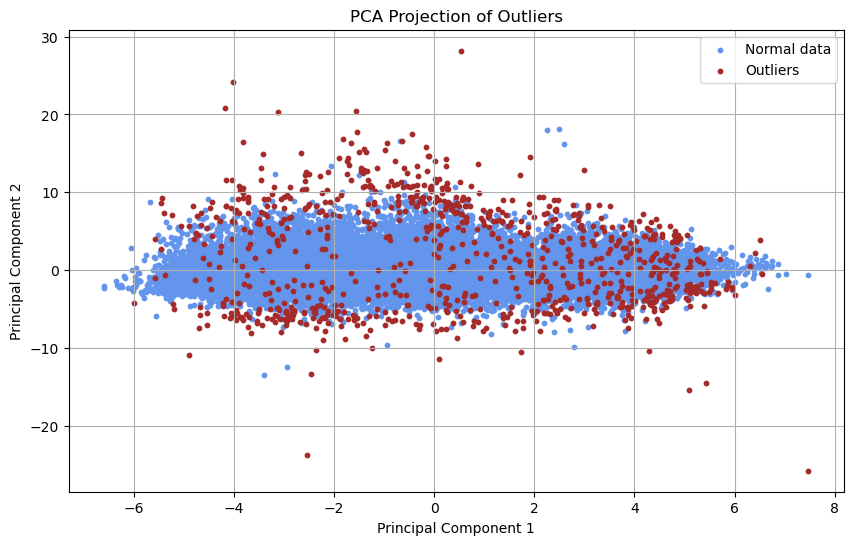

Size of data set after handling outliers: (33623, 45)


In [46]:
data_clean = outlier_handling_and_visualization(data_clean, 'violate','default',[])

In [ ]:
data_clean['violate'].mean()

0.13321238437974006

Size of data set: (25430, 45)


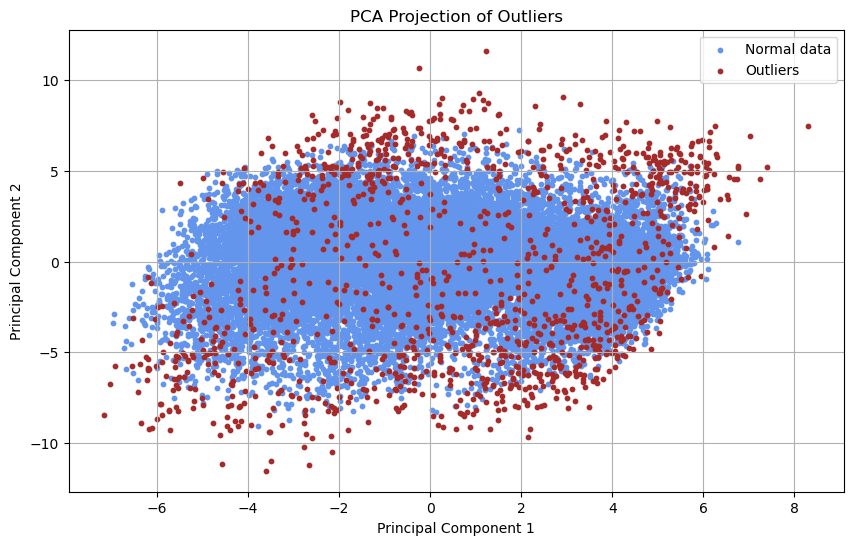

Size of data set after handling outliers: (24126, 45)
Size of data set: (24126, 45)


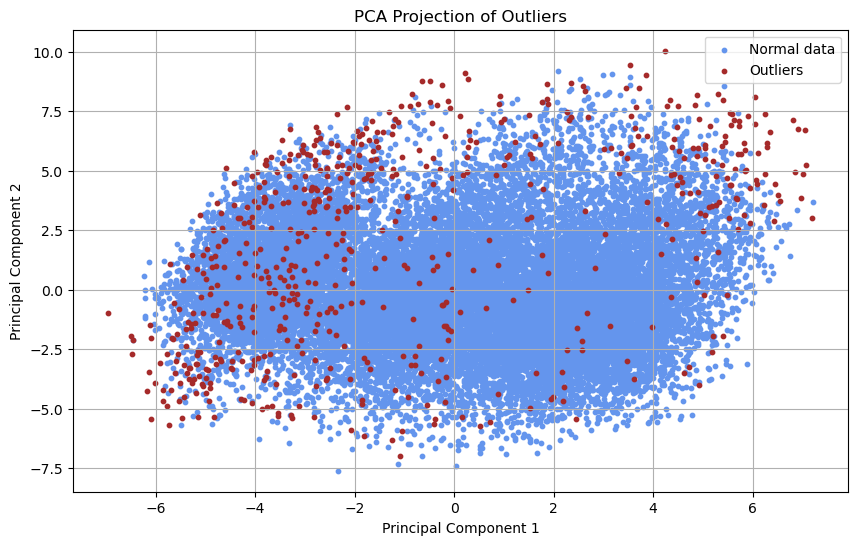

Size of data set after handling outliers: (23507, 45)
Size of data set: (23507, 45)


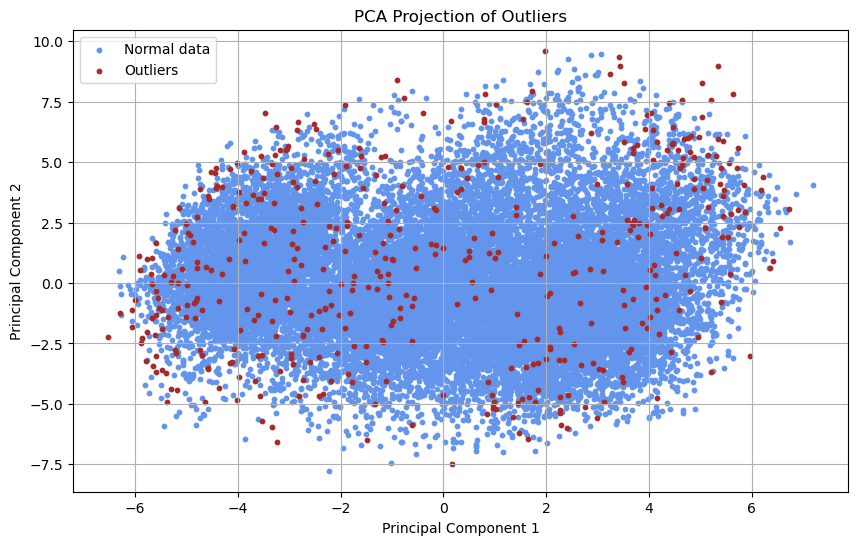

Size of data set after handling outliers: (23047, 45)
Size of data set: (23047, 45)


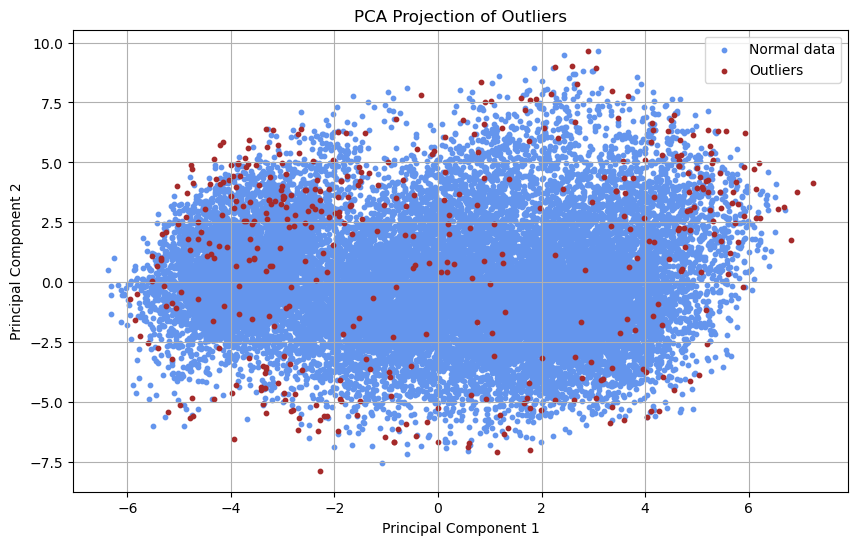

Size of data set after handling outliers: (22614, 45)


In [ ]:
for i in range(4):
    data_clean = outlier_handling_and_visualization(data_clean, 'violate',f'default_{i}',[])

In [ ]:
analyze_dataset(data_clean,['证监会新','Prov','year'],'default')

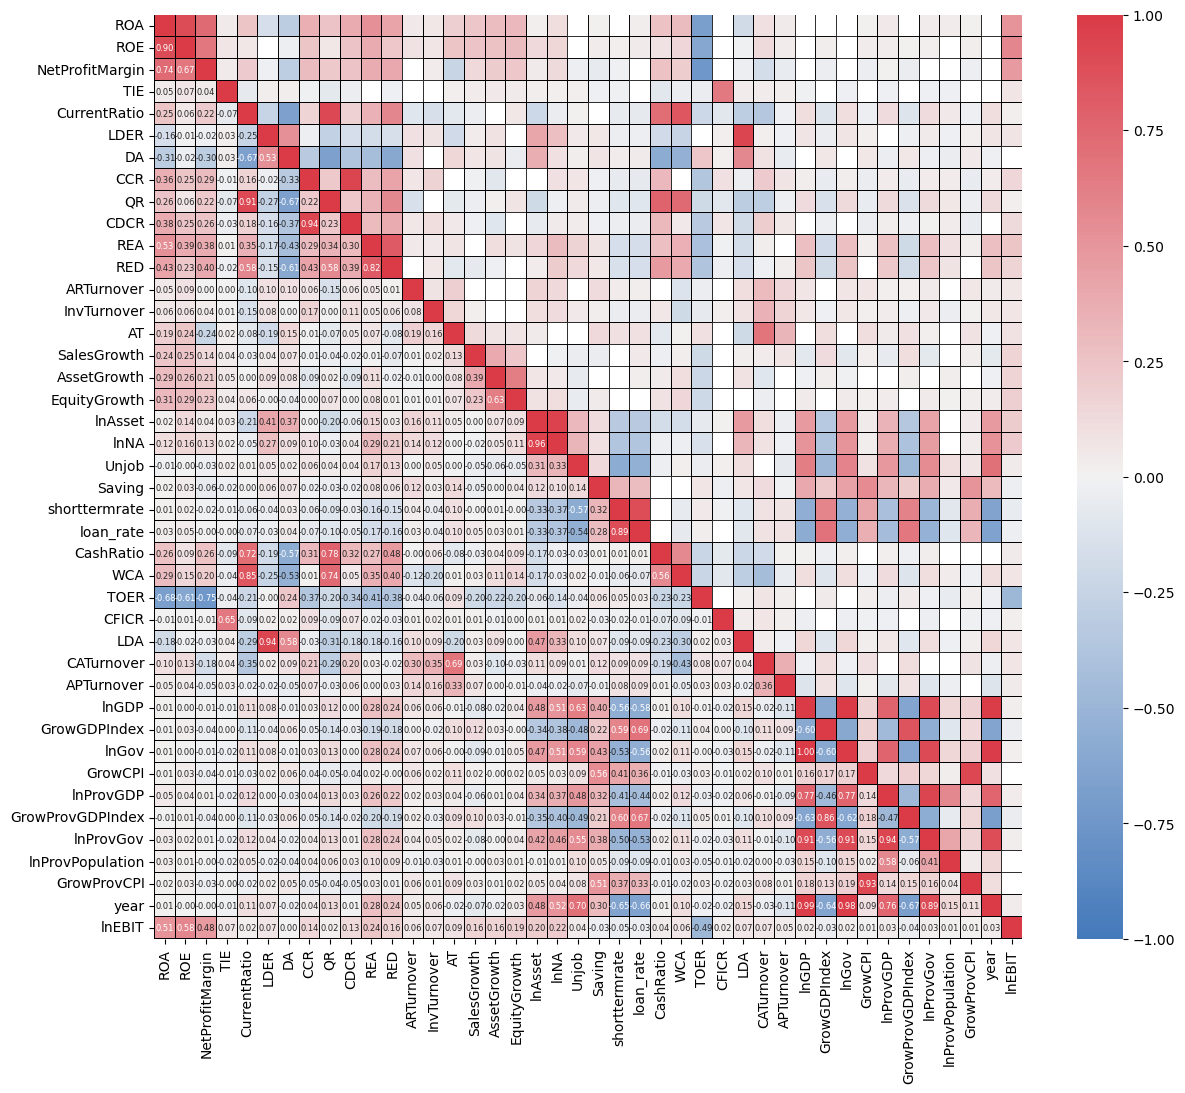

In [ ]:
corr_analysis(data_clean,'violate','default',(14,12))

Selected features: [13 23 20 22 34 36 21 31 32 33 40  5 39 38 35 37 28 19 18 26  6  4  8 14
 29 30  1 15  0 24 25  2 10 16 17 27  7 11 12  9  3 41]
Selected feature names: ['InvTurnover', 'loan_rate', 'Unjob', 'shorttermrate', 'GrowCPI', 'GrowProvGDPIndex', 'Saving', 'lnGDP', 'GrowGDPIndex', 'lnGov', 'year', 'LDER', 'GrowProvCPI', 'lnProvPopulation', 'lnProvGDP', 'lnProvGov', 'LDA', 'lnNA', 'lnAsset', 'TOER', 'DA', 'CurrentRatio', 'QR', 'AT', 'CATurnover', 'APTurnover', 'ROE', 'SalesGrowth', 'ROA', 'CashRatio', 'WCA', 'NetProfitMargin', 'REA', 'AssetGrowth', 'EquityGrowth', 'CFICR', 'CCR', 'RED', 'ARTurnover', 'CDCR', 'TIE', 'lnEBIT']
Objective function value: [  0.5661828   -2.74995418  -2.67189915  -2.88557371  -3.29425695
  -3.43115334  -3.55978188  -3.68084871  -3.77164883  -3.84227115
  -3.898769    -4.06465233  -4.63799086  -5.16369367  -5.44169827
  -5.66593523  -5.83963229  -6.53584507  -6.97661939  -7.37440367
  -7.73224296  -8.05322906  -8.34475836  -8.61114419  -8.85510318
 

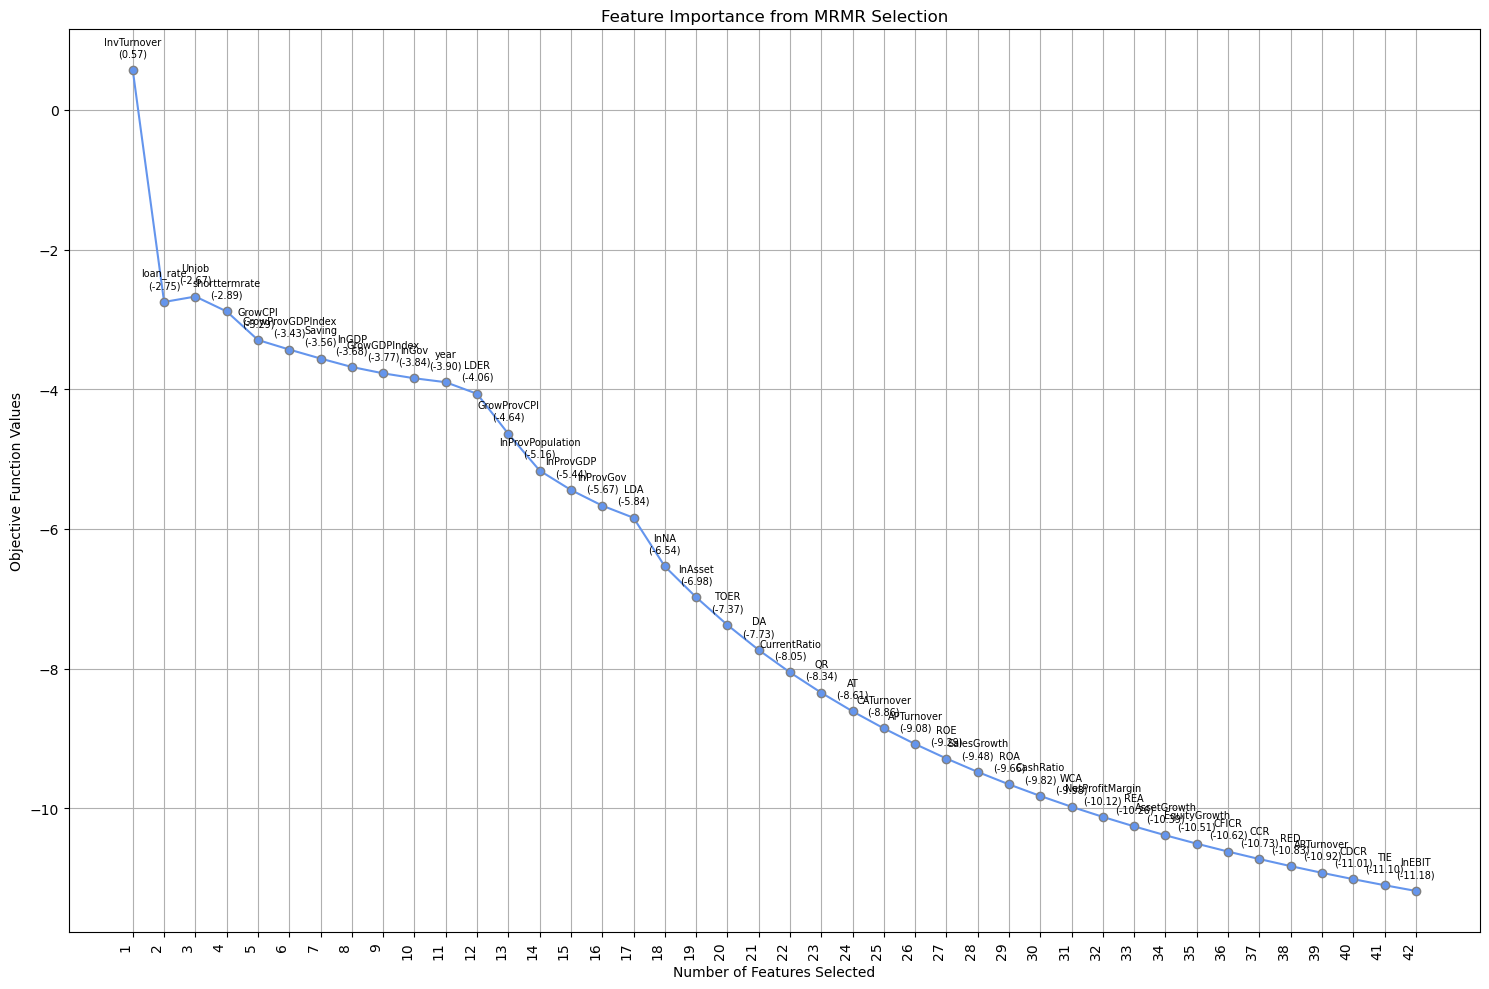

In [ ]:
selected_data, selected_add_data = fea_sel_mrmr(data_set = data_clean, 
                                                name_of_y = 'violate', 
                                                n = None,name_of_dataset='default')

wcss: [1215753.6437768524, 1125399.298250273, 1054334.4795160266, 1012863.2427705205, 971588.32367263, 942283.2910292184, 912826.8723255044, 891271.4053495926, 863338.2744983451, 855198.5257886159, 826974.2247962694, 813893.0306057236, 796210.6995598109]
silhouette_coefficients: [0.170317953208743, 0.15989150026704796, 0.15688897780158254, 0.15689475262781655, 0.15711448945271858, 0.13276579416041623, 0.12677175457634668, 0.11451534820326512, 0.12549014914068865, 0.0961088031679423, 0.09660804780135396, 0.10081369731727961, 0.10012856575111338]


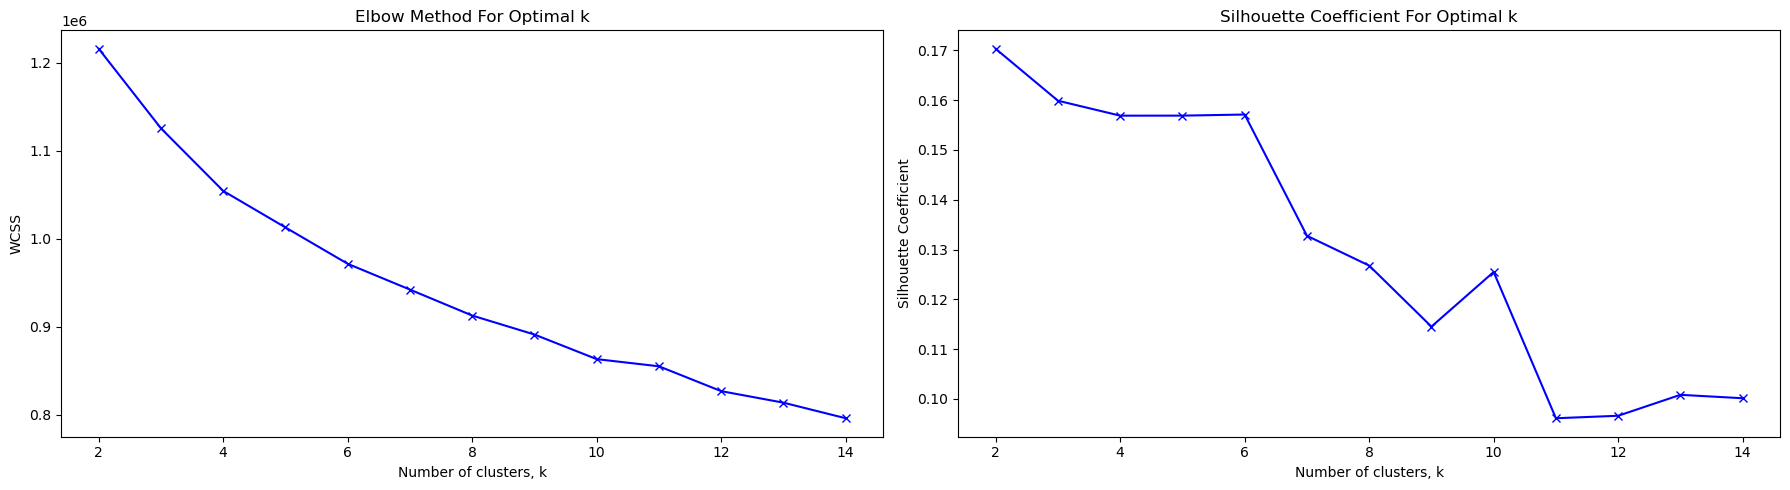

In [ ]:
wcss = elbow_fig(data_clean,'violate','default')

BSS: 440437.6329465595
Pseudo F: 3047.8324092650037


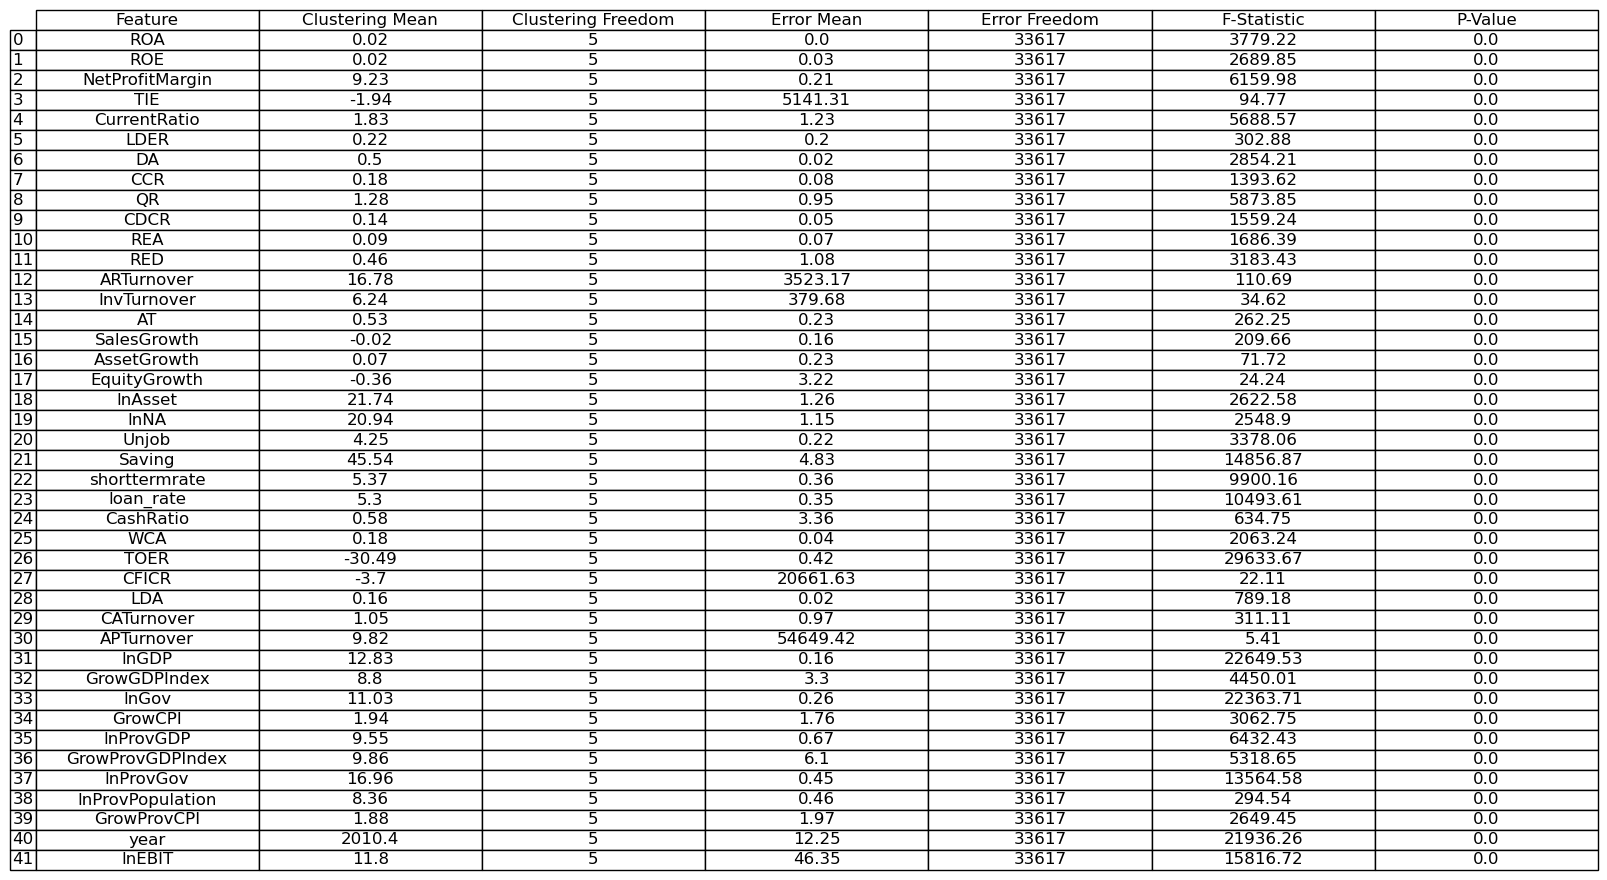

3047.8324092650037

In [ ]:
kmeans_cluster(data_clean,'violate','default',6,wcss)

categorical features: ['证监会新', 'Prov', 'year']
na value: 0.0
X(categorical) is label encoded.
X type is:  证监会新                  int32
ROA                 float64
ROE                 float64
NetProfitMargin     float64
TIE                 float64
CurrentRatio        float64
LDER                float64
DA                  float64
CCR                 float64
QR                  float64
CDCR                float64
REA                 float64
RED                 float64
ARTurnover          float64
InvTurnover         float64
AT                  float64
SalesGrowth         float64
AssetGrowth         float64
EquityGrowth        float64
lnAsset             float64
lnNA                float64
Unjob               float64
Saving              float64
shorttermrate       float64
loan_rate           float64
Prov                  int32
CashRatio           float64
WCA                 float64
TOER                float64
CFICR               float64
LDA                 float64
CATurnover          float6

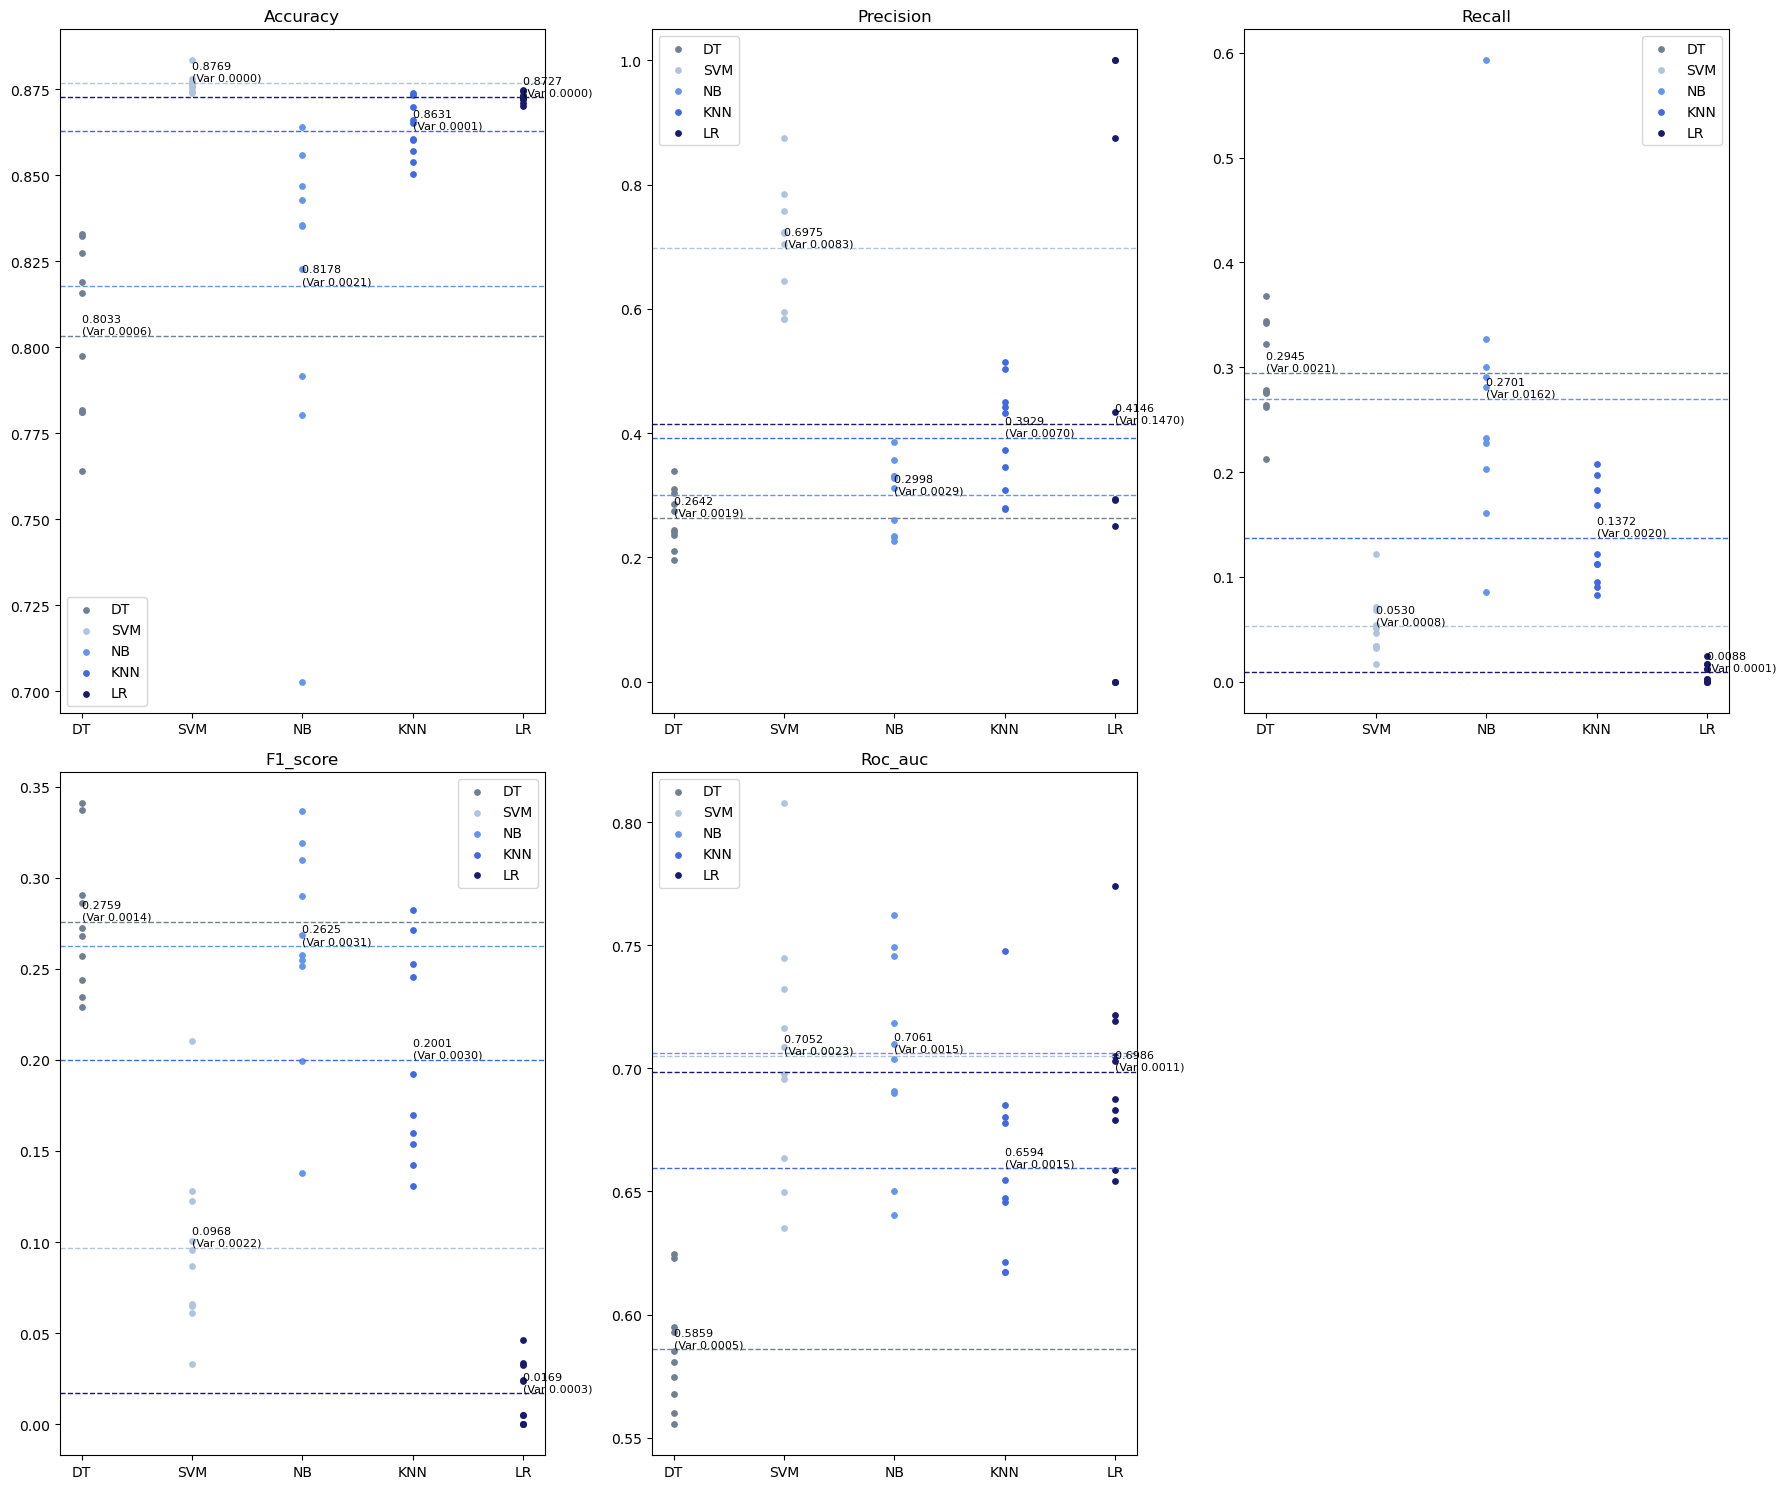

Bagging: Starting cross-validation...
Evaluating model: Bag_DT
Evaluating model: Bag_KNN
Evaluating model: Bag_SVM
Evaluating model: RF
Bagging result saved.
28
The number of models is 4.


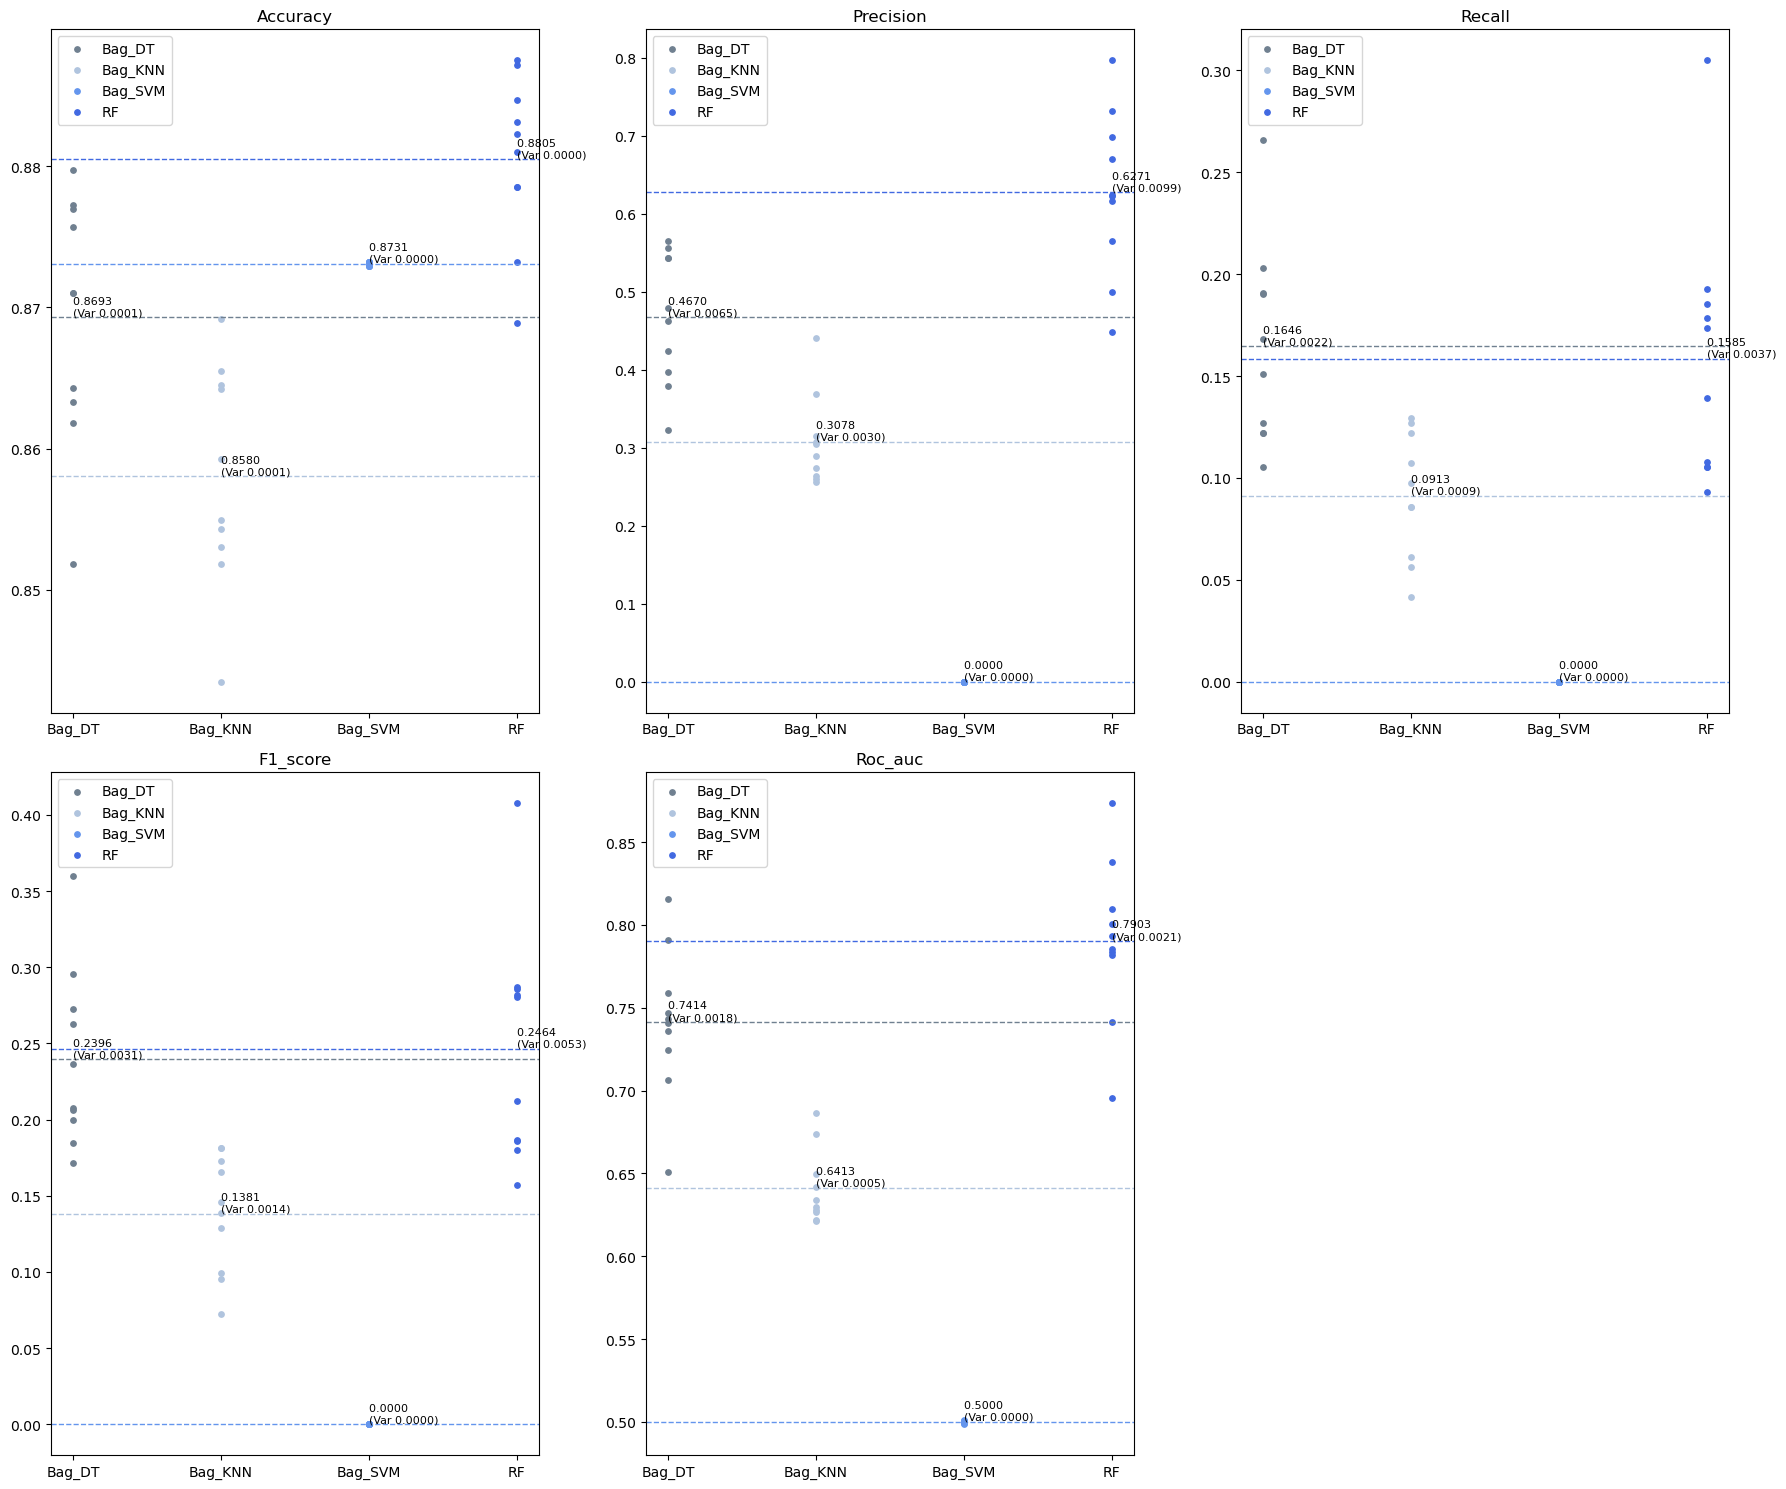

Evaluating model: AdaBoost...
Evaluating model: XGBoost...
Evaluating model: LightGBM...
Boosting result saved.
21
The number of models is 3.


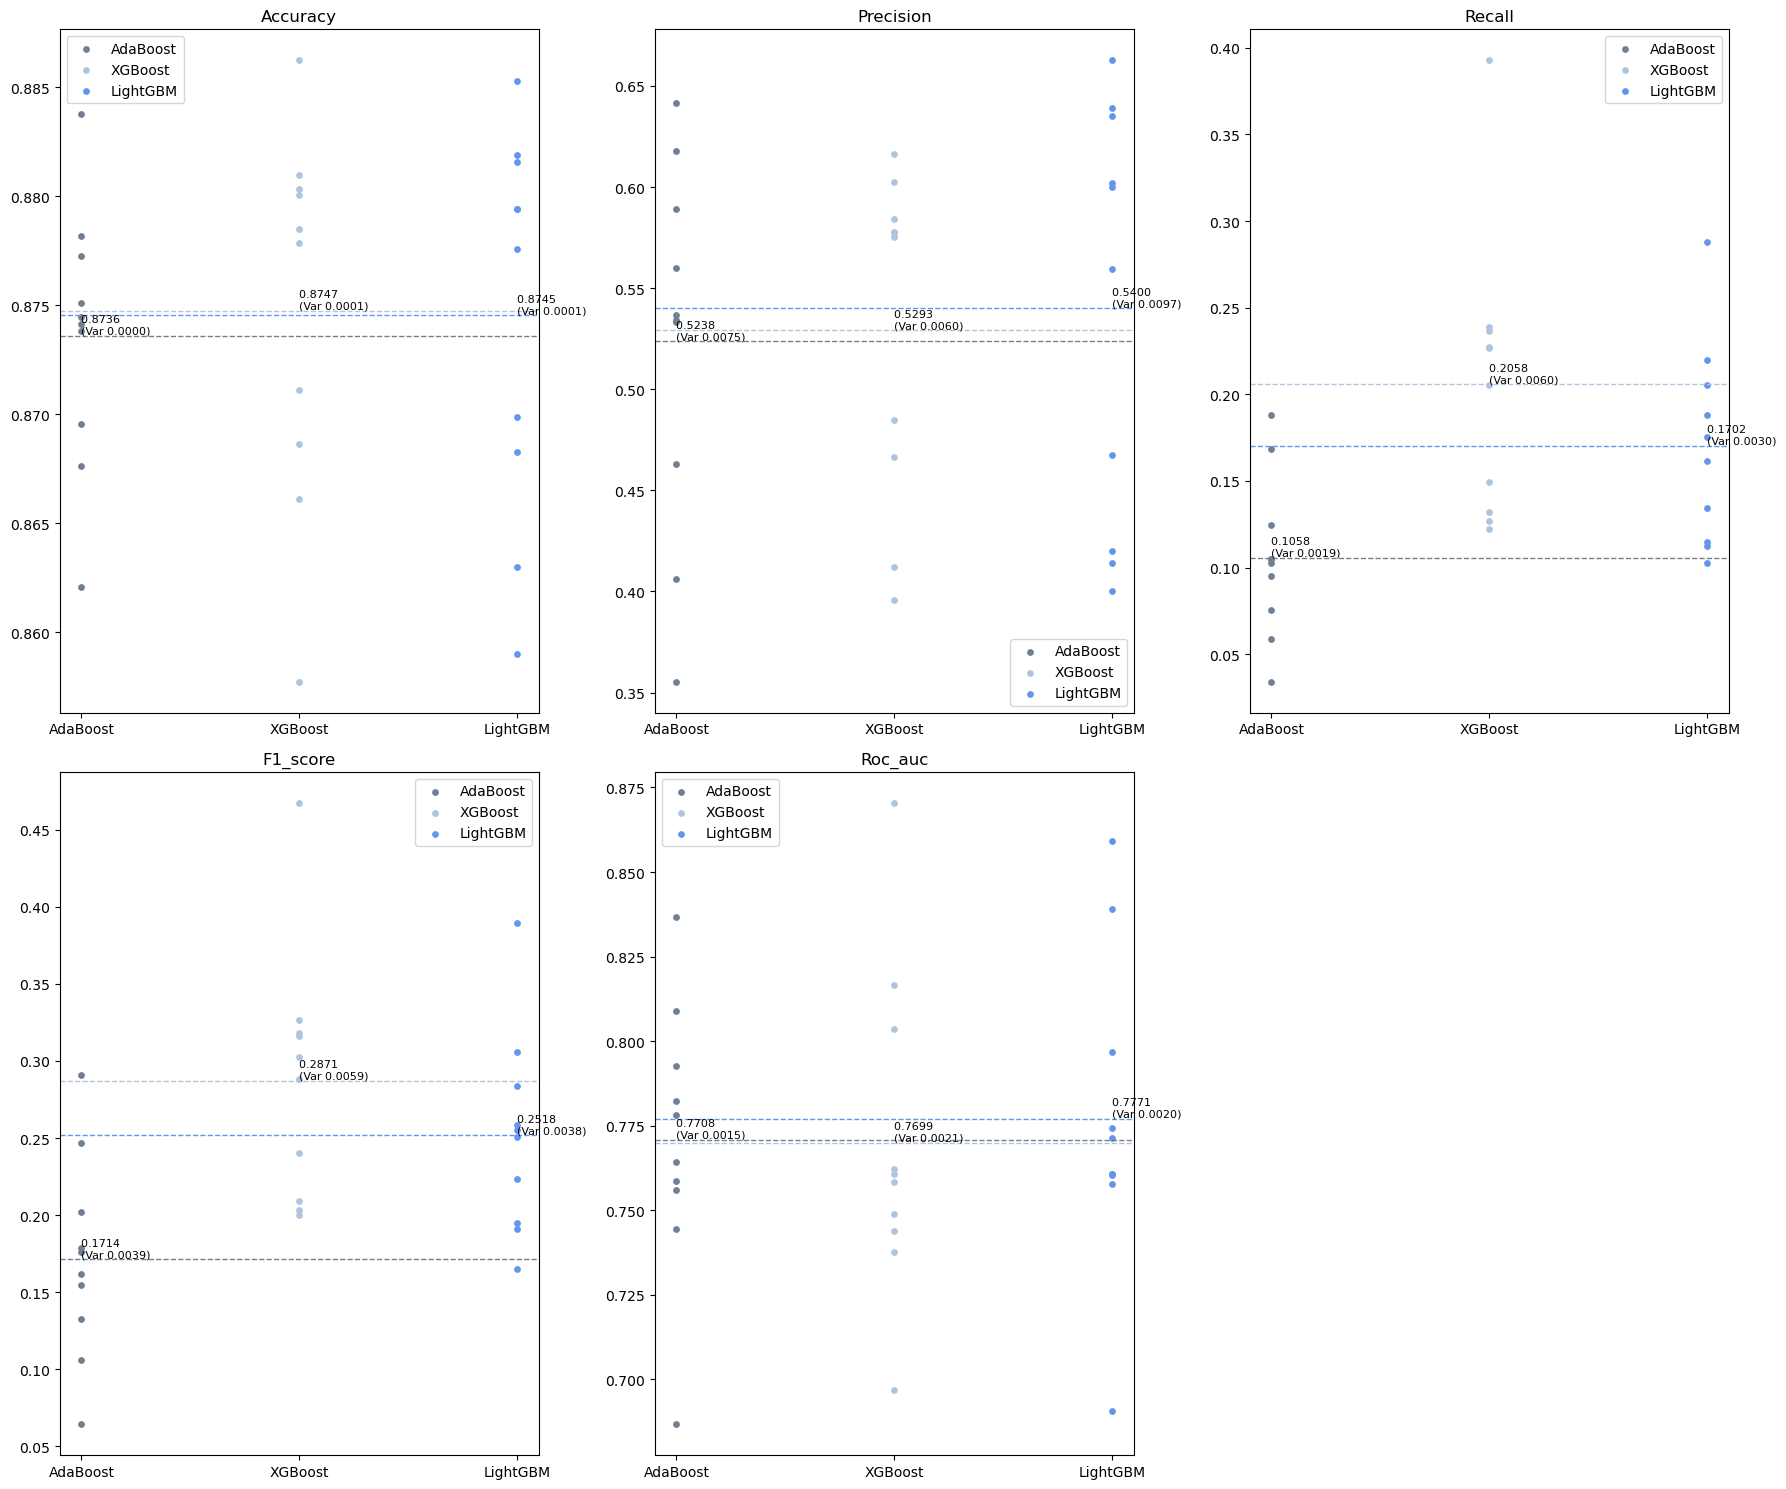

Evaluating model: stacking_0345...
Evaluating model: stacking_0145...
Evaluating model: stacking_1245...
Stacking result saved.
21
The number of models is 3.


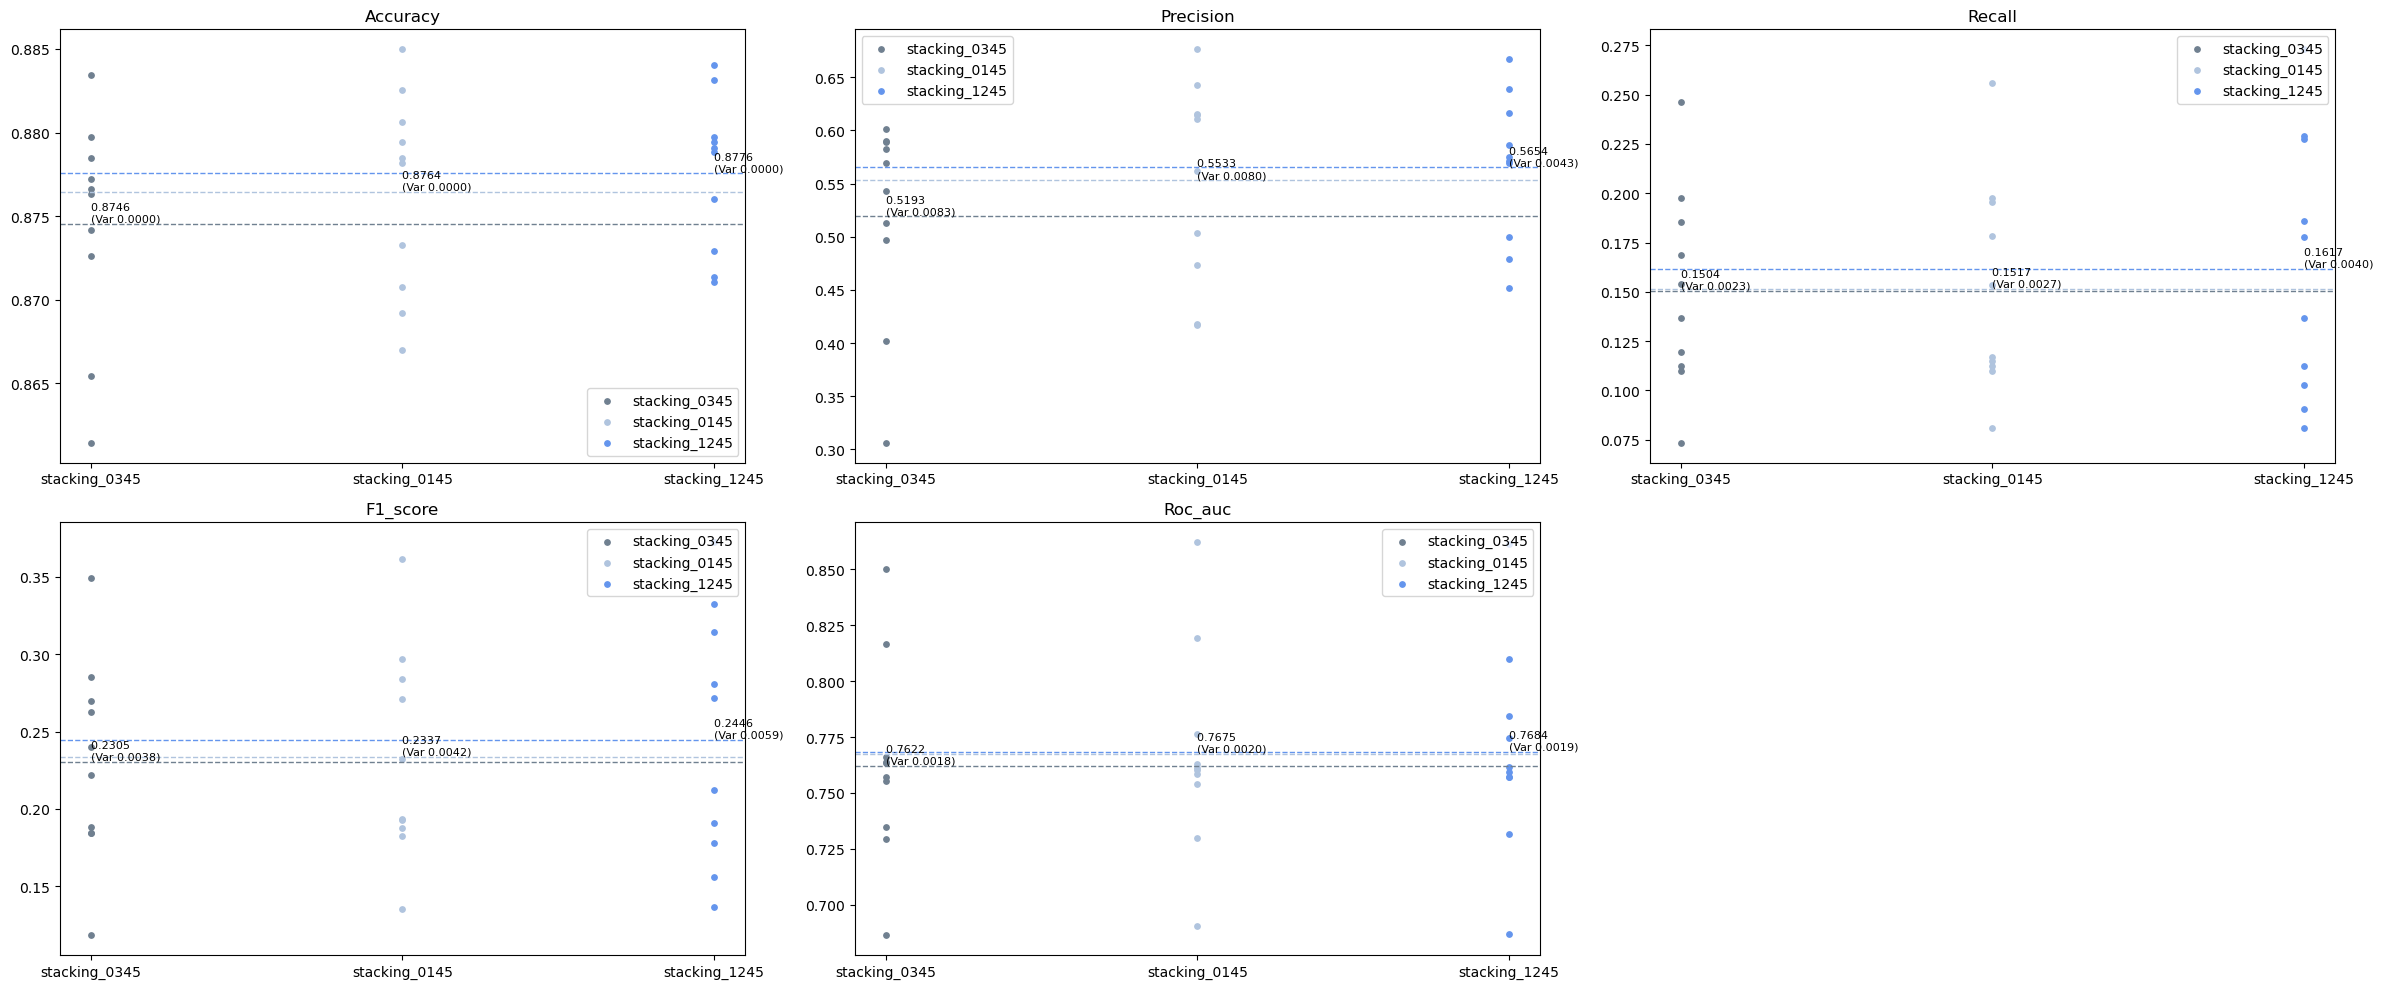

Evaluating 1-th best GA-Stacking model...
Loading the previous results...
The 1-th generation start to crossover and mutate...
Fitness of this round:  [0.8691804718871986, 0.8701919962475082, 0.8699070692555928, 0.8629502311274428, 0.8713941209677424, 0.8736775392143088, 0.8754303168270583, 0.8708545707882202, 0.8708709964595668, 0.869034362351848, 0.872067020813803, 0.8683498655550621, 0.8662633818593962, 0.873333979002141, 0.8694993766512888]
Best score in this round: 0.8754303168270583
----- And it's accuracy: 0.879393713966896
Best individual for now: [1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1]
The 2-th generation start to crossover and mutate...
Fitness of this round:  [0.8754303168270583, 0.8629502311274428, 0.8708545707882202, 0.8736775392143088, 0.8701919962475082, 0.8708709964595668, 0.872067020813803, 0.8713941209677424, 0.8662633818593962, 0.8683498655550621, 0.869034362351848, 

In [ ]:
results_bagging,results_boosting,basic_results,stacking_results,ga_stacking_result,all_results = prediction_save(data_set=data_clean,name_of_y='violate',name_of_dataset='default',
                    categorical_features=['证监会新', 'Prov', 'year'],cv_n=10,multi_class=False,n_best_ga = 3,
                    initial_n=15, n_round=20,cv_n_find_best_ga=3,
                    cross_rate=0.8, mutation_rate=0.2,
                    selection_method='roulette',penalty_multiplier=5,
                    cv_n_eva_best_ga=10,
                    only_ga=True)


In [ ]:
results_bagging,results_boosting,basic_results,stacking_results,ga_stacking_result,all_results = prediction_save(data_set=data_clean,name_of_y='violate',name_of_dataset='default',
                    categorical_features=['证监会新', 'Prov', 'year'],cv_n=10,multi_class=False,n_best_ga = 3,
                    initial_n=15, n_round=20,cv_n_find_best_ga=4,
                    cross_rate=0.8, mutation_rate=0.2,
                    selection_method='roulette',penalty_multiplier=5,
                    cv_n_eva_best_ga=10,
                    only_ga=True,if_extend=True)

categorical features: ['证监会新', 'Prov', 'year']
na value: 0.0
X(categorical) is label encoded.
X type is:  证监会新                  int32
ROA                 float64
ROE                 float64
NetProfitMargin     float64
TIE                 float64
CurrentRatio        float64
LDER                float64
DA                  float64
CCR                 float64
QR                  float64
CDCR                float64
REA                 float64
RED                 float64
ARTurnover          float64
InvTurnover         float64
AT                  float64
SalesGrowth         float64
AssetGrowth         float64
EquityGrowth        float64
lnAsset             float64
lnNA                float64
Unjob               float64
Saving              float64
shorttermrate       float64
loan_rate           float64
Prov                  int32
CashRatio           float64
WCA                 float64
TOER                float64
CFICR               float64
LDA                 float64
CATurnover          float6

C:\Users\Matebook\AppData\Local\Temp\ipykernel_23184\3552730839.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_set[categorical_features]=data_set[categorical_features].astype('category')
C:\Users\Matebook\AppData\Local\Temp\ipykernel_23184\3552730839.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_set[col] = label_encoder.fit_transform(data_set[col])
C:\Users\Matebook\AppData\Local\Temp\ipykernel_23184\3552730839.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

Fitness of this round:  [0.8489892352165228, 0.8497323946183605, 0.8655667553652382, 0.8519449936656228, 0.8503752500244227, 0.8626545567102737, 0.838718488056362, 0.8381032769796215, 0.8571812102421776, 0.770065886356398, 0.8523945565598777, 0.8382805138575224, 0.8544975649062742, 0.784329548276549, 0.8599860843073135]
Best score in this round: 0.8655667553652382
----- And it's accuracy: 0.8716651783951379
Best individual for now: [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
The 2-th generation start to crossover and mutate...
Fitness of this round:  [0.8655667553652382, 0.8497323946183605, 0.8523945565598777, 0.8503752500244227, 0.838718488056362, 0.8381032769796215, 0.8571812102421776, 0.770065886356398, 0.8626545567102737

In [ ]:
data_set=data_clean
name_of_y='violate'
name_of_dataset='default'
categorical_features=['证监会新', 'Prov', 'year']
cv_n=10
multi_class=False
imb_con=0.05

#####
ga_1= [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0]
ga_2= [0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1]
ga_3= [1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1]
ga_4= [0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1]
ga_5= [1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1]


####


y_counts = data_set[name_of_y].value_counts()
data_name=name_of_dataset
if multi_class:
    n_y=data_set[name_of_y].nunique()
    scoring = {
        'accuracy': make_scorer(accuracy_score),
        'precision': make_scorer(precision_score, average='weighted'),
        'recall': make_scorer(recall_score, average='weighted'),
        'f1_score': make_scorer(f1_score, average='weighted'),
        'roc_auc': make_scorer(roc_auc_score, needs_proba=True, multi_class='ovo')  # 'ovo' | 'ovr'
        }
else:
    n_y = None
    scoring = {'accuracy': make_scorer(accuracy_score),
        'precision': make_scorer(precision_score),
        'recall': make_scorer(recall_score),
        'f1_score': make_scorer(f1_score),
        'roc_auc': make_scorer(roc_auc_score, needs_proba=True)}


if categorical_features!=[]:
    print("categorical features:",categorical_features)
    data_set[categorical_features]=data_set[categorical_features].astype('category')
print('na value:',data_set.isna().sum().mean())
X=data_set.drop(name_of_y,axis=1)
y=data_set[name_of_y]
if categorical_features!=[]:
    label_encoder = LabelEncoder()
    for col in categorical_features:
        data_set[col] = label_encoder.fit_transform(data_set[col])
    X_encoded = data_set.drop(name_of_y, axis=1)
    y_encoded = y
    print('X(categorical) is label encoded.')
else:
    X_encoded=X
    y_encoded=y

if multi_class:
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y_encoded)
    y=label_encoder.fit_transform(y)

imbalance = y_counts.min()/data_set[name_of_y].count()<imb_con or y_counts.min()<cv_n
ga_stacking_result={}
scores = eval_best_GA_v2(X=X_encoded, y=y_encoded, ga_model=ga_1, cv_n=10, imbalance=imbalance, multi_class=multi_class, n_y=n_y)
ga_stacking_result['GA-S_1'] = scores
print('Done.')
scores = eval_best_GA_v2(X=X_encoded, y=y_encoded, ga_model=ga_2, cv_n=10, imbalance=imbalance, multi_class=multi_class, n_y=n_y)
ga_stacking_result['GA-S_2'] = scores
print('Done.')
scores = eval_best_GA_v2(X=X_encoded, y=y_encoded, ga_model=ga_3, cv_n=10, imbalance=imbalance, multi_class=multi_class, n_y=n_y)
ga_stacking_result['GA-S_3'] = scores
print('Done.')
scores = eval_best_GA_v2(X=X_encoded, y=y_encoded, ga_model=ga_4, cv_n=10, imbalance=imbalance, multi_class=multi_class, n_y=n_y)
ga_stacking_result['GA-S_4'] = scores
print('Done.')
scores = eval_best_GA_v2(X=X_encoded, y=y_encoded, ga_model=ga_5, cv_n=10, imbalance=imbalance, multi_class=multi_class, n_y=n_y)
ga_stacking_result['GA-S_5'] = scores
print('Done.')

df_results_ga_stacking = pd.DataFrame(ga_stacking_result)
df_results_ga_stacking = convert_lists_to_json(df_results_ga_stacking)
df_results_ga_stacking.to_csv(f'default_selected_ga.csv', index=True)

categorical features: ['证监会新', 'Prov', 'year']
na value: 0.0
X(categorical) is label encoded.


C:\Users\Matebook\AppData\Local\Temp\ipykernel_13200\338740268.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_set[categorical_features]=data_set[categorical_features].astype('category')
C:\Users\Matebook\AppData\Local\Temp\ipykernel_13200\338740268.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_set[col] = label_encoder.fit_transform(data_set[col])
C:\Users\Matebook\AppData\Local\Temp\ipykernel_13200\338740268.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

Done.
Done.
Done.
Done.
Done.


In [ ]:
import platform
import os

def play_sound():
    system = platform.system()
    if system == "Windows":
        import winsound
        winsound.Beep(1000, 1000)
    elif system == "Linux" or system == "Darwin":
        os.system("play -nq -t alsa synth {} sine {}".format(1, 1000))

play_sound()

In [ ]:
def roc_draw(X, y, ga_model:list, imbalance=False, multi_class=False, n_y=None,name_of_dataset=None):
    from sklearn.metrics import roc_curve, auc
    
    # 划分训练集和测试集
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    base_models, meta_models = models_pools_v2(imbalance = imbalance, multi_class = multi_class, n_y = n_y)
    decoded_base, decoded_meta = decode_individual_v2(ga_model, base_models, meta_models,imbalance=imbalance,multi_class=multi_class)
    decoded_base = list(decoded_base.items())  # Convert the dictionary to a list
    decoded_meta = list(decoded_meta.values())[0]
    stack_model = StackingClassifier(estimators=decoded_base, final_estimator=decoded_meta)
    stack_model.fit(X_train, y_train)

    # 预测概率
    y_prob = stack_model.predict_proba(X_test)[:, 1]

    # 计算ROC指标
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    # 绘制ROC曲线
    plt.figure()
    plt.plot(fpr, tpr, color='brown', lw=2, label='ROC curve (area = %0.4f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='royalblue', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")


    # save as pdf 
    file_name = f"{name_of_dataset}_roc_fig.pdf"
    plt.savefig(file_name,format='pdf')

    plt.show()

In [51]:
def roc_draw(X, y, ga_models:list, imbalance=False, multi_class=False, n_y=None, name_of_dataset=None):
    from sklearn.metrics import roc_curve, auc
    import matplotlib.pyplot as plt
    from sklearn.model_selection import train_test_split
    from sklearn.ensemble import StackingClassifier
    print('Begin')
    # 划分训练集和测试集
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    plt.figure()

    for idx, ga_model in enumerate(ga_models):
        
        base_models, meta_models = models_pools_v2(imbalance=imbalance, multi_class=multi_class, n_y=n_y)
        decoded_base, decoded_meta = decode_individual_v2(ga_model, base_models, meta_models, imbalance=imbalance, multi_class=multi_class)
        decoded_base = list(decoded_base.items())  # Convert the dictionary to a list
        decoded_meta = list(decoded_meta.values())[0]
        stack_model = StackingClassifier(estimators=decoded_base, final_estimator=decoded_meta)
        stack_model.fit(X_train, y_train)

        # 预测概率
        y_prob = stack_model.predict_proba(X_test)[:, 1]

        # 计算ROC指标
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)

        # 选择颜色
        color = 'brown' if idx == 0 else 'royalblue'
        print('Done')

        # 绘制ROC曲线
        plt.plot(fpr, tpr, color=color, lw=2, label=f'Model {idx + 1} (area = {roc_auc:.4f})')

    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")

    # save as pdf
    file_name = f"{name_of_dataset}_roc_fig.pdf"
    plt.savefig(file_name, format='pdf')

    plt.show()


In [ ]:
def plot_dataset_growth(file_name, name_of_dataset):

    df = pd.read_csv(f"{file_name}.csv")
    

    rounds = df['Round']
    best_score = df['Best Score']
    best_accuracy = df['Best Accuracy']
    
    # 创建图形
    plt.figure(figsize=(10, 6))
    
    # 绘制折线图
    plt.plot(rounds, best_score, label='Best Score', color='royalblue', marker='o', linestyle='-', markersize=3)
    plt.plot(rounds, best_accuracy, label='Best Accuracy', color='brown', marker='o', linestyle='-', markersize=3)
    
    # 添加图例
    plt.legend(loc='best')
    
    # 设置标题和坐标轴标签
    plt.title('Generation Growth')
    plt.xlabel('Round')
    plt.ylabel('Scores')
    
    # 保存图形为PDF
    plt.savefig(f"{name_of_dataset}_generation_growth.pdf")
    
    # 显示图形
    plt.show()

In [ ]:

def read_csv_and_convert_to_nested_dict(file_name):
    """
    从CSV文件读取数据，并将其转换成嵌套字典，外层字典的键为模型名称，内层字典的键为指标名称，值为数值数组。
    
    参数:
    file_name (str): CSV文件的路径。
    
    返回:
    dict: 转换后的嵌套字典，外层键为模型名，内层键为指标名，值为数组。
    """
    # 读取CSV文件到DataFrame
    df = pd.read_csv(f'{file_name}.csv', index_col=0)
    
    # 初始化最终的嵌套字典
    results = {}

    # 遍历DataFrame的列，每列代表一个模型
    for model in df.columns:
        # 确保外层字典中存在模型键
        if model not in results:
            results[model] = {}
        
        # 遍历每行，每行代表一个指标
        for metric in df.index:
            # 将字符串形式的列表转换为数值数组
            results[model][metric] = json.loads(df.at[metric, model])

    return results

#### 总的图

154
The number of models is 22.


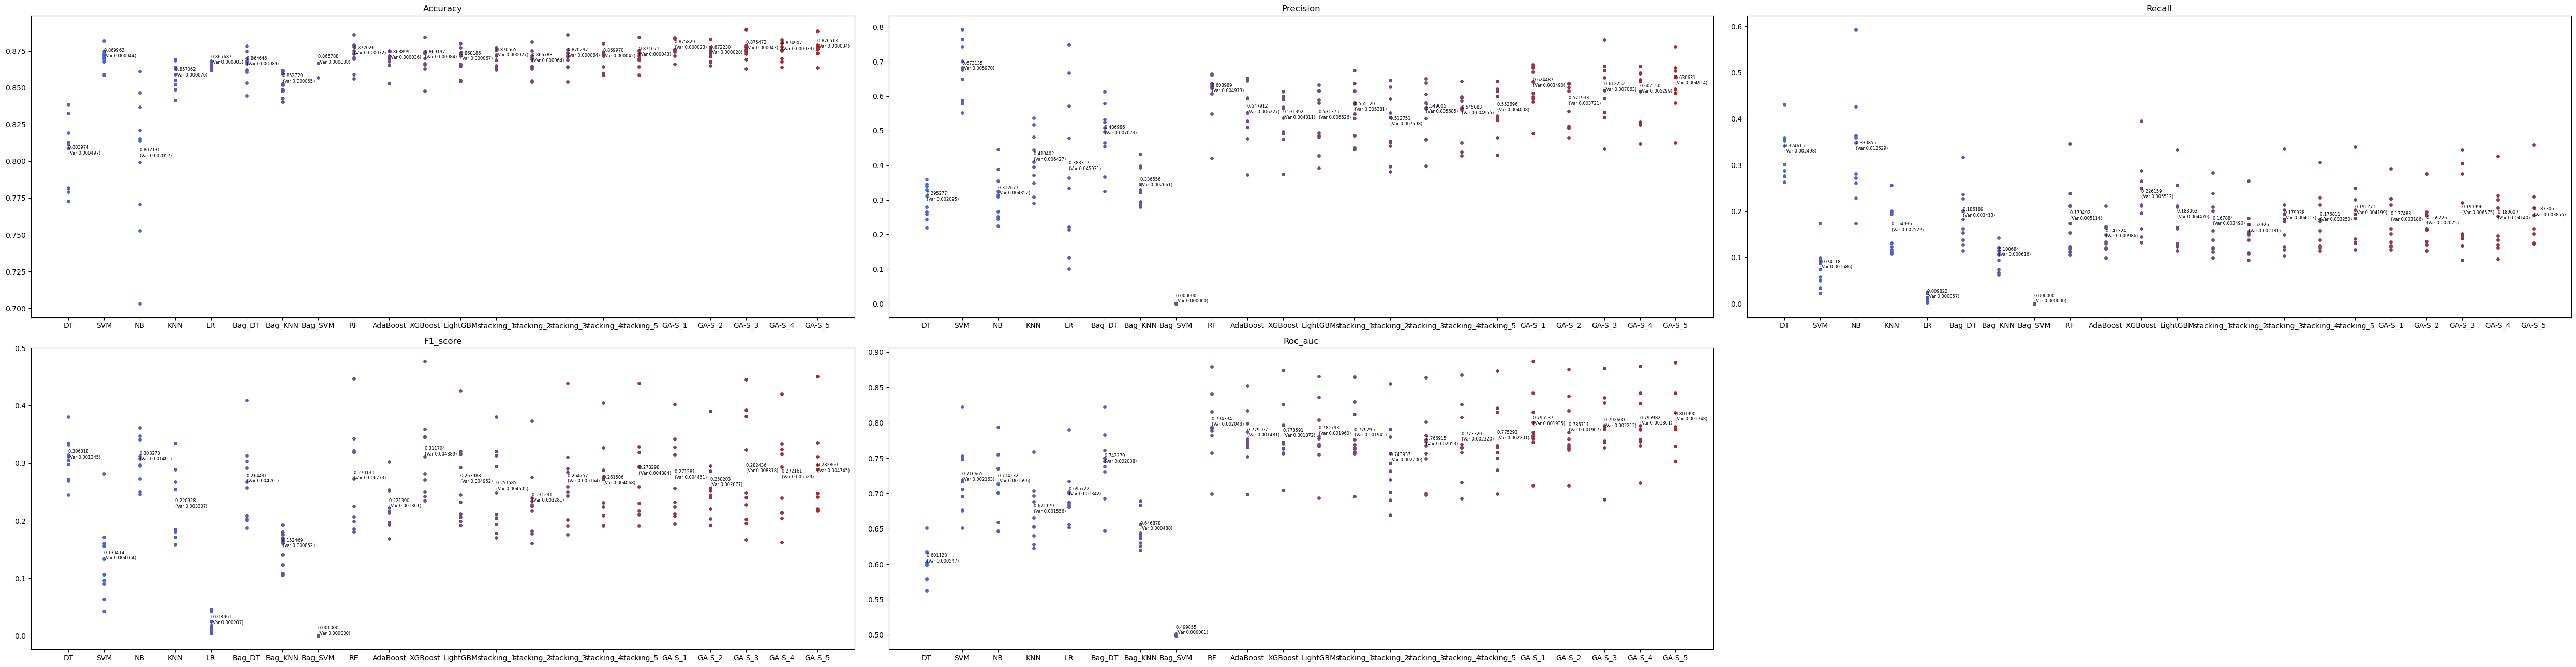

In [ ]:
all = read_csv_and_convert_to_nested_dict('all')
draw_results(all,"default","all",fig_size=(50,13),fontsize=6,not_many_colors=False,if_legend=False)

#### 进化图

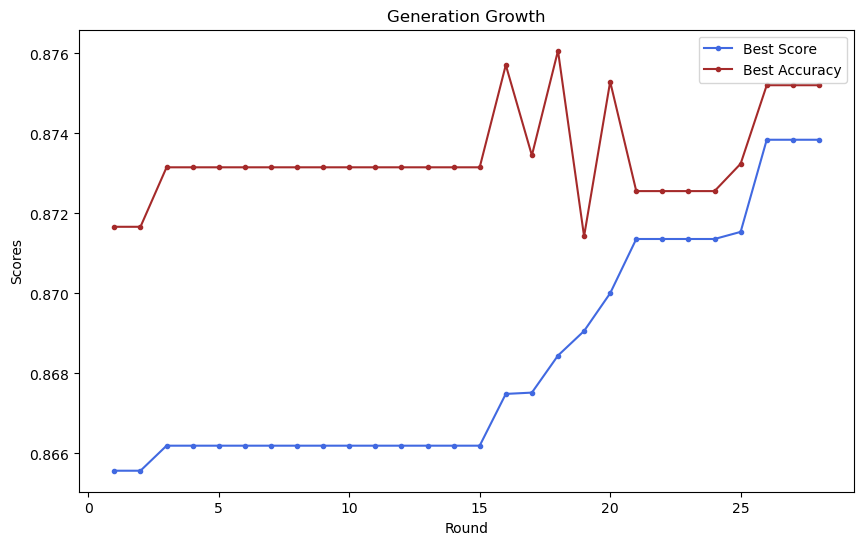

In [ ]:
plot_dataset_growth('growth','default')

#### ROC

categorical features: ['证监会新', 'Prov', 'year']
na value: 0.0
X(categorical) is label encoded.
Begin


C:\Users\Matebook\AppData\Local\Temp\ipykernel_5188\860870058.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_set[categorical_features]=data_set[categorical_features].astype('category')
C:\Users\Matebook\AppData\Local\Temp\ipykernel_5188\860870058.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_set[col] = label_encoder.fit_transform(data_set[col])
C:\Users\Matebook\AppData\Local\Temp\ipykernel_5188\860870058.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

[LightGBM] [Warning] Unknown parameter: classifier__max_depth
[LightGBM] [Warning] Unknown parameter: classifier__learning_rate
[LightGBM] [Warning] Unknown parameter: classifier__boosting_type
[LightGBM] [Warning] Unknown parameter: classifier__feature_fraction
[LightGBM] [Warning] Unknown parameter: classifier__max_depth
[LightGBM] [Warning] Unknown parameter: classifier__learning_rate
[LightGBM] [Warning] Unknown parameter: classifier__boosting_type
[LightGBM] [Warning] Unknown parameter: classifier__feature_fraction
[LightGBM] [Info] Number of positive: 3085, number of negative: 20451
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000467 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1293
[LightGBM] [Info] Number of data points in the train set: 23536, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.131076 -> initscore=-1.891480
[LightGBM] [Info] Start training fro

d:\python\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
d:\python\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
d:\python\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
d:\python\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
d:\python\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
d:\python\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: classifier__max_depth
[LightGBM] [Warning] Unknown parameter: classifier__learning_rate
[LightGBM] [Warning] Unknown parameter: classifier__boosting_type
[LightGBM] [Warning] Unknown parameter: classifier__feature_fraction
[LightGBM] [Warning] Unknown parameter: classifier__max_depth
[LightGBM] [Warning] Unknown parameter: classifier__learning_rate
[LightGBM] [Warning] Unknown parameter: classifier__boosting_type
[LightGBM] [Warning] Unknown parameter: classifier__feature_fraction
[LightGBM] [Info] Number of positive: 3085, number of negative: 20451
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000357 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1440
[LightGBM] [Info] Number of data points in the train set: 23536, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.131076 -> initscore=-1.891480
[LightGBM] [Info] Start training fro

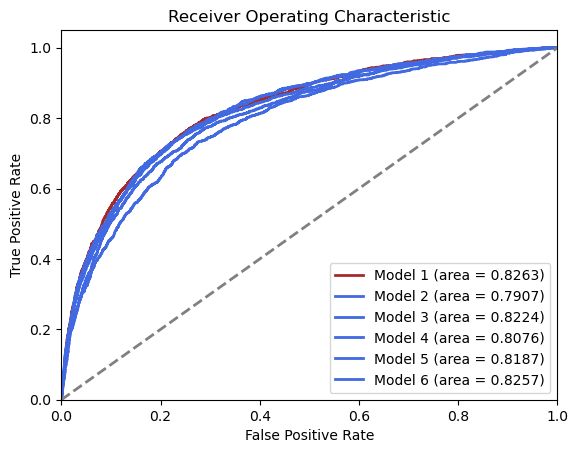

In [54]:
data_set=data_clean
name_of_y='violate'
name_of_dataset='default'
categorical_features=['证监会新', 'Prov', 'year']
cv_n=10
multi_class=False
imb_con=0.05

#####################
ga_model = [[1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1],
            [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
            [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0],
            [0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1],
            [1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1],
            [0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1]
            

]

# ga_1= [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0]
# ga_2= [0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1]
# ga_3= [1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1]
# ga_4= [0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1]
# ga_5= [1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1]

#####################


y_counts = data_set[name_of_y].value_counts()
data_name=name_of_dataset
if multi_class:
    n_y=data_set[name_of_y].nunique()
    scoring = {
        'accuracy': make_scorer(accuracy_score),
        'precision': make_scorer(precision_score, average='weighted'),
        'recall': make_scorer(recall_score, average='weighted'),
        'f1_score': make_scorer(f1_score, average='weighted'),
        'roc_auc': make_scorer(roc_auc_score, needs_proba=True, multi_class='ovo')  # 'ovo' | 'ovr'
        }
else:
    n_y = None
    scoring = {'accuracy': make_scorer(accuracy_score),
        'precision': make_scorer(precision_score),
        'recall': make_scorer(recall_score),
        'f1_score': make_scorer(f1_score),
        'roc_auc': make_scorer(roc_auc_score, needs_proba=True)}


if categorical_features!=[]:
    print("categorical features:",categorical_features)
    data_set[categorical_features]=data_set[categorical_features].astype('category')
print('na value:',data_set.isna().sum().mean())
X=data_set.drop(name_of_y,axis=1)
y=data_set[name_of_y]
if categorical_features!=[]:
    label_encoder = LabelEncoder()
    for col in categorical_features:
        data_set[col] = label_encoder.fit_transform(data_set[col])
    X_encoded = data_set.drop(name_of_y, axis=1)
    y_encoded = y
    print('X(categorical) is label encoded.')
else:
    X_encoded=X
    y_encoded=y

if multi_class:
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y_encoded)
    y=label_encoder.fit_transform(y)

imbalance = y_counts.min()/data_set[name_of_y].count()<imb_con or y_counts.min()<cv_n
roc_draw(X=X_encoded, y=y_encoded, ga_models=ga_model, imbalance=imbalance, multi_class=multi_class, n_y=n_y,name_of_dataset='default')

#### SHAP

categorical features: ['证监会新', 'Prov', 'year']
na value: 0.0
X(categorical) is label encoded.
The lenth of chromosome is not 47( (3+2+2)*6+(1+2+2)*1 )!



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

[14:57:37] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "classifier__learning_rate", "classifier__n_estimators" } are not used.



PermutationExplainer explainer: 6726it [3:59:19,  2.14s/it]                               


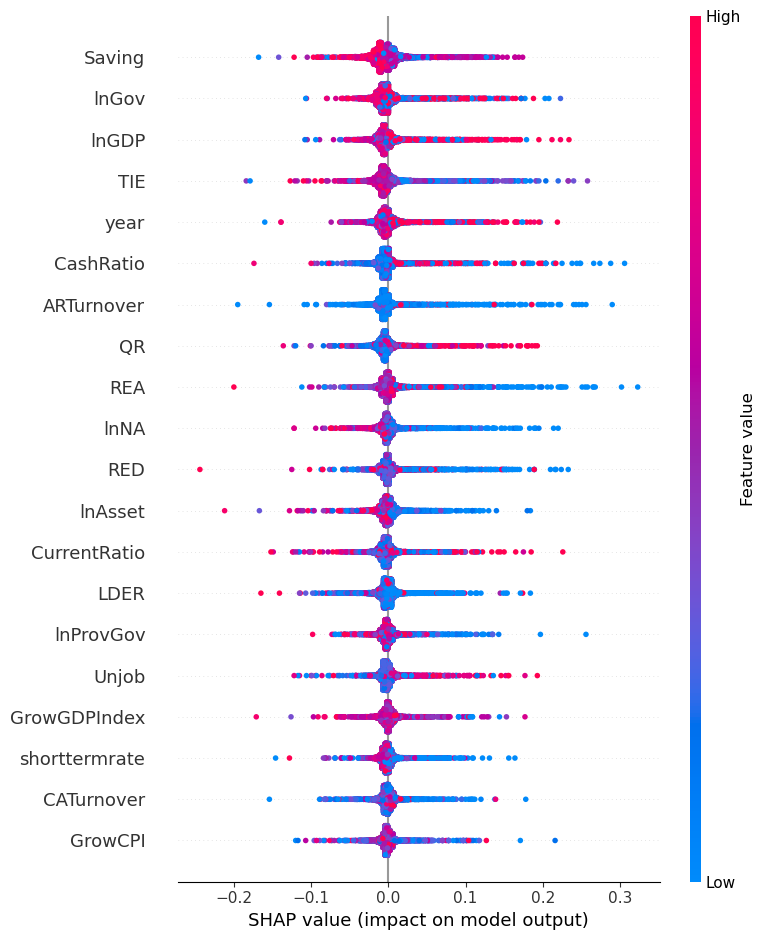

AttributeError: 'PermutationExplainer' object has no attribute 'expected_value'

In [ ]:
import shap
data_set=data_clean
name_of_y='violate'
name_of_dataset='default'
categorical_features=['证监会新', 'Prov', 'year']
cv_n=10
multi_class=False
imb_con=0.05
ga_model = [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0]


y_counts = data_set[name_of_y].value_counts()
data_name=name_of_dataset
if multi_class:
    n_y=data_set[name_of_y].nunique()
    scoring = {
        'accuracy': make_scorer(accuracy_score),
        'precision': make_scorer(precision_score, average='weighted'),
        'recall': make_scorer(recall_score, average='weighted'),
        'f1_score': make_scorer(f1_score, average='weighted'),
        'roc_auc': make_scorer(roc_auc_score, needs_proba=True, multi_class='ovo')  # 'ovo' | 'ovr'
        }
else:
    n_y = None
    scoring = {'accuracy': make_scorer(accuracy_score),
        'precision': make_scorer(precision_score),
        'recall': make_scorer(recall_score),
        'f1_score': make_scorer(f1_score),
        'roc_auc': make_scorer(roc_auc_score, needs_proba=True)}


if categorical_features!=[]:
    print("categorical features:",categorical_features)
    data_set[categorical_features]=data_set[categorical_features].astype('category')
print('na value:',data_set.isna().sum().mean())
X=data_set.drop(name_of_y,axis=1)
y=data_set[name_of_y]
if categorical_features!=[]:
    label_encoder = LabelEncoder()
    for col in categorical_features:
        data_set[col] = label_encoder.fit_transform(data_set[col])
    X_encoded = data_set.drop(name_of_y, axis=1)
    y_encoded = y
    print('X(categorical) is label encoded.')
else:
    X_encoded=X
    y_encoded=y

if multi_class:
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y_encoded)
    y=label_encoder.fit_transform(y)

base_models, meta_models = models_pools(imbalance = imbalance, multi_class = multi_class, n_y = n_y)
decoded_base, decoded_meta = decode_individual(ga_model, base_models=base_models, meta_models=meta_models,imbalance=imbalance,multi_class=multi_class)
decoded_base = list(decoded_base.items())  # Convert the dictionary to a list
decoded_meta = list(decoded_meta.values())[0]
model = StackingClassifier(estimators=decoded_base, final_estimator=decoded_meta)

# 生成SHAP值摘要
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_encoded, test_size=0.2, random_state=42)
model.fit(X_train, y_train)
explainer = shap.Explainer(model.predict, X_test, feature_names=X_test.columns)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test) # 保存图片名字为default_shap_summary_plot.pdf（pdf形式）
plt.savefig('default_shap_summary_plot.pdf')
plt.close()


In [ ]:
# Generate the SHAP summary plot
shap.summary_plot(shap_values, X_test, show=False)

# Now we can attempt to resize
plt.gcf().set_size_inches(30, 10)

# Save the plot to a PDF file
plt.savefig('default_shap_summary_plot.pdf', bbox_inches='tight')
plt.close()

In [ ]:
# 全局解释
# 所有样本的解释：以力图形式可视化

# 计算模型的基线输出值
baseline_value = model.predict(X_train).mean()

# 然后绘制全局的力图，使用计算出的基线值
force_plot_global = shap.force_plot(baseline_value, shap_values.values, X_test, feature_names=X_test.columns, show=False)
shap.save_html('default_shap_force_plot_global.html', force_plot_global)

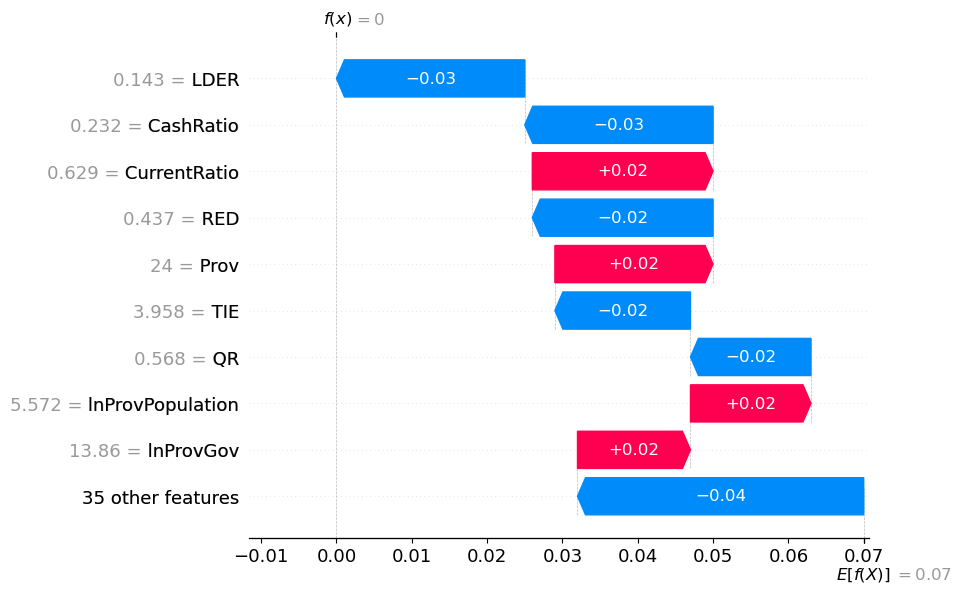

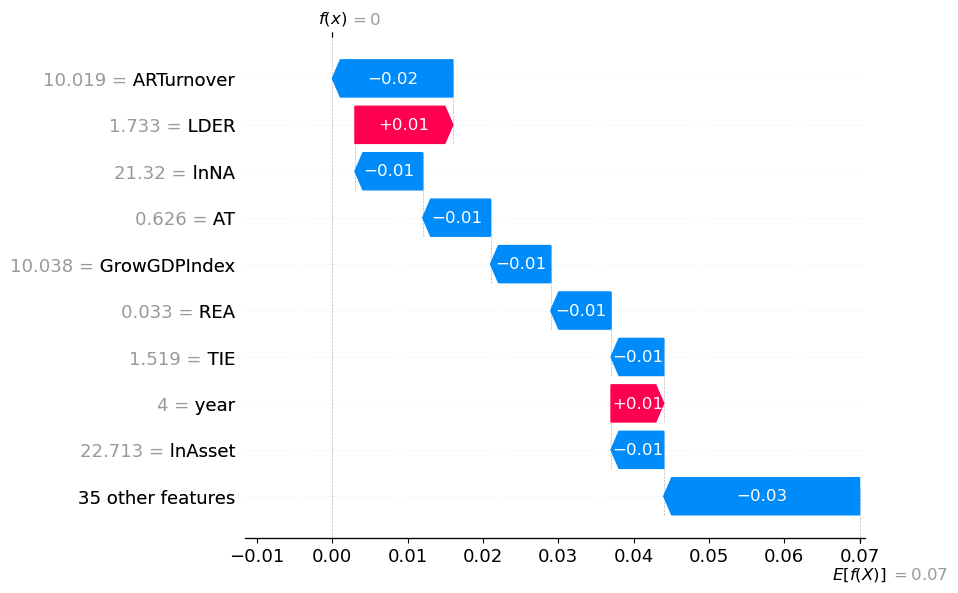

In [ ]:
violate_indices = np.where(y_test == 1)[0]
non_violate_indices = np.where(y_test == 0)[0]

# 确保至少有一个违约和非违约样本
if len(violate_indices) > 0 and len(non_violate_indices) > 0:
    violate_index = violate_indices[0]  # 获取第一个违约样本的索引
    non_violate_index = non_violate_indices[0]  # 获取第一个非违约样本的索引

    # 创建局部力图
    force_plot_violate = shap.force_plot(baseline_value, shap_values.values[violate_index], X_test.iloc[violate_index], feature_names=X_test.columns)
    force_plot_non_violate = shap.force_plot(baseline_value, shap_values.values[non_violate_index], X_test.iloc[non_violate_index], feature_names=X_test.columns)

    # 保存局部力图为HTML文件
    shap.save_html('default_shap_force_plot_1.html', force_plot_violate)
    shap.save_html('default_shap_force_plot_0.html', force_plot_non_violate)
else:
    print("没有足够的违约或非违约样本来生成力图。")

if len(violate_indices) > 0 and len(non_violate_indices) > 0:
    violate_index = violate_indices[0]  # 获取第一个违约样本的索引
    non_violate_index = non_violate_indices[0]  # 获取第一个非违约样本的索引

    # 创建瀑布图
    shap_values_instance_violate = shap.Explanation(values=shap_values.values[violate_index], 
                                                    base_values=shap_values.base_values[violate_index], 
                                                    data=X_test.iloc[violate_index], 
                                                    feature_names=X_test.columns)
    
    shap_values_instance_non_violate = shap.Explanation(values=shap_values.values[non_violate_index], 
                                                        base_values=shap_values.base_values[non_violate_index], 
                                                        data=X_test.iloc[non_violate_index], 
                                                        feature_names=X_test.columns)

    # 绘制瀑布图并保存为HTML
    shap.waterfall_plot(shap_values_instance_violate)
    plt.savefig('default_shap_waterfall_plot_1.png')
    plt.close()

    shap.waterfall_plot(shap_values_instance_non_violate)
    plt.savefig('default_shap_waterfall_plot_0.png')
    plt.close()
else:
    print("没有足够的违约或非违约样本来生成瀑布图。")


# 对SHAP值前五个指标，生成shap值散点图
# 保存名字为default_shap_plot_{name of feature}.pdf（pdf形式）
top_shap_indices = np.argsort(np.abs(shap_values.values).mean(0))[-15:]  # 取最大的15个SHAP值
for i in top_shap_indices:
    feature_name = X_test.columns[i]
    shap.dependence_plot(i, shap_values.values, X_test, display_features=X_test, show=False)  # 使用 display_features 传递X_test
    plt.title(feature_name)  # 设置图表标题为特征名
    plt.savefig(f'default_shap_plot_{feature_name}_dependence.pdf')
    plt.close()

for i in top_shap_indices:
    feature_name = X_test.columns[i]
    
    # 准备数据
    feature_values = X_test.iloc[:, i]  # 特征值
    shap_values_for_feature = shap_values.values[:, i]  # 对应的SHAP值
    
    # 创建图形
    plt.figure()
    plt.scatter(feature_values, shap_values_for_feature, alpha=0.5)  # 绘制散点图
    plt.xlabel('Feature Value of ' + feature_name)  # x轴标签
    plt.ylabel('SHAP Value')  # y轴标签
    plt.title('SHAP Scatter Plot for ' + feature_name)  # 图表标题
    
    # 保存图形
    plt.savefig(f'default_shap_plot_{feature_name}.pdf')
    plt.close()  # 关闭图形窗口以节省内存
